In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torchinfo
import torchtext.transforms as T
from seaborn import heatmap
from sklearn.model_selection import train_test_split
from torch import nn
from torch.utils.data import DataLoader
from torchlake.common.schemas import NlpContext
from torchlake.common.utils.platform import get_file_size, get_num_workers
from torchlake.sequence_data.models.lstm import LSTMDiscriminator
from torchlake.common.controller.trainer import ClassificationTrainer
from torchlake.common.controller.evaluator import ClassificationEvaluator
from torchlake.tag_prediction.controllers.trainer_bilstm_crf import BiLSTMCRFTrainer
from torchlake.tag_prediction.models.bilstm_crf import (BiLSTMCRF,
                                                        LinearCRFLoss)
from torchtext.data import get_tokenizer
from torchlake.common.utils.text import build_vocab
from tqdm import tqdm

# setting


In [2]:
artifacts_path = Path("../../artifacts/bilstm-crf")
artifacts_path.mkdir(exist_ok=True)

data_path = Path("../../data/nerDataset")

In [3]:
batch_size = 128
CONTEXT = NlpContext(device="cuda:0")

In [4]:
tokenizer = get_tokenizer("basic_english")

In [5]:
DEVICE = torch.device(CONTEXT.device)

In [6]:
NUM_WORKERS = get_num_workers()

# data


In [7]:
# data = pd.read_csv(data_path.joinpath("ner_dataset.csv"), encoding="latin-1")

In [8]:
# data["Sentence #"] = data["Sentence #"].ffill()

In [9]:
# speedup groupby to save you hours to 10 seconds
# data = data.set_index("Sentence #")

In [10]:
# new_df = data.groupby(level=(0)).apply(
#     lambda row: [row["Word"].str.cat(sep=" "), row["Tag"].str.cat(sep=" ")]
# )

In [11]:
# new_df = pd.DataFrame(new_df.tolist(), columns=["Text", "Label"])

In [12]:
# new_df.to_csv(data_path.joinpath("processed.csv"), index=False)

# load text data


In [13]:
new_df = pd.read_csv(data_path.joinpath("processed.csv"))

In [14]:
# TODO: stratified so every label are present in train and test
train_data, test_data = train_test_split(new_df, test_size=1/5, random_state=32)

In [15]:
train_data

,Text,Label
2122,U Win Tin was arrested in 1989 and is serving ...,B-org I-org I-org O O O B-tim O O O O O O O O ...
1095,The last time the Vatican issued a vacant see ...,O O O O B-gpe O O O O O O O B-tim O O O B-per ...
46391,Witnesses say a top Palestinian bombmaker for ...,O O O O B-gpe O O O O B-geo I-geo O O O O B-ti...
22794,Pakistani police say a suicide bomber crashed ...,B-gpe O O O O O O O O O O O O O O O O O O O O ...
31861,The Defense Department is investigating the ac...,O B-org I-org O O O O O
...,...,...
24828,The militant Hezbollah movement fought a 34-da...,O O B-org O O O O O O B-geo O B-tim O O O O O ...
20414,The rebels say they will continue until the mo...,O O O O O O O O O O O O O O O O O O O O O
9526,The Olympic torch will make two trips to the w...,O O O O O O O O O O O O O O O O O O O O B-tim ...
42539,There were no reports of injuries and no claim...,O O O O O O O O O O O O


In [16]:
vocab = build_vocab(
    train_data["Text"].str.lower().str.split(),
    context=CONTEXT,
)

In [17]:
label_vocab = build_vocab(
    train_data["Label"].str.lower().str.split(),
    context=CONTEXT,
)

In [18]:
VOCAB_SIZE = len(vocab)
NUM_CLASS = len(label_vocab)

In [19]:
VOCAB_SIZE, NUM_CLASS

(9104, 21)

In [20]:
text_transform = T.Sequential(
    T.VocabTransform(vocab),
    T.Truncate(CONTEXT.max_seq_len - 2),
    T.AddToken(token=CONTEXT.bos_idx, begin=True),
    T.AddToken(token=CONTEXT.eos_idx, begin=False),
    T.ToTensor(),
    T.PadTransform(CONTEXT.max_seq_len, CONTEXT.padding_idx),
)

In [21]:
label_transform = T.Sequential(
    T.VocabTransform(label_vocab),
    T.Truncate(CONTEXT.max_seq_len - 2),
    T.AddToken(token=CONTEXT.bos_idx, begin=True),
    T.AddToken(token=CONTEXT.eos_idx, begin=False),
    T.ToTensor(),
    T.PadTransform(CONTEXT.max_seq_len, CONTEXT.padding_idx),
)

In [22]:
def collate_fn(batch: np.ndarray):
    text_placeholder, label_placeholder = [], []

    for text, label in batch:
        text = tokenizer(text)
        text = text_transform(text)
        text_placeholder.append(text)
        
        label = tokenizer(label)
        label = label_transform(label)
        label_placeholder.append(label)

    return torch.stack(text_placeholder), torch.stack(label_placeholder)

In [23]:
train_iter = DataLoader(
    train_data.to_numpy(),
    batch_size=batch_size,
    collate_fn=collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=NUM_WORKERS,
)

test_iter = DataLoader(
    test_data.to_numpy(),
    batch_size=batch_size,
    collate_fn=collate_fn,
    num_workers=NUM_WORKERS,
)

In [24]:
for text, label in train_iter:
    # print(text[0], label[0])
    print(text.shape, label.shape)
    break

torch.Size([128, 256]) torch.Size([128, 256])


# model


In [25]:
EMBED_DIM = 300
HIDDEN_DIM = 256

In [26]:
model = BiLSTMCRF(
    VOCAB_SIZE,
    EMBED_DIM,
    HIDDEN_DIM,
    NUM_CLASS,
    num_layers=2,
    context=CONTEXT,
).to(DEVICE)

In [27]:
torchinfo.summary(model)

Layer (type:depth-idx)                   Param #
BiLSTMCRF                                --
├─LSTMDiscriminator: 1-1                 --
│    └─Embedding: 2-1                    2,731,200
│    └─LSTM: 2-2                         2,719,744
│    └─LayerNorm: 2-3                    1,024
│    └─Linear: 2-4                       10,773
├─LinearCRF: 1-2                         441
Total params: 5,463,182
Trainable params: 5,463,182
Non-trainable params: 0

# training


In [28]:
EPOCHES = 10

In [29]:
trainer = BiLSTMCRFTrainer(EPOCHES, DEVICE)

In [30]:
criterion = LinearCRFLoss(CONTEXT)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [31]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    "min",
    patience=2,
    threshold=0.05,
    threshold_mode="rel",
)

In [32]:
training_loss = trainer.run(
    train_iter,
    model,
    optimizer,
    criterion,
    scheduler,
)

  0%|          | 1/299 [00:00<01:57,  2.53it/s]

tensor(-20.3296, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-48.0878, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 5/299 [00:00<00:33,  8.88it/s]

tensor(-60.7925, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-78.0564, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-102.6581, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 7/299 [00:00<00:27, 10.75it/s]

tensor(-112.7099, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-158.0287, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-120.5031, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 11/299 [00:01<00:23, 12.25it/s]

tensor(-147.3912, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-117.2828, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-122.6959, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 13/299 [00:01<00:22, 12.97it/s]

tensor(-131.0540, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-134.4945, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-186.8913, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 17/299 [00:01<00:20, 13.55it/s]

tensor(-218.1324, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-227.0484, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-182.6066, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-157.8528, device='cuda:0', grad_fn=<MeanBackward0>)


  7%|▋         | 21/299 [00:01<00:19, 14.43it/s]

tensor(-252.7175, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-200.8039, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-177.1109, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 23/299 [00:01<00:18, 14.73it/s]

tensor(-245.6501, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-285.7666, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-130.3901, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 25/299 [00:02<00:19, 14.42it/s]

tensor(-267.7708, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-277.1347, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-321.5833, device='cuda:0', grad_fn=<MeanBackward0>)


 10%|▉         | 29/299 [00:02<00:21, 12.56it/s]

tensor(-291.1425, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-301.7807, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-390.2249, device='cuda:0', grad_fn=<MeanBackward0>)


 11%|█         | 33/299 [00:02<00:20, 12.73it/s]

tensor(-360.3290, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-326.4381, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-253.1146, device='cuda:0', grad_fn=<MeanBackward0>)


 12%|█▏        | 35/299 [00:02<00:20, 13.05it/s]

tensor(-300.4131, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-352.3659, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-319.9204, device='cuda:0', grad_fn=<MeanBackward0>)


 13%|█▎        | 39/299 [00:03<00:19, 13.58it/s]

tensor(-375.0490, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-436.6599, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-392.2670, device='cuda:0', grad_fn=<MeanBackward0>)


 14%|█▎        | 41/299 [00:03<00:19, 13.47it/s]

tensor(-350.2945, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-458.2780, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-525.8364, device='cuda:0', grad_fn=<MeanBackward0>)


 14%|█▍        | 43/299 [00:03<00:19, 13.43it/s]

tensor(-427.4854, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-609.6246, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-451.1060, device='cuda:0', grad_fn=<MeanBackward0>)


 16%|█▌        | 47/299 [00:03<00:19, 12.99it/s]

tensor(-342.7394, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-534.8763, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-545.0292, device='cuda:0', grad_fn=<MeanBackward0>)


 17%|█▋        | 51/299 [00:04<00:19, 13.02it/s]

tensor(-491.5287, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-439.6804, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-383.1026, device='cuda:0', grad_fn=<MeanBackward0>)


 18%|█▊        | 53/299 [00:04<00:18, 13.54it/s]

tensor(-525.1147, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-533.5577, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-479.9951, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-553.4783, device='cuda:0', grad_fn=<MeanBackward0>)


 19%|█▉        | 57/299 [00:04<00:18, 12.78it/s]

tensor(-567.7290, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-644.4803, device='cuda:0', grad_fn=<MeanBackward0>)


 20%|█▉        | 59/299 [00:04<00:19, 12.20it/s]

tensor(-436.8994, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-749.1342, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-609.7390, device='cuda:0', grad_fn=<MeanBackward0>)


 20%|██        | 61/299 [00:04<00:18, 12.85it/s]

tensor(-699.2965, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-472.0975, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-235.2191, device='cuda:0', grad_fn=<MeanBackward0>)


 22%|██▏       | 65/299 [00:05<00:20, 11.33it/s]

tensor(-571.8498, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-575.2371, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-674.2431, device='cuda:0', grad_fn=<MeanBackward0>)


 22%|██▏       | 67/299 [00:05<00:19, 11.70it/s]

tensor(-605.1067, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-607.7894, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-617.5019, device='cuda:0', grad_fn=<MeanBackward0>)


 24%|██▎       | 71/299 [00:05<00:19, 11.95it/s]

tensor(-715.2974, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-732.0032, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-747.3877, device='cuda:0', grad_fn=<MeanBackward0>)


 24%|██▍       | 73/299 [00:05<00:18, 12.28it/s]

tensor(-657.9970, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-757.2681, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-777.2485, device='cuda:0', grad_fn=<MeanBackward0>)


 26%|██▌       | 77/299 [00:06<00:17, 12.56it/s]

tensor(-787.4516, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-803.9771, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-712.3844, device='cuda:0', grad_fn=<MeanBackward0>)


 26%|██▋       | 79/299 [00:06<00:17, 12.83it/s]

tensor(-618.0139, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-945.7924, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-748.1991, device='cuda:0', grad_fn=<MeanBackward0>)


 28%|██▊       | 83/299 [00:06<00:16, 12.92it/s]

tensor(-859.0423, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-765.8524, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-1011.5142, device='cuda:0', grad_fn=<MeanBackward0>)


 28%|██▊       | 85/299 [00:06<00:16, 13.15it/s]

tensor(-908.8270, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-1027.9105, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-1045.4153, device='cuda:0', grad_fn=<MeanBackward0>)


 30%|██▉       | 89/299 [00:07<00:16, 12.85it/s]

tensor(-1060.2812, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-710.4915, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-718.8244, device='cuda:0', grad_fn=<MeanBackward0>)


 30%|███       | 91/299 [00:07<00:16, 12.99it/s]

tensor(-979.0504, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-871.3867, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-889.1650, device='cuda:0', grad_fn=<MeanBackward0>)


 32%|███▏      | 95/299 [00:07<00:16, 12.41it/s]

tensor(-1155.7883, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-772.2308, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-919.5928, device='cuda:0', grad_fn=<MeanBackward0>)


 33%|███▎      | 99/299 [00:07<00:15, 12.92it/s]

tensor(-1208.1926, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-1209.8164, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-817.0057, device='cuda:0', grad_fn=<MeanBackward0>)


 34%|███▍      | 101/299 [00:08<00:15, 13.05it/s]

tensor(-1101.4636, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-1107.2915, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-1294.7993, device='cuda:0', grad_fn=<MeanBackward0>)


 34%|███▍      | 103/299 [00:08<00:14, 13.24it/s]

tensor(-1150.5679, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-1171.3618, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-885.5642, device='cuda:0', grad_fn=<MeanBackward0>)


 36%|███▌      | 107/299 [00:08<00:14, 13.14it/s]

tensor(-733.9996, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-1206.7799, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-1221.6025, device='cuda:0', grad_fn=<MeanBackward0>)


 36%|███▋      | 109/299 [00:08<00:14, 13.21it/s]

tensor(-1392.1511, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-1087.7914, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-1429.6528, device='cuda:0', grad_fn=<MeanBackward0>)


 38%|███▊      | 113/299 [00:08<00:14, 13.25it/s]

tensor(-1290.9807, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-969.6576, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-1476.1624, device='cuda:0', grad_fn=<MeanBackward0>)


 38%|███▊      | 115/299 [00:09<00:14, 13.14it/s]

tensor(-1327.9458, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-1507.2277, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-1537.6057, device='cuda:0', grad_fn=<MeanBackward0>)


 40%|███▉      | 119/299 [00:09<00:13, 13.45it/s]

tensor(-1370.7664, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-1554.2568, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-1232.8955, device='cuda:0', grad_fn=<MeanBackward0>)


 41%|████      | 123/299 [00:09<00:13, 13.37it/s]

tensor(-1057.4268, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-1451.4331, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-1081.0231, device='cuda:0', grad_fn=<MeanBackward0>)


 42%|████▏     | 125/299 [00:09<00:13, 12.53it/s]

tensor(-1845.6193, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-1858.4487, device='cuda:0', grad_fn=<MeanBackward0>)


 42%|████▏     | 127/299 [00:10<00:14, 11.55it/s]

tensor(-1501.4617, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-1521.3979, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-1354.2908, device='cuda:0', grad_fn=<MeanBackward0>)


 44%|████▍     | 131/299 [00:10<00:14, 12.00it/s]

tensor(-1552.9572, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-1173.7119, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-1991.0825, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-1621.4783, device='cuda:0', grad_fn=<MeanBackward0>)


 45%|████▌     | 135/299 [00:10<00:12, 12.94it/s]

tensor(-1417.2872, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-1431.9390, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-1882.9055, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-1661.9108, device='cuda:0', grad_fn=<MeanBackward0>)


 46%|████▌     | 137/299 [00:10<00:12, 13.35it/s]

tensor(-2122.1484, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-1692.5325, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-1725.8767, device='cuda:0', grad_fn=<MeanBackward0>)


 47%|████▋     | 141/299 [00:11<00:12, 13.04it/s]

tensor(-1737.1677, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-1543.4912, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-1772.6296, device='cuda:0', grad_fn=<MeanBackward0>)


 48%|████▊     | 143/299 [00:11<00:12, 12.68it/s]

tensor(-1567.2639, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-2039.9490, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-2077.7612, device='cuda:0', grad_fn=<MeanBackward0>)


 49%|████▉     | 147/299 [00:11<00:12, 12.53it/s]

tensor(-2084.5098, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-1631.8997, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-2117.0645, device='cuda:0', grad_fn=<MeanBackward0>)


 51%|█████     | 151/299 [00:11<00:11, 12.72it/s]

tensor(-1414.3079, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-1676.1577, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-2693.8228, device='cuda:0', grad_fn=<MeanBackward0>)


 51%|█████     | 153/299 [00:12<00:11, 13.24it/s]

tensor(-2194.3970, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-2478.6138, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-1737.7548, device='cuda:0', grad_fn=<MeanBackward0>)


 53%|█████▎    | 157/299 [00:12<00:10, 13.30it/s]

tensor(-1250.1420, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-2519.2690, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-1543.7035, device='cuda:0', grad_fn=<MeanBackward0>)


 53%|█████▎    | 159/299 [00:12<00:11, 12.54it/s]

tensor(-1796.1147, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-1841.7982, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-2120.2041, device='cuda:0', grad_fn=<MeanBackward0>)


 55%|█████▍    | 163/299 [00:12<00:10, 12.40it/s]

tensor(-2128.1104, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-2161.8525, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-2165.4321, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-1916.4274, device='cuda:0', grad_fn=<MeanBackward0>)


 56%|█████▌    | 167/299 [00:13<00:10, 13.11it/s]

tensor(-2205.1362, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-2496.5413, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-2816.7087, device='cuda:0', grad_fn=<MeanBackward0>)


 57%|█████▋    | 169/299 [00:13<00:09, 13.13it/s]

tensor(-2831.6680, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-2292.3301, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-2889.8669, device='cuda:0', grad_fn=<MeanBackward0>)


 58%|█████▊    | 173/299 [00:13<00:09, 13.01it/s]

tensor(-2631.3760, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-2048.8093, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-2659.2847, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-2702.0488, device='cuda:0', grad_fn=<MeanBackward0>)


 59%|█████▉    | 177/299 [00:13<00:09, 13.51it/s]

tensor(-2069.6184, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-1802.1729, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-2149.7275, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-1216.8280, device='cuda:0', grad_fn=<MeanBackward0>)


 60%|█████▉    | 179/299 [00:14<00:09, 12.69it/s]

tensor(-2179.3813, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-2192.3110, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-2509.1318, device='cuda:0', grad_fn=<MeanBackward0>)


 61%|██████    | 183/299 [00:14<00:09, 12.55it/s]

tensor(-2205.9683, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-2869.3188, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-2260.2520, device='cuda:0', grad_fn=<MeanBackward0>)


 62%|██████▏   | 185/299 [00:14<00:08, 12.98it/s]

tensor(-1934.8030, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-2924.3452, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-2999.9993, device='cuda:0', grad_fn=<MeanBackward0>)


 63%|██████▎   | 189/299 [00:14<00:08, 13.16it/s]

tensor(-2329.3406, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-2347.3347, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-2355.9434, device='cuda:0', grad_fn=<MeanBackward0>)


 65%|██████▍   | 193/299 [00:15<00:07, 13.26it/s]

tensor(-2378.4216, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-2389.2991, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-2773.5728, device='cuda:0', grad_fn=<MeanBackward0>)


 65%|██████▌   | 195/299 [00:15<00:07, 13.35it/s]

tensor(-2778.7349, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-3499.7383, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-2816.4634, device='cuda:0', grad_fn=<MeanBackward0>)


 67%|██████▋   | 199/299 [00:15<00:07, 13.78it/s]

tensor(-2830.4604, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-2463.0544, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-2512.6582, device='cuda:0', grad_fn=<MeanBackward0>)


 67%|██████▋   | 201/299 [00:15<00:07, 13.65it/s]

tensor(-2547.9536, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-2556.6174, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-1451.5591, device='cuda:0', grad_fn=<MeanBackward0>)


 68%|██████▊   | 203/299 [00:15<00:07, 13.06it/s]

tensor(-3324.9226, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-2621.1084, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-2257.5962, device='cuda:0', grad_fn=<MeanBackward0>)


 69%|██████▉   | 207/299 [00:16<00:07, 13.14it/s]

tensor(-2277.9751, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-3016.0381, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-3856.0947, device='cuda:0', grad_fn=<MeanBackward0>)


 70%|██████▉   | 209/299 [00:16<00:06, 13.06it/s]

tensor(-3088.4751, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-3115.2485, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-2355.3257, device='cuda:0', grad_fn=<MeanBackward0>)


 71%|███████   | 213/299 [00:16<00:06, 12.97it/s]

tensor(-3157.4832, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-2361.4243, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-3624.4336, device='cuda:0', grad_fn=<MeanBackward0>)


 72%|███████▏  | 215/299 [00:16<00:06, 13.11it/s]

tensor(-2817.3486, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-2425.2695, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-2452.2666, device='cuda:0', grad_fn=<MeanBackward0>)


 73%|███████▎  | 219/299 [00:17<00:06, 12.09it/s]

tensor(-3278.1360, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-3302.3438, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-2898.0181, device='cuda:0', grad_fn=<MeanBackward0>)


 74%|███████▍  | 221/299 [00:17<00:06, 12.57it/s]

tensor(-4657.1016, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-2954.4067, device='cuda:0', grad_fn=<MeanBackward0>)


 75%|███████▌  | 225/299 [00:17<00:06, 12.04it/s]

tensor(-3381.2766, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-3408.3643, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-2130.7136, device='cuda:0', grad_fn=<MeanBackward0>)


 76%|███████▌  | 227/299 [00:17<00:05, 12.62it/s]

tensor(-3473.8208, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-3908.0432, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-3518.0076, device='cuda:0', grad_fn=<MeanBackward0>)


 77%|███████▋  | 231/299 [00:18<00:04, 13.60it/s]

tensor(-3100.8682, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-3532.8840, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-3104.8062, device='cuda:0', grad_fn=<MeanBackward0>)


 78%|███████▊  | 233/299 [00:18<00:04, 13.73it/s]

tensor(-2685.5481, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-4061.6755, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-4086.5320, device='cuda:0', grad_fn=<MeanBackward0>)


 79%|███████▉  | 237/299 [00:18<00:04, 13.77it/s]

tensor(-3196.8411, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-3238.0986, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-3696.3833, device='cuda:0', grad_fn=<MeanBackward0>)


 80%|███████▉  | 239/299 [00:18<00:04, 14.21it/s]

tensor(-3743.5508, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-4226.1616, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-3768.5801, device='cuda:0', grad_fn=<MeanBackward0>)


 81%|████████  | 241/299 [00:18<00:04, 13.97it/s]

tensor(-3804.3481, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-4330.1104, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-2884.5283, device='cuda:0', grad_fn=<MeanBackward0>)


 82%|████████▏ | 245/299 [00:19<00:04, 12.97it/s]

tensor(-4347.1118, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-2431.8237, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-3414.7744, device='cuda:0', grad_fn=<MeanBackward0>)


 83%|████████▎ | 247/299 [00:19<00:03, 13.40it/s]

tensor(-3452.0229, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-4475.9619, device='cuda:0', grad_fn=<MeanBackward0>)


 83%|████████▎ | 249/299 [00:19<00:04, 11.66it/s]

tensor(-4018.6133, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-3003.6641, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-4568.5156, device='cuda:0', grad_fn=<MeanBackward0>)


 85%|████████▍ | 253/299 [00:19<00:03, 12.50it/s]

tensor(-1492.6832, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-4078.2410, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-4144.8232, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-3610.2878, device='cuda:0', grad_fn=<MeanBackward0>)


 86%|████████▌ | 257/299 [00:20<00:03, 13.46it/s]

tensor(-3138.5854, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-3642.6196, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-4740.7866, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-4779.8350, device='cuda:0', grad_fn=<MeanBackward0>)


 87%|████████▋ | 261/299 [00:20<00:02, 14.20it/s]

tensor(-4225.6572, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-3231.1633, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-3218.8757, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-3242.7627, device='cuda:0', grad_fn=<MeanBackward0>)


 89%|████████▊ | 265/299 [00:20<00:02, 14.57it/s]

tensor(-3807.3833, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-3248.7178, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-4905.4907, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-3897.6597, device='cuda:0', grad_fn=<MeanBackward0>)


 90%|████████▉ | 269/299 [00:20<00:02, 14.35it/s]

tensor(-5043.9414, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-5036.9399, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-5659.2974, device='cuda:0', grad_fn=<MeanBackward0>)


 91%|█████████ | 271/299 [00:21<00:02, 13.87it/s]

tensor(-4577.7529, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-5120.8359, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-5149.3652, device='cuda:0', grad_fn=<MeanBackward0>)


 92%|█████████▏| 275/299 [00:21<00:01, 13.46it/s]

tensor(-4024.9131, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-4630.7900, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-4657.5439, device='cuda:0', grad_fn=<MeanBackward0>)


 93%|█████████▎| 279/299 [00:21<00:01, 13.91it/s]

tensor(-4710.7417, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-4726.4253, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-4176.1055, device='cuda:0', grad_fn=<MeanBackward0>)


 94%|█████████▍| 281/299 [00:21<00:01, 14.00it/s]

tensor(-4787.6934, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-4782.0244, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-4853.6587, device='cuda:0', grad_fn=<MeanBackward0>)


 95%|█████████▌| 285/299 [00:22<00:01, 13.91it/s]

tensor(-5457.5000, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-4853.8438, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-5546.5713, device='cuda:0', grad_fn=<MeanBackward0>)


 96%|█████████▌| 287/299 [00:22<00:00, 13.84it/s]

tensor(-3091.3875, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-4349.5396, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-4326.9414, device='cuda:0', grad_fn=<MeanBackward0>)


 97%|█████████▋| 289/299 [00:22<00:00, 14.02it/s]

tensor(-3775.9268, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-3785.3538, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-6381.9785, device='cuda:0', grad_fn=<MeanBackward0>)


 98%|█████████▊| 293/299 [00:22<00:00, 12.58it/s]

tensor(-4479.6221, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-4500.7461, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-5784.7275, device='cuda:0', grad_fn=<MeanBackward0>)


 99%|█████████▉| 297/299 [00:23<00:00, 13.23it/s]

tensor(-5171.0801, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-5229.3301, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-5211.2129, device='cuda:0', grad_fn=<MeanBackward0>)


100%|██████████| 299/299 [00:23<00:00, 12.91it/s]


tensor(-4636.6807, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-5945.8301, device='cuda:0', grad_fn=<MeanBackward0>)
epoch 1 : -1043.5908123450135


  0%|          | 0/299 [00:00<?, ?it/s]

tensor(-5339.2822, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 1/299 [00:00<00:31,  9.49it/s]

tensor(-6676.2217, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-4028.9270, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 3/299 [00:00<00:24, 12.24it/s]

tensor(-4719.9629, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 5/299 [00:00<00:23, 12.40it/s]

tensor(-4057.2043, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-4801.1030, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 7/299 [00:00<00:22, 12.75it/s]

tensor(-5457.4854, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-5538.2139, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-5516.9214, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 9/299 [00:00<00:22, 13.14it/s]

tensor(-4874.0762, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 11/299 [00:00<00:21, 13.44it/s]

tensor(-5589.2134, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-6332.0288, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 13/299 [00:00<00:21, 13.46it/s]

tensor(-6351.2812, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-5716.9307, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-6454.8096, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▌         | 15/299 [00:01<00:21, 13.44it/s]

tensor(-6470.6016, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 17/299 [00:01<00:21, 13.21it/s]

tensor(-6518.1816, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-6544.5127, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▋         | 19/299 [00:01<00:21, 13.31it/s]

tensor(-7284.9209, device='cuda:0', grad_fn=<MeanBackward0>)


  7%|▋         | 21/299 [00:01<00:20, 13.43it/s]

tensor(-5133.3760, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-5207.9385, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-5130.4937, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 23/299 [00:01<00:20, 13.37it/s]

tensor(-5987.2090, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-6028.9712, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 25/299 [00:01<00:20, 13.66it/s]

tensor(-3770.9346, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-7604.4082, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-4577.3389, device='cuda:0', grad_fn=<MeanBackward0>)


  9%|▉         | 27/299 [00:02<00:21, 12.89it/s]

tensor(-6871.1567, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-5402.6553, device='cuda:0', grad_fn=<MeanBackward0>)


 10%|▉         | 29/299 [00:02<00:20, 13.18it/s]

tensor(-7013.3955, device='cuda:0', grad_fn=<MeanBackward0>)


 10%|█         | 31/299 [00:02<00:20, 12.99it/s]

tensor(-6218.6519, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-5428.8188, device='cuda:0', grad_fn=<MeanBackward0>)


 11%|█         | 33/299 [00:02<00:20, 13.17it/s]

tensor(-5513.8311, device='cuda:0', grad_fn=<MeanBackward0>)


 12%|█▏        | 35/299 [00:02<00:19, 13.67it/s]

tensor(-5459.5303, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-6387.6431, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-7175.1196, device='cuda:0', grad_fn=<MeanBackward0>)


 12%|█▏        | 37/299 [00:02<00:22, 11.66it/s]

tensor(-6403.4473, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-7257.2725, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-5605.1543, device='cuda:0', grad_fn=<MeanBackward0>)


 13%|█▎        | 39/299 [00:03<00:22, 11.64it/s]

tensor(-4841.8291, device='cuda:0', grad_fn=<MeanBackward0>)


 14%|█▎        | 41/299 [00:03<00:21, 12.01it/s]

tensor(-7357.2324, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-6585.1851, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-7410.2178, device='cuda:0', grad_fn=<MeanBackward0>)


 15%|█▌        | 45/299 [00:03<00:20, 12.59it/s]

tensor(-6662.8447, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-7478.3740, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-5850.0161, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-9273.1992, device='cuda:0', grad_fn=<MeanBackward0>)


 16%|█▋        | 49/299 [00:03<00:18, 13.57it/s]

tensor(-6753.1396, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-5993.3154, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-7727.4995, device='cuda:0', grad_fn=<MeanBackward0>)


 18%|█▊        | 53/299 [00:04<00:17, 13.99it/s]

tensor(-5117.0137, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-6012.8555, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-6955.5654, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-5166.9863, device='cuda:0', grad_fn=<MeanBackward0>)


 19%|█▉        | 57/299 [00:04<00:17, 13.94it/s]

tensor(-7873.2480, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-9673.1221, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-5221.9478, device='cuda:0', grad_fn=<MeanBackward0>)


 20%|█▉        | 59/299 [00:04<00:17, 14.10it/s]

tensor(-5334.1611, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-6242.8760, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-8057.8691, device='cuda:0', grad_fn=<MeanBackward0>)


 20%|██        | 61/299 [00:04<00:16, 14.03it/s]

tensor(-7158.3936, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-8138.4775, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-6354.3701, device='cuda:0', grad_fn=<MeanBackward0>)


 22%|██▏       | 65/299 [00:04<00:16, 13.99it/s]

tensor(-7252.4854, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-9150.8926, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-9218.3975, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-7410.7593, device='cuda:0', grad_fn=<MeanBackward0>)


 23%|██▎       | 69/299 [00:05<00:16, 14.12it/s]

tensor(-5575.1924, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-6549.1670, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-8363.9600, device='cuda:0', grad_fn=<MeanBackward0>)


 24%|██▍       | 73/299 [00:05<00:16, 13.77it/s]

tensor(-5627.0449, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-6567.9238, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-6625.4253, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-5738.7188, device='cuda:0', grad_fn=<MeanBackward0>)


 25%|██▌       | 75/299 [00:05<00:15, 14.05it/s]

tensor(-9462.1992, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-7695.6592, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-7723.0537, device='cuda:0', grad_fn=<MeanBackward0>)


 26%|██▋       | 79/299 [00:05<00:18, 12.05it/s]

tensor(-6795.7812, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-7794.3550, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-9796.9414, device='cuda:0', grad_fn=<MeanBackward0>)


 28%|██▊       | 83/299 [00:06<00:17, 12.70it/s]

tensor(-5865.2583, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-5910.8018, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-8946.0449, device='cuda:0', grad_fn=<MeanBackward0>)


 28%|██▊       | 85/299 [00:06<00:16, 13.23it/s]

tensor(-7991.0625, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-9955.6162, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-8990.5684, device='cuda:0', grad_fn=<MeanBackward0>)


 30%|██▉       | 89/299 [00:06<00:15, 13.68it/s]

tensor(-10995.3301, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-8025.6372, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-7147.8682, device='cuda:0', grad_fn=<MeanBackward0>)


 30%|███       | 91/299 [00:06<00:14, 14.20it/s]

tensor(-8224.5352, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-9243.4902, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-7268.1548, device='cuda:0', grad_fn=<MeanBackward0>)


 32%|███▏      | 95/299 [00:07<00:14, 14.06it/s]

tensor(-7188.2734, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-8339.6973, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-8370.7773, device='cuda:0', grad_fn=<MeanBackward0>)


 32%|███▏      | 97/299 [00:07<00:14, 13.94it/s]

tensor(-8416.7422, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-7391.7134, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-6356.9507, device='cuda:0', grad_fn=<MeanBackward0>)


 33%|███▎      | 99/299 [00:07<00:14, 13.75it/s]

tensor(-6318.4150, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-8526.4766, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-8537.1953, device='cuda:0', grad_fn=<MeanBackward0>)


 34%|███▍      | 103/299 [00:07<00:14, 13.22it/s]

tensor(-7525.4678, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-9765.9561, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-6459.5737, device='cuda:0', grad_fn=<MeanBackward0>)


 35%|███▌      | 105/299 [00:07<00:14, 13.48it/s]

tensor(-9807.9258, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-7666.3350, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-8732.8477, device='cuda:0', grad_fn=<MeanBackward0>)


 36%|███▋      | 109/299 [00:08<00:14, 12.81it/s]

tensor(-7641.8628, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-7797.0957, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-8872.0449, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-7830.8032, device='cuda:0', grad_fn=<MeanBackward0>)


 38%|███▊      | 113/299 [00:08<00:13, 13.34it/s]

tensor(-6707.5259, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-10146.0430, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-10120.1855, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-7973.9644, device='cuda:0', grad_fn=<MeanBackward0>)


 39%|███▉      | 117/299 [00:08<00:13, 13.31it/s]

tensor(-11399.3906, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-9141.0957, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-3435.9917, device='cuda:0', grad_fn=<MeanBackward0>)


 40%|███▉      | 119/299 [00:08<00:13, 13.43it/s]

tensor(-8106.6904, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-8126.4209, device='cuda:0', grad_fn=<MeanBackward0>)


 40%|████      | 121/299 [00:09<00:15, 11.39it/s]

tensor(-9360.5879, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-6983.9697, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-10444.0762, device='cuda:0', grad_fn=<MeanBackward0>)


 42%|████▏     | 125/299 [00:09<00:14, 12.36it/s]

tensor(-9393.1406, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-6897.4375, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-9477.6699, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-9440.6904, device='cuda:0', grad_fn=<MeanBackward0>)


 43%|████▎     | 129/299 [00:09<00:12, 13.14it/s]

tensor(-9531.2607, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-7227.5083, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-6019.7588, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-8365.6895, device='cuda:0', grad_fn=<MeanBackward0>)


 44%|████▍     | 133/299 [00:10<00:12, 13.34it/s]

tensor(-9652.3379, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-10907.9160, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-10895.5723, device='cuda:0', grad_fn=<MeanBackward0>)


 46%|████▌     | 137/299 [00:10<00:11, 13.63it/s]

tensor(-8595.6787, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-11092.4932, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-6126.9673, device='cuda:0', grad_fn=<MeanBackward0>)


 46%|████▋     | 139/299 [00:10<00:11, 13.92it/s]

tensor(-7402.9463, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-7444.1948, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-8645.4512, device='cuda:0', grad_fn=<MeanBackward0>)


 48%|████▊     | 143/299 [00:10<00:11, 13.80it/s]

tensor(-9996.6592, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-9970.0840, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-12594.9834, device='cuda:0', grad_fn=<MeanBackward0>)


 48%|████▊     | 145/299 [00:10<00:11, 13.25it/s]

tensor(-7579.2422, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-10143.1455, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-11505.9854, device='cuda:0', grad_fn=<MeanBackward0>)


 49%|████▉     | 147/299 [00:11<00:11, 13.25it/s]

tensor(-8847.0420, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-10297.3848, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-9035.6387, device='cuda:0', grad_fn=<MeanBackward0>)


 51%|█████     | 151/299 [00:11<00:12, 11.92it/s]

tensor(-7675.6641, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-9058.4023, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-11731.0361, device='cuda:0', grad_fn=<MeanBackward0>)


 52%|█████▏    | 155/299 [00:11<00:11, 12.94it/s]

tensor(-7811.8926, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-5233.2007, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-11858.1562, device='cuda:0', grad_fn=<MeanBackward0>)


 53%|█████▎    | 157/299 [00:11<00:10, 13.54it/s]

tensor(-11924.3906, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-7887.1382, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-10668.7607, device='cuda:0', grad_fn=<MeanBackward0>)


 53%|█████▎    | 159/299 [00:12<00:10, 13.19it/s]

tensor(-10738.3320, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-6645.7041, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-13422.5000, device='cuda:0', grad_fn=<MeanBackward0>)


 55%|█████▍    | 163/299 [00:12<00:10, 12.79it/s]

tensor(-9349.1416, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-12245.4150, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-13527.7480, device='cuda:0', grad_fn=<MeanBackward0>)


 56%|█████▌    | 167/299 [00:12<00:10, 13.11it/s]

tensor(-9461.3906, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-10953.6035, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-13673.4277, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-12423.3887, device='cuda:0', grad_fn=<MeanBackward0>)


 57%|█████▋    | 171/299 [00:12<00:09, 13.60it/s]

tensor(-8289.2324, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-12473.8779, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-12542.3252, device='cuda:0', grad_fn=<MeanBackward0>)


 58%|█████▊    | 173/299 [00:13<00:10, 12.30it/s]

tensor(-12523.4258, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-11196., device='cuda:0', grad_fn=<MeanBackward0>)


 59%|█████▊    | 175/299 [00:13<00:10, 11.87it/s]

tensor(-9912.3828, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-9840.8906, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-7074.3623, device='cuda:0', grad_fn=<MeanBackward0>)


 60%|█████▉    | 179/299 [00:13<00:08, 13.43it/s]

tensor(-8487.0791, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-12810.5547, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-10137.0215, device='cuda:0', grad_fn=<MeanBackward0>)


 61%|██████    | 181/299 [00:13<00:08, 13.42it/s]

tensor(-12964.1240, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-10086.1230, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-10154.3877, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-5779.4556, device='cuda:0', grad_fn=<MeanBackward0>)


 62%|██████▏   | 185/299 [00:14<00:08, 13.16it/s]

tensor(-10227.7480, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-13147.1260, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-10235.3301, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-8855.1504, device='cuda:0', grad_fn=<MeanBackward0>)


 63%|██████▎   | 189/299 [00:14<00:07, 14.04it/s]

tensor(-8908.1504, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-13380.3242, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-10421.2949, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-13460.1201, device='cuda:0', grad_fn=<MeanBackward0>)


 65%|██████▍   | 193/299 [00:14<00:07, 14.41it/s]

tensor(-11958.1113, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-16457.0527, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-15173.2832, device='cuda:0', grad_fn=<MeanBackward0>)


 66%|██████▌   | 197/299 [00:14<00:07, 14.34it/s]

tensor(-12124.1211, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-13648.6719, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-13737.1680, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-10711.6924, device='cuda:0', grad_fn=<MeanBackward0>)


 67%|██████▋   | 201/299 [00:15<00:06, 14.72it/s]

tensor(-15451.9971, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-13787.0410, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-13981.2305, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-12479.9365, device='cuda:0', grad_fn=<MeanBackward0>)


 69%|██████▊   | 205/299 [00:15<00:06, 14.73it/s]

tensor(-10902.2559, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-12490.4814, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-12571.2500, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-12733.6992, device='cuda:0', grad_fn=<MeanBackward0>)


 70%|██████▉   | 209/299 [00:15<00:06, 14.96it/s]

tensor(-11074.6758, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-9567.3340, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-11115.0293, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-14378.2373, device='cuda:0', grad_fn=<MeanBackward0>)


 71%|███████   | 211/299 [00:15<00:05, 14.88it/s]

tensor(-17608.0781, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-14545.4834, device='cuda:0', grad_fn=<MeanBackward0>)


 72%|███████▏  | 215/299 [00:16<00:06, 13.16it/s]

tensor(-11388.9805, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-14510.8291, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-9782.5557, device='cuda:0', grad_fn=<MeanBackward0>)


 73%|███████▎  | 217/299 [00:16<00:05, 13.80it/s]

tensor(-13101.8223, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-14811.7402, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-13129.4307, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-11571.8516, device='cuda:0', grad_fn=<MeanBackward0>)


 74%|███████▍  | 221/299 [00:16<00:05, 14.38it/s]

tensor(-4931.8330, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-13319.7617, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-10083.5977, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-15109.1016, device='cuda:0', grad_fn=<MeanBackward0>)


 75%|███████▌  | 225/299 [00:16<00:05, 14.53it/s]

tensor(-13319.9922, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-13563.9473, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-13501.4619, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-15176.2314, device='cuda:0', grad_fn=<MeanBackward0>)


 77%|███████▋  | 229/299 [00:17<00:04, 14.92it/s]

tensor(-13608.8008, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-13583.6123, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-15419.3809, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-11941.8281, device='cuda:0', grad_fn=<MeanBackward0>)


 78%|███████▊  | 233/299 [00:17<00:04, 14.43it/s]

tensor(-15605.9629, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-13788.0361, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-12143.7451, device='cuda:0', grad_fn=<MeanBackward0>)


 79%|███████▊  | 235/299 [00:17<00:04, 14.73it/s]

tensor(-12224.8428, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-12266.2109, device='cuda:0', grad_fn=<MeanBackward0>)


 79%|███████▉  | 237/299 [00:17<00:04, 12.82it/s]

tensor(-15648.8652, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-17707.7578, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-14082.0234, device='cuda:0', grad_fn=<MeanBackward0>)


 81%|████████  | 241/299 [00:18<00:04, 12.37it/s]

tensor(-12254.3809, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-14210.2168, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-14180.8154, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-12462.4980, device='cuda:0', grad_fn=<MeanBackward0>)


 82%|████████▏ | 245/299 [00:18<00:04, 13.11it/s]

tensor(-16022.5586, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-14345.9551, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-16169.5400, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-10772.2900, device='cuda:0', grad_fn=<MeanBackward0>)


 83%|████████▎ | 249/299 [00:18<00:03, 12.90it/s]

tensor(-10887.9434, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-12744.5068, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-14617.6445, device='cuda:0', grad_fn=<MeanBackward0>)


 84%|████████▍ | 251/299 [00:18<00:03, 13.42it/s]

tensor(-18379., device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-14694.7354, device='cuda:0', grad_fn=<MeanBackward0>)


 85%|████████▌ | 255/299 [00:19<00:03, 12.36it/s]

tensor(-18469.8574, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-14772.5996, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-18568.5508, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-11042.1260, device='cuda:0', grad_fn=<MeanBackward0>)


 87%|████████▋ | 259/299 [00:19<00:03, 13.31it/s]

tensor(-13100.0195, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-13111.5547, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-15045.3027, device='cuda:0', grad_fn=<MeanBackward0>)


 87%|████████▋ | 261/299 [00:19<00:02, 13.48it/s]

tensor(-18828.2383, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-15164.5684, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-13265.4180, device='cuda:0', grad_fn=<MeanBackward0>)


 89%|████████▊ | 265/299 [00:19<00:02, 13.79it/s]

tensor(-15166.9805, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-17073.7344, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-13327.3623, device='cuda:0', grad_fn=<MeanBackward0>)


 89%|████████▉ | 267/299 [00:19<00:02, 14.22it/s]

tensor(-17336.2227, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-15412.8457, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-15345.3594, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-17506.6250, device='cuda:0', grad_fn=<MeanBackward0>)


 91%|█████████ | 271/299 [00:20<00:01, 14.03it/s]

tensor(-13670.0527, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-15624.3516, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-23631.8613, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-11896.1973, device='cuda:0', grad_fn=<MeanBackward0>)


 92%|█████████▏| 275/299 [00:20<00:01, 13.72it/s]

tensor(-13843.4619, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-15915.2715, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-13909.2852, device='cuda:0', grad_fn=<MeanBackward0>)


 93%|█████████▎| 279/299 [00:20<00:01, 13.96it/s]

tensor(-13875.2090, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-16056.2031, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-16040.9824, device='cuda:0', grad_fn=<MeanBackward0>)


 94%|█████████▍| 281/299 [00:20<00:01, 13.29it/s]

tensor(-11934.8604, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-18151.0078, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-18083.7871, device='cuda:0', grad_fn=<MeanBackward0>)


 95%|█████████▍| 283/299 [00:21<00:01, 13.28it/s]

tensor(-14250.3799, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-16297.4297, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-12221.1777, device='cuda:0', grad_fn=<MeanBackward0>)


 96%|█████████▌| 287/299 [00:21<00:01, 11.49it/s]

tensor(-16467.0859, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-16416.4434, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-14409.9746, device='cuda:0', grad_fn=<MeanBackward0>)


 97%|█████████▋| 291/299 [00:21<00:00, 12.70it/s]

tensor(-14475.8555, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-14562.5840, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-8326.9980, device='cuda:0', grad_fn=<MeanBackward0>)


 98%|█████████▊| 293/299 [00:21<00:00, 12.48it/s]

tensor(-16654.7227, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-18800.5703, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-16818.3379, device='cuda:0', grad_fn=<MeanBackward0>)


 99%|█████████▉| 297/299 [00:22<00:00, 12.98it/s]

tensor(-18900.7812, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-23103.9609, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-14830.0791, device='cuda:0', grad_fn=<MeanBackward0>)


100%|██████████| 299/299 [00:22<00:00, 13.34it/s]


tensor(-14931.7197, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-16888.4531, device='cuda:0', grad_fn=<MeanBackward0>)
epoch 2 : -5171.347174500941


  0%|          | 0/299 [00:00<?, ?it/s]

tensor(-17007.2812, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 2/299 [00:00<00:23, 12.49it/s]

tensor(-17134.6094, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-12833.9141, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 4/299 [00:00<00:22, 13.13it/s]

tensor(-19471.1582, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 6/299 [00:00<00:21, 13.67it/s]

tensor(-17105.9355, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-21707.4004, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-17352.8496, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 8/299 [00:00<00:20, 13.92it/s]

tensor(-15183.1348, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-22062.3379, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 10/299 [00:00<00:21, 13.64it/s]

tensor(-11002.4883, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-24200.0391, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 12/299 [00:00<00:23, 12.00it/s]

tensor(-19820.1230, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-17588.9668, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-15529.3574, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▌         | 16/299 [00:01<00:21, 13.15it/s]

tensor(-20151.8398, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-17826.2207, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-17816.0156, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-13380.9141, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 18/299 [00:01<00:20, 13.45it/s]

tensor(-15545.2041, device='cuda:0', grad_fn=<MeanBackward0>)


  7%|▋         | 20/299 [00:01<00:20, 13.50it/s]

tensor(-15726.4043, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-22583.4531, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-20112., device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 24/299 [00:01<00:19, 13.92it/s]

tensor(-20446.4980, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-20503.1680, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-13608.7246, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-23082.0703, device='cuda:0', grad_fn=<MeanBackward0>)


  9%|▉         | 28/299 [00:02<00:19, 14.05it/s]

tensor(-9046.1260, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-20819.7930, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-18512.7461, device='cuda:0', grad_fn=<MeanBackward0>)


 11%|█         | 32/299 [00:02<00:18, 14.65it/s]

tensor(-18559.5430, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-18543.0586, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-16302.1787, device='cuda:0', grad_fn=<MeanBackward0>)


 11%|█▏        | 34/299 [00:02<00:18, 14.31it/s]

tensor(-16388.9492, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-16367.2559, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-6924.2471, device='cuda:0', grad_fn=<MeanBackward0>)


 13%|█▎        | 38/299 [00:02<00:17, 14.54it/s]

tensor(-14078.7832, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-18884.1875, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-16605.7441, device='cuda:0', grad_fn=<MeanBackward0>)


 13%|█▎        | 40/299 [00:02<00:17, 14.58it/s]

tensor(-16731.6035, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-16773.1406, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-16641.2734, device='cuda:0', grad_fn=<MeanBackward0>)


 15%|█▍        | 44/299 [00:03<00:17, 14.49it/s]

tensor(-14244.9062, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-19273.1211, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-16739.0273, device='cuda:0', grad_fn=<MeanBackward0>)


 15%|█▌        | 46/299 [00:03<00:17, 14.14it/s]

tensor(-24249.2930, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-19365.5273, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-9595.2266, device='cuda:0', grad_fn=<MeanBackward0>)


 16%|█▌        | 48/299 [00:03<00:18, 13.22it/s]

tensor(-19475.6738, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-22087.5547, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-19541.7188, device='cuda:0', grad_fn=<MeanBackward0>)


 17%|█▋        | 52/299 [00:03<00:19, 12.74it/s]

tensor(-19626.3516, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-22078.1309, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-17257.1855, device='cuda:0', grad_fn=<MeanBackward0>)


 19%|█▊        | 56/299 [00:04<00:18, 13.50it/s]

tensor(-24937.6953, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-19681.6914, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-19910.3320, device='cuda:0', grad_fn=<MeanBackward0>)


 19%|█▉        | 58/299 [00:04<00:17, 13.81it/s]

tensor(-25082.4707, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-20098.4121, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-17461.4609, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-20143.6172, device='cuda:0', grad_fn=<MeanBackward0>)


 21%|██        | 62/299 [00:04<00:16, 14.14it/s]

tensor(-25112.9805, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-17803.3242, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-15108.0156, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-22758.6484, device='cuda:0', grad_fn=<MeanBackward0>)


 22%|██▏       | 66/299 [00:04<00:15, 14.57it/s]

tensor(-20359.5000, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-17870.7051, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-20536.3711, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-18069.6250, device='cuda:0', grad_fn=<MeanBackward0>)


 23%|██▎       | 70/299 [00:05<00:15, 14.70it/s]

tensor(-18022.8672, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-15471.9258, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-18026.2500, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-23337.6758, device='cuda:0', grad_fn=<MeanBackward0>)


 25%|██▍       | 74/299 [00:05<00:15, 14.58it/s]

tensor(-20794.8516, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-18256.1387, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-21054.6406, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-20956.0332, device='cuda:0', grad_fn=<MeanBackward0>)


 26%|██▌       | 78/299 [00:05<00:14, 14.96it/s]

tensor(-15749.9570, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-23594.6719, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-23823.9102, device='cuda:0', grad_fn=<MeanBackward0>)


 27%|██▋       | 82/299 [00:05<00:15, 13.95it/s]

tensor(-23791.5137, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-23891.6406, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-23855.4473, device='cuda:0', grad_fn=<MeanBackward0>)


 28%|██▊       | 84/299 [00:06<00:15, 13.92it/s]

tensor(-18636.5879, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-18874.3809, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-26925.3262, device='cuda:0', grad_fn=<MeanBackward0>)


 29%|██▉       | 88/299 [00:06<00:15, 13.42it/s]

tensor(-18810.9590, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-21575.2793, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-24441.0195, device='cuda:0', grad_fn=<MeanBackward0>)


 30%|███       | 90/299 [00:06<00:15, 13.49it/s]

tensor(-21730.2109, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-19011.0410, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-21688.0918, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-27220.8633, device='cuda:0', grad_fn=<MeanBackward0>)


 31%|███▏      | 94/299 [00:06<00:14, 14.24it/s]

tensor(-13660.5469, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-22024.7168, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-27561.1953, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-16583.8691, device='cuda:0', grad_fn=<MeanBackward0>)


 33%|███▎      | 98/299 [00:07<00:14, 14.13it/s]

tensor(-25154.5156, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-19424.4219, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-13914.3008, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-16721.2539, device='cuda:0', grad_fn=<MeanBackward0>)


 34%|███▍      | 102/299 [00:07<00:13, 14.89it/s]

tensor(-16842.9707, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-25318.6406, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-22348.2188, device='cuda:0', grad_fn=<MeanBackward0>)


 35%|███▌      | 106/299 [00:07<00:13, 14.29it/s]

tensor(-28228.5664, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-16957.3438, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-19787.3125, device='cuda:0', grad_fn=<MeanBackward0>)


 36%|███▌      | 108/299 [00:07<00:13, 14.31it/s]

tensor(-22562.4531, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-19850.0215, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-22700.3555, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-20138.4180, device='cuda:0', grad_fn=<MeanBackward0>)


 37%|███▋      | 112/299 [00:08<00:13, 14.17it/s]

tensor(-17202.1738, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-28914.3691, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-23002.1738, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-23075.2930, device='cuda:0', grad_fn=<MeanBackward0>)


 39%|███▉      | 116/299 [00:08<00:12, 14.26it/s]

tensor(-20343.2188, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-20533.1191, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-17406.7559, device='cuda:0', grad_fn=<MeanBackward0>)


 40%|████      | 120/299 [00:08<00:12, 14.33it/s]

tensor(-23346.3320, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-26282.0898, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-17629.5273, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-26551.9902, device='cuda:0', grad_fn=<MeanBackward0>)


 41%|████▏     | 124/299 [00:08<00:12, 14.23it/s]

tensor(-26505.6133, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-23736.5293, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-26560.9043, device='cuda:0', grad_fn=<MeanBackward0>)


 42%|████▏     | 126/299 [00:08<00:11, 14.45it/s]

tensor(-23670.2480, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-23950.3750, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-20895.8320, device='cuda:0', grad_fn=<MeanBackward0>)


 43%|████▎     | 130/299 [00:09<00:12, 13.29it/s]

tensor(-39028.4219, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-21043.5469, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-18071.0156, device='cuda:0', grad_fn=<MeanBackward0>)


 44%|████▍     | 132/299 [00:09<00:12, 13.65it/s]

tensor(-21075.2227, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-17991.4531, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-27313.1758, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-21160.1953, device='cuda:0', grad_fn=<MeanBackward0>)


 45%|████▌     | 136/299 [00:09<00:11, 13.95it/s]

tensor(-27304.9414, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-21430.3828, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-24519.6836, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-24460.5938, device='cuda:0', grad_fn=<MeanBackward0>)


 47%|████▋     | 140/299 [00:10<00:11, 14.26it/s]

tensor(-24667.6602, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-18498.0898, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-27726.4180, device='cuda:0', grad_fn=<MeanBackward0>)


 48%|████▊     | 144/299 [00:10<00:10, 14.56it/s]

tensor(-24611.8242, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-24856.2188, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-21600.0410, device='cuda:0', grad_fn=<MeanBackward0>)


 49%|████▉     | 146/299 [00:10<00:10, 14.62it/s]

tensor(-28160.2227, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-18819.6934, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-18736.7656, device='cuda:0', grad_fn=<MeanBackward0>)


 50%|█████     | 150/299 [00:10<00:10, 14.52it/s]

tensor(-9272.6172, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-28221.2422, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-37845.5000, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-28391.2129, device='cuda:0', grad_fn=<MeanBackward0>)


 51%|█████     | 152/299 [00:10<00:10, 14.15it/s]

tensor(-22141.3047, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-25363.5703, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-28505.3086, device='cuda:0', grad_fn=<MeanBackward0>)


 52%|█████▏    | 156/299 [00:11<00:10, 13.52it/s]

tensor(-25289.1562, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-25702.0312, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-32231.6387, device='cuda:0', grad_fn=<MeanBackward0>)


 54%|█████▎    | 160/299 [00:11<00:10, 13.00it/s]

tensor(-18967.0039, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-25709.0078, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-29090.3359, device='cuda:0', grad_fn=<MeanBackward0>)


 54%|█████▍    | 162/299 [00:11<00:10, 13.29it/s]

tensor(-25686.7578, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-26016.9258, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-29443.1523, device='cuda:0', grad_fn=<MeanBackward0>)


 56%|█████▌    | 166/299 [00:11<00:10, 12.95it/s]

tensor(-22773.7539, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-22971.7363, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-26241.7578, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-23030.1875, device='cuda:0', grad_fn=<MeanBackward0>)


 57%|█████▋    | 170/299 [00:12<00:09, 13.80it/s]

tensor(-19789.1250, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-23232.8555, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-23238.3750, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-29646.5234, device='cuda:0', grad_fn=<MeanBackward0>)


 58%|█████▊    | 174/299 [00:12<00:08, 14.15it/s]

tensor(-23126.4668, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-26685.0352, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-20002.5508, device='cuda:0', grad_fn=<MeanBackward0>)


 59%|█████▉    | 176/299 [00:12<00:09, 13.62it/s]

tensor(-26464.6035, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-23522.5000, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-26946.8945, device='cuda:0', grad_fn=<MeanBackward0>)


 60%|██████    | 180/299 [00:12<00:08, 13.25it/s]

tensor(-26979.7773, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-30331.6680, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-23683.0195, device='cuda:0', grad_fn=<MeanBackward0>)


 61%|██████    | 182/299 [00:13<00:08, 13.85it/s]

tensor(-23901.8711, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-27292.4707, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-27095.4121, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-23548.2695, device='cuda:0', grad_fn=<MeanBackward0>)


 62%|██████▏   | 186/299 [00:13<00:08, 13.92it/s]

tensor(-27335.7070, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-30777.5332, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-23866.9629, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-27575.5781, device='cuda:0', grad_fn=<MeanBackward0>)


 64%|██████▎   | 190/299 [00:13<00:07, 13.90it/s]

tensor(-27599.2578, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-31037.0312, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-27895.7363, device='cuda:0', grad_fn=<MeanBackward0>)


 65%|██████▍   | 194/299 [00:13<00:07, 14.37it/s]

tensor(-27683.0938, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-31495.4746, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-27745.2969, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-20926.0996, device='cuda:0', grad_fn=<MeanBackward0>)


 66%|██████▌   | 198/299 [00:14<00:07, 14.32it/s]

tensor(-28085.3789, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-31569.0410, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-28176.1953, device='cuda:0', grad_fn=<MeanBackward0>)


 67%|██████▋   | 200/299 [00:14<00:06, 14.63it/s]

tensor(-28156.4023, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-28490.0703, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-21158.2988, device='cuda:0', grad_fn=<MeanBackward0>)


 68%|██████▊   | 204/299 [00:14<00:06, 14.77it/s]

tensor(-32052.6680, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-35389.3281, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-21400.0938, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-25054.0586, device='cuda:0', grad_fn=<MeanBackward0>)


 70%|██████▉   | 208/299 [00:14<00:06, 14.74it/s]

tensor(-28809.9180, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-21550.8105, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-21544.8164, device='cuda:0', grad_fn=<MeanBackward0>)


 70%|███████   | 210/299 [00:15<00:06, 13.47it/s]

tensor(-28783.0742, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-21642.3184, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-25452.0859, device='cuda:0', grad_fn=<MeanBackward0>)


 72%|███████▏  | 214/299 [00:15<00:06, 13.86it/s]

tensor(-32940.9688, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-28856.4512, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-32673.9414, device='cuda:0', grad_fn=<MeanBackward0>)


 72%|███████▏  | 216/299 [00:15<00:05, 14.04it/s]

tensor(-32924.2148, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-22070.9824, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-25709.0078, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-18429.4141, device='cuda:0', grad_fn=<MeanBackward0>)


 74%|███████▎  | 220/299 [00:15<00:05, 14.67it/s]

tensor(-33298.6328, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-33363.3203, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-29657.4609, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-22258.6016, device='cuda:0', grad_fn=<MeanBackward0>)


 75%|███████▍  | 224/299 [00:15<00:04, 15.45it/s]

tensor(-29680.7168, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-22369.1055, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-37291.8203, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-33941.7031, device='cuda:0', grad_fn=<MeanBackward0>)


 76%|███████▋  | 228/299 [00:16<00:04, 15.30it/s]

tensor(-22416.0391, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-18585.1875, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-33793.3438, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-34068.4297, device='cuda:0', grad_fn=<MeanBackward0>)


 78%|███████▊  | 232/299 [00:16<00:04, 14.62it/s]

tensor(-26556.0332, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-30384.5449, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-26757.2090, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-34542.3047, device='cuda:0', grad_fn=<MeanBackward0>)


 79%|███████▉  | 236/299 [00:16<00:04, 14.64it/s]

tensor(-30475.6328, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-30434.4648, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-23087.5859, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-26902.3438, device='cuda:0', grad_fn=<MeanBackward0>)


 80%|████████  | 240/299 [00:17<00:03, 15.13it/s]

tensor(-30834.8242, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-30933.5117, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-23278.3594, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-26877.2070, device='cuda:0', grad_fn=<MeanBackward0>)


 82%|████████▏ | 244/299 [00:17<00:03, 15.32it/s]

tensor(-42938.3672, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-35035.8984, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-27209.1484, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-31281.5391, device='cuda:0', grad_fn=<MeanBackward0>)


 83%|████████▎ | 248/299 [00:17<00:03, 15.69it/s]

tensor(-39061.2969, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-23148.6953, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-31122.6875, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-27499.8008, device='cuda:0', grad_fn=<MeanBackward0>)


 84%|████████▍ | 252/299 [00:17<00:02, 16.04it/s]

tensor(-27636.2109, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-31623.0117, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-23780.1172, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-31871.0273, device='cuda:0', grad_fn=<MeanBackward0>)


 86%|████████▌ | 256/299 [00:18<00:02, 15.59it/s]

tensor(-23824.2422, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-31704.2324, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-32021.4375, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-28190.9805, device='cuda:0', grad_fn=<MeanBackward0>)


 87%|████████▋ | 260/299 [00:18<00:02, 15.20it/s]

tensor(-28056.7598, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-27902.7441, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-36180.1562, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-32445.0762, device='cuda:0', grad_fn=<MeanBackward0>)


 88%|████████▊ | 264/299 [00:18<00:02, 14.05it/s]

tensor(-32518.9043, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-40560.5234, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-36600.7188, device='cuda:0', grad_fn=<MeanBackward0>)


 90%|████████▉ | 268/299 [00:18<00:02, 14.16it/s]

tensor(-32535.2422, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-28460.0078, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-16316.6006, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-28691.3906, device='cuda:0', grad_fn=<MeanBackward0>)


 91%|█████████ | 272/299 [00:19<00:01, 14.64it/s]

tensor(-28735.0957, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-28768.6816, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-33076.8320, device='cuda:0', grad_fn=<MeanBackward0>)


 92%|█████████▏| 274/299 [00:19<00:01, 14.68it/s]

tensor(-28710.4297, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-28749.9258, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-33159., device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-24873.3887, device='cuda:0', grad_fn=<MeanBackward0>)


 93%|█████████▎| 278/299 [00:19<00:01, 14.70it/s]

tensor(-25011.0176, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-29160.2734, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-41978.2461, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-29021.9141, device='cuda:0', grad_fn=<MeanBackward0>)


 94%|█████████▍| 282/299 [00:19<00:01, 14.43it/s]

tensor(-33662.2812, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-37850.1211, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-29440.0508, device='cuda:0', grad_fn=<MeanBackward0>)


 96%|█████████▌| 286/299 [00:20<00:00, 14.82it/s]

tensor(-29585.4688, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-37802.9297, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-25431.0742, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-33920.9219, device='cuda:0', grad_fn=<MeanBackward0>)


 97%|█████████▋| 290/299 [00:20<00:00, 14.13it/s]

tensor(-34096.7188, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-38332.7305, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-38588.1602, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-38357.0781, device='cuda:0', grad_fn=<MeanBackward0>)


 98%|█████████▊| 294/299 [00:20<00:00, 14.47it/s]

tensor(-34414.9297, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-34464.6836, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-30239.2070, device='cuda:0', grad_fn=<MeanBackward0>)


 99%|█████████▉| 296/299 [00:20<00:00, 14.56it/s]

tensor(-34614.8320, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-34823.2188, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-34665.4766, device='cuda:0', grad_fn=<MeanBackward0>)


100%|██████████| 299/299 [00:21<00:00, 14.19it/s]


tensor(-25970.0996, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-30501.4258, device='cuda:0', grad_fn=<MeanBackward0>)
epoch 3 : -12256.993583755748


  0%|          | 0/299 [00:00<?, ?it/s]

tensor(-26079.0078, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 2/299 [00:00<00:21, 13.71it/s]

tensor(-39378.7539, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-35034.7109, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-34980.3047, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 6/299 [00:00<00:23, 12.35it/s]

tensor(-39450.8438, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-39835.4766, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-30922.7812, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 10/299 [00:00<00:20, 14.09it/s]

tensor(-35185.8672, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-26370.1641, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-44409.3672, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-35606.8438, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▍         | 14/299 [00:01<00:19, 14.25it/s]

tensor(-13452.4248, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-31356.8906, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-31246.0820, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-40612.2422, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 18/299 [00:01<00:19, 14.28it/s]

tensor(-35885.7656, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-31502.0254, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-36109.6875, device='cuda:0', grad_fn=<MeanBackward0>)


  7%|▋         | 20/299 [00:01<00:19, 14.52it/s]

tensor(-36111.0273, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-31370.2129, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-31472.2598, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 24/299 [00:01<00:19, 14.21it/s]

tensor(-45420.3398, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-45594.2656, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-40809.5234, device='cuda:0', grad_fn=<MeanBackward0>)


  9%|▊         | 26/299 [00:01<00:18, 14.43it/s]

tensor(-45608.9844, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-27193.3926, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-32198.0391, device='cuda:0', grad_fn=<MeanBackward0>)


 10%|█         | 30/299 [00:02<00:18, 14.62it/s]

tensor(-41342.2422, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-36898.5547, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-23069.1836, device='cuda:0', grad_fn=<MeanBackward0>)


 11%|█         | 32/299 [00:02<00:17, 15.02it/s]

tensor(-37104.0469, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-37075.9375, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-36966.0938, device='cuda:0', grad_fn=<MeanBackward0>)


 12%|█▏        | 36/299 [00:02<00:18, 14.41it/s]

tensor(-41829.1328, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-27826.8887, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-28179.9395, device='cuda:0', grad_fn=<MeanBackward0>)


 13%|█▎        | 38/299 [00:02<00:19, 13.15it/s]

tensor(-37435.5742, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-42266.4883, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-37706.5312, device='cuda:0', grad_fn=<MeanBackward0>)


 14%|█▍        | 42/299 [00:02<00:18, 13.67it/s]

tensor(-32949.4727, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-37615.0391, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-33163.5078, device='cuda:0', grad_fn=<MeanBackward0>)


 15%|█▍        | 44/299 [00:03<00:18, 13.81it/s]

tensor(-47928.1094, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-33025.4219, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-33243.2969, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-28708.2188, device='cuda:0', grad_fn=<MeanBackward0>)


 16%|█▌        | 48/299 [00:03<00:19, 12.65it/s]

tensor(-33461.0781, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-38029.7656, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-28653.4199, device='cuda:0', grad_fn=<MeanBackward0>)


 17%|█▋        | 50/299 [00:03<00:19, 13.04it/s]

tensor(-28682.3262, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-28807.8945, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-38816.0703, device='cuda:0', grad_fn=<MeanBackward0>)


 18%|█▊        | 54/299 [00:03<00:18, 13.46it/s]

tensor(-38621.5000, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-38785.5391, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-38869.8008, device='cuda:0', grad_fn=<MeanBackward0>)


 19%|█▉        | 58/299 [00:04<00:17, 13.93it/s]

tensor(-33940.8203, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-48375.6719, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-43816.9883, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-38699.4531, device='cuda:0', grad_fn=<MeanBackward0>)


 21%|██        | 62/299 [00:04<00:16, 14.63it/s]

tensor(-49081.1914, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-34452.8125, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-34261.1641, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-29495.1641, device='cuda:0', grad_fn=<MeanBackward0>)


 22%|██▏       | 66/299 [00:04<00:15, 15.27it/s]

tensor(-44511.9688, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-29618.5664, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-44392.5312, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-29423.5938, device='cuda:0', grad_fn=<MeanBackward0>)


 23%|██▎       | 70/299 [00:04<00:14, 15.81it/s]

tensor(-44659.0156, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-39782.2773, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-34792.1797, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-40150.2070, device='cuda:0', grad_fn=<MeanBackward0>)


 25%|██▍       | 74/299 [00:05<00:15, 14.72it/s]

tensor(-44944.9141, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-35229.1094, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-40059.9023, device='cuda:0', grad_fn=<MeanBackward0>)


 25%|██▌       | 76/299 [00:05<00:15, 14.19it/s]

tensor(-40232.6211, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-35023.1641, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-45661.1641, device='cuda:0', grad_fn=<MeanBackward0>)


 27%|██▋       | 80/299 [00:05<00:14, 14.73it/s]

tensor(-40409.2773, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-15062.0918, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-25342.1484, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-45390.3711, device='cuda:0', grad_fn=<MeanBackward0>)


 28%|██▊       | 84/299 [00:05<00:15, 14.17it/s]

tensor(-35839.2891, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-45724.5195, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-46232.8555, device='cuda:0', grad_fn=<MeanBackward0>)


 29%|██▉       | 86/299 [00:06<00:14, 14.28it/s]

tensor(-41101.5234, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-35894.9727, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-30814.9785, device='cuda:0', grad_fn=<MeanBackward0>)


 29%|██▉       | 88/299 [00:06<00:15, 13.98it/s]

tensor(-46271.7734, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-41062.1758, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-31026.4297, device='cuda:0', grad_fn=<MeanBackward0>)


 31%|███       | 92/299 [00:06<00:15, 13.04it/s]

tensor(-36215.2891, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-46428.5000, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-31152.7148, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-46725.2344, device='cuda:0', grad_fn=<MeanBackward0>)


 32%|███▏      | 96/299 [00:06<00:14, 14.03it/s]

tensor(-31141.0039, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-31271.2695, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-42089.7891, device='cuda:0', grad_fn=<MeanBackward0>)


 33%|███▎      | 98/299 [00:06<00:14, 14.20it/s]

tensor(-57812.3672, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-36749.9023, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-42140.7578, device='cuda:0', grad_fn=<MeanBackward0>)


 34%|███▍      | 102/299 [00:07<00:13, 14.22it/s]

tensor(-47129.4688, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-37092.7891, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-36819.0938, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-31727.6250, device='cuda:0', grad_fn=<MeanBackward0>)


 35%|███▌      | 106/299 [00:07<00:13, 14.41it/s]

tensor(-42578.0312, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-42505.5859, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-32173.4766, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-42838.3555, device='cuda:0', grad_fn=<MeanBackward0>)


 37%|███▋      | 110/299 [00:07<00:12, 14.83it/s]

tensor(-47952.3555, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-31889.0938, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-32214.5215, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-48377.3125, device='cuda:0', grad_fn=<MeanBackward0>)


 38%|███▊      | 114/299 [00:08<00:12, 15.17it/s]

tensor(-37480.9297, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-37537.2422, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-37766.0938, device='cuda:0', grad_fn=<MeanBackward0>)


 39%|███▉      | 118/299 [00:08<00:12, 14.71it/s]

tensor(-43119.6797, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-38343.9570, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-37970.7695, device='cuda:0', grad_fn=<MeanBackward0>)


 40%|████      | 120/299 [00:08<00:12, 14.63it/s]

tensor(-54184.6914, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-32450.5234, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-21607.9336, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-38384.2578, device='cuda:0', grad_fn=<MeanBackward0>)


 41%|████▏     | 124/299 [00:08<00:12, 14.57it/s]

tensor(-32740.3438, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-43388.2109, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-43648.3789, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-44018.4453, device='cuda:0', grad_fn=<MeanBackward0>)


 43%|████▎     | 128/299 [00:08<00:11, 14.72it/s]

tensor(-33233.5547, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-44077.9961, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-49611.3672, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-55650.8594, device='cuda:0', grad_fn=<MeanBackward0>)


 44%|████▍     | 132/299 [00:09<00:11, 14.93it/s]

tensor(-33454.5859, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-38952.4648, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-38885.4766, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-55909.2109, device='cuda:0', grad_fn=<MeanBackward0>)


 45%|████▌     | 136/299 [00:09<00:10, 15.00it/s]

tensor(-44465.2734, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-44638.0312, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-33573.1602, device='cuda:0', grad_fn=<MeanBackward0>)


 47%|████▋     | 140/299 [00:09<00:10, 15.39it/s]

tensor(-44740.1094, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-39117.2734, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-45109.3711, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-33608.5625, device='cuda:0', grad_fn=<MeanBackward0>)


 48%|████▊     | 144/299 [00:10<00:11, 13.89it/s]

tensor(-45247.9961, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-39646.6250, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-34205.9453, device='cuda:0', grad_fn=<MeanBackward0>)


 49%|████▉     | 146/299 [00:10<00:10, 14.16it/s]

tensor(-34341.3438, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-57351.0547, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-45199.0273, device='cuda:0', grad_fn=<MeanBackward0>)


 49%|████▉     | 148/299 [00:10<00:11, 13.58it/s]

tensor(-34427.8789, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-34357.4375, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-57094.8125, device='cuda:0', grad_fn=<MeanBackward0>)


 51%|█████     | 152/299 [00:10<00:10, 13.81it/s]

tensor(-45994.5703, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-40226.8359, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-51906.4219, device='cuda:0', grad_fn=<MeanBackward0>)


 52%|█████▏    | 156/299 [00:10<00:10, 14.28it/s]

tensor(-45908.0820, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-46802.5391, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-40378.7227, device='cuda:0', grad_fn=<MeanBackward0>)


 53%|█████▎    | 158/299 [00:11<00:10, 14.07it/s]

tensor(-51831.6172, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-40763.5391, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-40626.2852, device='cuda:0', grad_fn=<MeanBackward0>)


 54%|█████▍    | 162/299 [00:11<00:09, 14.47it/s]

tensor(-46494.4609, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-34842.3516, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-46534.1367, device='cuda:0', grad_fn=<MeanBackward0>)


 55%|█████▍    | 164/299 [00:11<00:08, 15.14it/s]

tensor(-58463.9922, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-64720.9922, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-47034.0703, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-53445.8828, device='cuda:0', grad_fn=<MeanBackward0>)


 56%|█████▌    | 168/299 [00:11<00:08, 14.94it/s]

tensor(-46922.5078, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-47141.1953, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-47125.9180, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-53488.1562, device='cuda:0', grad_fn=<MeanBackward0>)


 58%|█████▊    | 172/299 [00:12<00:09, 13.79it/s]

tensor(-53534.9766, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-53941.9297, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-41923.1641, device='cuda:0', grad_fn=<MeanBackward0>)


 59%|█████▉    | 176/299 [00:12<00:09, 13.11it/s]

tensor(-47929.0781, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-59964.7031, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-47945.0312, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-48316.9492, device='cuda:0', grad_fn=<MeanBackward0>)


 60%|██████    | 180/299 [00:12<00:08, 14.44it/s]

tensor(-30077.4414, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-54175.6094, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-24146.3223, device='cuda:0', grad_fn=<MeanBackward0>)


 61%|██████    | 182/299 [00:12<00:08, 14.21it/s]

tensor(-48373.0039, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-48374.4766, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-48373.6172, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-48915.1875, device='cuda:0', grad_fn=<MeanBackward0>)


 62%|██████▏   | 186/299 [00:13<00:07, 14.72it/s]

tensor(-48573.9219, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-48667.3242, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-42857.4961, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-48937.0547, device='cuda:0', grad_fn=<MeanBackward0>)


 64%|██████▎   | 190/299 [00:13<00:07, 14.95it/s]

tensor(-42828.0586, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-55365.4414, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-55871.2656, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-61692.7500, device='cuda:0', grad_fn=<MeanBackward0>)


 65%|██████▍   | 194/299 [00:13<00:07, 14.24it/s]

tensor(-43417.6406, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-36860.9766, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-55627.3867, device='cuda:0', grad_fn=<MeanBackward0>)


 66%|██████▌   | 198/299 [00:13<00:06, 14.50it/s]

tensor(-43406.7109, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-55948.8203, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-62320.9648, device='cuda:0', grad_fn=<MeanBackward0>)


 67%|██████▋   | 200/299 [00:14<00:06, 14.39it/s]

tensor(-50063.0156, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-49686.3984, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-43895.0469, device='cuda:0', grad_fn=<MeanBackward0>)


 68%|██████▊   | 202/299 [00:14<00:06, 14.27it/s]

tensor(-50135.2227, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-63080.3750, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-57126.4688, device='cuda:0', grad_fn=<MeanBackward0>)


 69%|██████▉   | 206/299 [00:14<00:06, 13.66it/s]

tensor(-50302.5078, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-56740.3516, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-31819.6816, device='cuda:0', grad_fn=<MeanBackward0>)


 70%|███████   | 210/299 [00:14<00:06, 14.37it/s]

tensor(-43986.3203, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-57112.1641, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-44218.9766, device='cuda:0', grad_fn=<MeanBackward0>)


 71%|███████   | 212/299 [00:14<00:06, 14.29it/s]

tensor(-50872.4141, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-45059.7891, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-51353.5273, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-51521.4609, device='cuda:0', grad_fn=<MeanBackward0>)


 72%|███████▏  | 216/299 [00:15<00:05, 14.84it/s]

tensor(-44830.2344, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-57882.2266, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-57814.1641, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-64724.8047, device='cuda:0', grad_fn=<MeanBackward0>)


 74%|███████▎  | 220/299 [00:15<00:05, 14.94it/s]

tensor(-38772.5938, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-45281.9922, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-65087.2500, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-51743.8008, device='cuda:0', grad_fn=<MeanBackward0>)


 75%|███████▍  | 224/299 [00:15<00:04, 15.41it/s]

tensor(-51487.6914, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-58365.1094, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-65551.0938, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-45776.8984, device='cuda:0', grad_fn=<MeanBackward0>)


 76%|███████▋  | 228/299 [00:15<00:04, 15.10it/s]

tensor(-59207.8438, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-46196.3672, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-53052.3438, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-51984.5742, device='cuda:0', grad_fn=<MeanBackward0>)


 78%|███████▊  | 232/299 [00:16<00:04, 15.74it/s]

tensor(-52867.4297, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-59579.5547, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-39690.0586, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-59233.3438, device='cuda:0', grad_fn=<MeanBackward0>)


 79%|███████▉  | 236/299 [00:16<00:04, 15.48it/s]

tensor(-46263.5664, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-53680.5156, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-46510.2188, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-60175.9219, device='cuda:0', grad_fn=<MeanBackward0>)


 80%|████████  | 240/299 [00:16<00:03, 15.20it/s]

tensor(-53259.7109, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-53645.9805, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-53943.8125, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-54086.9922, device='cuda:0', grad_fn=<MeanBackward0>)


 82%|████████▏ | 244/299 [00:16<00:03, 15.53it/s]

tensor(-67507.8906, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-47310.1914, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-60701.0234, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-47410.6758, device='cuda:0', grad_fn=<MeanBackward0>)


 83%|████████▎ | 248/299 [00:17<00:03, 14.90it/s]

tensor(-68069.3125, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-40867.7070, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-40929.7930, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-74965.0312, device='cuda:0', grad_fn=<MeanBackward0>)


 84%|████████▍ | 252/299 [00:17<00:03, 14.73it/s]

tensor(-75091.2188, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-47438.2344, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-61420.0391, device='cuda:0', grad_fn=<MeanBackward0>)


 86%|████████▌ | 256/299 [00:17<00:03, 13.50it/s]

tensor(-68469.5312, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-62048.4570, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-48307.3242, device='cuda:0', grad_fn=<MeanBackward0>)


 86%|████████▋ | 258/299 [00:17<00:02, 13.89it/s]

tensor(-62375.3984, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-48199.4023, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-48307.3203, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-55388.5391, device='cuda:0', grad_fn=<MeanBackward0>)


 88%|████████▊ | 262/299 [00:18<00:02, 14.40it/s]

tensor(-41211.3828, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-62005.5781, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-62829.0352, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-48328.7344, device='cuda:0', grad_fn=<MeanBackward0>)


 89%|████████▉ | 266/299 [00:18<00:02, 14.23it/s]

tensor(-69947.0938, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-42049.6172, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-55894.6523, device='cuda:0', grad_fn=<MeanBackward0>)


 90%|█████████ | 270/299 [00:18<00:02, 14.33it/s]

tensor(-55951.6680, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-84559.0938, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-63272.9727, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-49381.0820, device='cuda:0', grad_fn=<MeanBackward0>)


 92%|█████████▏| 274/299 [00:19<00:01, 14.98it/s]

tensor(-42421.0312, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-41942.2109, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-63701.7031, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-49494.4453, device='cuda:0', grad_fn=<MeanBackward0>)


 93%|█████████▎| 278/299 [00:19<00:01, 15.14it/s]

tensor(-49307.1328, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-49799.9766, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-64342.5625, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-42698.2070, device='cuda:0', grad_fn=<MeanBackward0>)


 94%|█████████▍| 282/299 [00:19<00:01, 15.30it/s]

tensor(-57660.0469, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-64422.7852, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-64392.4844, device='cuda:0', grad_fn=<MeanBackward0>)


 95%|█████████▍| 284/299 [00:19<00:00, 15.03it/s]

tensor(-57545.4453, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-57145.2578, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-57889.5703, device='cuda:0', grad_fn=<MeanBackward0>)


 96%|█████████▌| 286/299 [00:19<00:00, 13.52it/s]

tensor(-57904.6250, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-50474.1094, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-57973.7188, device='cuda:0', grad_fn=<MeanBackward0>)


 97%|█████████▋| 290/299 [00:20<00:00, 13.60it/s]

tensor(-65151.9453, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-28942.5098, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-36140.2617, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-51134.4375, device='cuda:0', grad_fn=<MeanBackward0>)


 98%|█████████▊| 294/299 [00:20<00:00, 14.30it/s]

tensor(-73040.2969, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-50455.7500, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-51360.2461, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-58150.8438, device='cuda:0', grad_fn=<MeanBackward0>)


100%|██████████| 299/299 [00:20<00:00, 14.37it/s]


tensor(-65512.9688, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-58759.7812, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-51160.1719, device='cuda:0', grad_fn=<MeanBackward0>)
epoch 4 : -22544.23507884354


  0%|          | 0/299 [00:00<?, ?it/s]

tensor(-51563.8945, device='cuda:0', grad_fn=<MeanBackward0>)

  1%|          | 2/299 [00:00<00:20, 14.65it/s]


tensor(-66660.7812, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-59183.7891, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-58992.1680, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 6/299 [00:00<00:20, 14.56it/s]

tensor(-58724.3750, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-58798.8828, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-59533.5234, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-51957.0703, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 10/299 [00:00<00:20, 14.44it/s]

tensor(-59861.8398, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-67970.5703, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-67622.4062, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-59839.6797, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▍         | 14/299 [00:00<00:19, 14.90it/s]

tensor(-52547.3047, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-22310.5703, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-60601.1016, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-68140.8672, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 18/299 [00:01<00:19, 14.63it/s]

tensor(-45462.4062, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-75466.6562, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-45456.0781, device='cuda:0', grad_fn=<MeanBackward0>)


  7%|▋         | 22/299 [00:01<00:19, 14.55it/s]

tensor(-38146.4141, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-53152.3906, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-53133.7031, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 24/299 [00:01<00:18, 15.09it/s]

tensor(-52875.2266, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-68515.9219, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-52991.6875, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-60864.5938, device='cuda:0', grad_fn=<MeanBackward0>)


  9%|▉         | 28/299 [00:01<00:20, 13.15it/s]

tensor(-53584.8438, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-53401.9141, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-46147.8594, device='cuda:0', grad_fn=<MeanBackward0>)


 11%|█         | 32/299 [00:02<00:18, 14.48it/s]

tensor(-54009.9141, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-30403.0898, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-61892.6016, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-69418.4844, device='cuda:0', grad_fn=<MeanBackward0>)


 11%|█▏        | 34/299 [00:02<00:18, 14.15it/s]

tensor(-69619.0312, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-54281.2031, device='cuda:0', grad_fn=<MeanBackward0>)


 12%|█▏        | 36/299 [00:02<00:20, 12.58it/s]

tensor(-54283.0273, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-54241.7500, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-54388.0391, device='cuda:0', grad_fn=<MeanBackward0>)


 13%|█▎        | 40/299 [00:02<00:23, 11.02it/s]

tensor(-62399.7734, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-46871.1875, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-46570.9570, device='cuda:0', grad_fn=<MeanBackward0>)


 15%|█▍        | 44/299 [00:03<00:20, 12.16it/s]

tensor(-62826.1406, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-46600.6211, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-62829.0469, device='cuda:0', grad_fn=<MeanBackward0>)


 15%|█▌        | 46/299 [00:03<00:21, 11.81it/s]

tensor(-70715.8125, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-78398.4141, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-63069.0703, device='cuda:0', grad_fn=<MeanBackward0>)


 16%|█▌        | 48/299 [00:03<00:21, 11.85it/s]

tensor(-55044.9141, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-63134.5000, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-62808.2344, device='cuda:0', grad_fn=<MeanBackward0>)


 17%|█▋        | 52/299 [00:03<00:18, 13.15it/s]

tensor(-47334.6016, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-47463.7695, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-71719.2344, device='cuda:0', grad_fn=<MeanBackward0>)


 18%|█▊        | 54/299 [00:04<00:19, 12.27it/s]

tensor(-55441.3516, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-55252.3555, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-71498.6094, device='cuda:0', grad_fn=<MeanBackward0>)


 19%|█▉        | 58/299 [00:04<00:23, 10.07it/s]

tensor(-47748.1602, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-72031.9531, device='cuda:0', grad_fn=<MeanBackward0>)


 20%|██        | 60/299 [00:04<00:23, 10.24it/s]

tensor(-63774.9141, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-72181.6406, device='cuda:0', grad_fn=<MeanBackward0>)


 21%|██        | 62/299 [00:04<00:22, 10.70it/s]

tensor(-55818.3125, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-64463.1211, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-72854.3828, device='cuda:0', grad_fn=<MeanBackward0>)


 22%|██▏       | 66/299 [00:05<00:19, 11.72it/s]

tensor(-64865.1328, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-65130.1641, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-48331.8477, device='cuda:0', grad_fn=<MeanBackward0>)


 23%|██▎       | 68/299 [00:05<00:18, 12.56it/s]

tensor(-72646.6094, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-56386.6133, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-64626.6289, device='cuda:0', grad_fn=<MeanBackward0>)


 23%|██▎       | 70/299 [00:05<00:18, 12.23it/s]

tensor(-72645.2188, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-48673.1953, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-64702.4531, device='cuda:0', grad_fn=<MeanBackward0>)


 25%|██▍       | 74/299 [00:05<00:17, 12.57it/s]

tensor(-48672.8203, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-49387.2461, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-49042.9492, device='cuda:0', grad_fn=<MeanBackward0>)


 26%|██▌       | 78/299 [00:06<00:16, 13.65it/s]

tensor(-65072.2305, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-74262.8125, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-82195.5938, device='cuda:0', grad_fn=<MeanBackward0>)


 27%|██▋       | 80/299 [00:06<00:15, 14.03it/s]

tensor(-65524.6211, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-24825.9336, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-74245.0391, device='cuda:0', grad_fn=<MeanBackward0>)


 28%|██▊       | 84/299 [00:06<00:15, 13.79it/s]

tensor(-82625.5703, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-58035.7812, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-66265.9062, device='cuda:0', grad_fn=<MeanBackward0>)


 29%|██▉       | 86/299 [00:06<00:15, 13.51it/s]

tensor(-66781.3438, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-74554.9219, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-66532.2266, device='cuda:0', grad_fn=<MeanBackward0>)


 30%|███       | 90/299 [00:07<00:16, 12.61it/s]

tensor(-83224.1484, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-75304.7109, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-66680.4844, device='cuda:0', grad_fn=<MeanBackward0>)


 31%|███       | 92/299 [00:07<00:15, 13.27it/s]

tensor(-41827.3398, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-50327.9141, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-75343.7109, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-58729.4219, device='cuda:0', grad_fn=<MeanBackward0>)


 32%|███▏      | 96/299 [00:07<00:14, 13.94it/s]

tensor(-75860.5312, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-67482.7500, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-67747.3594, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-67841.1953, device='cuda:0', grad_fn=<MeanBackward0>)


 33%|███▎      | 100/299 [00:07<00:14, 13.97it/s]

tensor(-76036.6797, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-51016.9648, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-67100.2031, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-85155.7656, device='cuda:0', grad_fn=<MeanBackward0>)


 35%|███▍      | 104/299 [00:07<00:13, 14.09it/s]

tensor(-76010.4922, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-68173.3281, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-68135.5781, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-68294.8359, device='cuda:0', grad_fn=<MeanBackward0>)


 36%|███▌      | 108/299 [00:08<00:13, 14.41it/s]

tensor(-59910.8281, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-68975.0312, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-60008.0234, device='cuda:0', grad_fn=<MeanBackward0>)


 37%|███▋      | 112/299 [00:08<00:12, 14.78it/s]

tensor(-59903.8633, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-60620.9609, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-68876.4844, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-60541.9766, device='cuda:0', grad_fn=<MeanBackward0>)


 39%|███▉      | 116/299 [00:08<00:12, 14.46it/s]

tensor(-60355.9609, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-69106.0078, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-69596.3750, device='cuda:0', grad_fn=<MeanBackward0>)


 39%|███▉      | 118/299 [00:08<00:12, 14.61it/s]

tensor(-60738.7969, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-69329.7656, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-69407.5078, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-96401.3438, device='cuda:0', grad_fn=<MeanBackward0>)


 41%|████      | 122/299 [00:09<00:12, 14.64it/s]

tensor(-88037.3828, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-70132.6094, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-61165.6406, device='cuda:0', grad_fn=<MeanBackward0>)


 41%|████▏     | 124/299 [00:09<00:12, 14.20it/s]

tensor(-79100.5000, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-79016.1484, device='cuda:0', grad_fn=<MeanBackward0>)


 42%|████▏     | 126/299 [00:09<00:15, 11.25it/s]

tensor(-61975.6914, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-52436.1602, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-61560.8242, device='cuda:0', grad_fn=<MeanBackward0>)


 43%|████▎     | 130/299 [00:09<00:13, 12.45it/s]

tensor(-61912.4258, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-79352.4141, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-71035.2734, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-80131.7812, device='cuda:0', grad_fn=<MeanBackward0>)


 45%|████▍     | 134/299 [00:10<00:11, 13.86it/s]

tensor(-53181., device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-88909.6406, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-62149.0195, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-62695.2383, device='cuda:0', grad_fn=<MeanBackward0>)


 46%|████▌     | 138/299 [00:10<00:11, 14.51it/s]

tensor(-71416.5781, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-71433.5234, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-80485.7266, device='cuda:0', grad_fn=<MeanBackward0>)


 47%|████▋     | 142/299 [00:10<00:10, 14.49it/s]

tensor(-80787.8281, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-63052.8438, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-99034.1875, device='cuda:0', grad_fn=<MeanBackward0>)


 48%|████▊     | 144/299 [00:10<00:11, 13.99it/s]

tensor(-80951.1016, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-45163.6641, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-72335.7188, device='cuda:0', grad_fn=<MeanBackward0>)


 49%|████▉     | 148/299 [00:11<00:10, 14.37it/s]

tensor(-81167.9219, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-35468.9688, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-63370.2734, device='cuda:0', grad_fn=<MeanBackward0>)


 50%|█████     | 150/299 [00:11<00:10, 13.86it/s]

tensor(-63502.1836, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-54314.4141, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-72154.6953, device='cuda:0', grad_fn=<MeanBackward0>)


 52%|█████▏    | 154/299 [00:11<00:11, 12.80it/s]

tensor(-82128.5078, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-64259.3008, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-91449.3438, device='cuda:0', grad_fn=<MeanBackward0>)


 52%|█████▏    | 156/299 [00:11<00:11, 12.84it/s]

tensor(-63842.0156, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-63846.9492, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-82674.1562, device='cuda:0', grad_fn=<MeanBackward0>)


 54%|█████▎    | 160/299 [00:12<00:11, 12.50it/s]

tensor(-64009.8828, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-73806.9922, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-73700.9531, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-54792.2266, device='cuda:0', grad_fn=<MeanBackward0>)


 55%|█████▍    | 164/299 [00:12<00:10, 13.24it/s]

tensor(-74161.9688, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-73811.8594, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-55967.0547, device='cuda:0', grad_fn=<MeanBackward0>)


 56%|█████▌    | 166/299 [00:12<00:09, 13.69it/s]

tensor(-55134.5156, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-64902.9297, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-83562.3750, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-83712.7812, device='cuda:0', grad_fn=<MeanBackward0>)


 57%|█████▋    | 170/299 [00:12<00:09, 13.78it/s]

tensor(-83572.4844, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-74097.8828, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-93214.5781, device='cuda:0', grad_fn=<MeanBackward0>)


 58%|█████▊    | 174/299 [00:13<00:08, 13.96it/s]

tensor(-65545.1719, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-93571.5000, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-75157.5625, device='cuda:0', grad_fn=<MeanBackward0>)


 59%|█████▉    | 176/299 [00:13<00:08, 14.25it/s]

tensor(-75062.8125, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-37217.2930, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-65064.1094, device='cuda:0', grad_fn=<MeanBackward0>)


 60%|██████    | 180/299 [00:13<00:08, 13.96it/s]

tensor(-57164.5234, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-56036.9531, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-65874.3750, device='cuda:0', grad_fn=<MeanBackward0>)


 61%|██████    | 182/299 [00:13<00:08, 14.12it/s]

tensor(-65976.3750, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-85373.4062, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-86098.6016, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-114077.6406, device='cuda:0', grad_fn=<MeanBackward0>)


 62%|██████▏   | 186/299 [00:13<00:08, 13.01it/s]

tensor(-66879.2344, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-94916.2344, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-57241.4453, device='cuda:0', grad_fn=<MeanBackward0>)


 63%|██████▎   | 188/299 [00:14<00:08, 13.09it/s]

tensor(-95755.8984, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-76257.7656, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-95637.0859, device='cuda:0', grad_fn=<MeanBackward0>)


 64%|██████▍   | 192/299 [00:14<00:07, 13.77it/s]

tensor(-57786.7422, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-66769.2109, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-76993.8906, device='cuda:0', grad_fn=<MeanBackward0>)


 66%|██████▌   | 196/299 [00:14<00:07, 14.18it/s]

tensor(-77244.7891, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-76885.2344, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-77293.2422, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-67806.4922, device='cuda:0', grad_fn=<MeanBackward0>)


 66%|██████▌   | 198/299 [00:14<00:07, 13.90it/s]

tensor(-77217.0234, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-77516.2031, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-87520.7656, device='cuda:0', grad_fn=<MeanBackward0>)


 68%|██████▊   | 202/299 [00:15<00:07, 13.22it/s]

tensor(-58170.9023, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-58536.7383, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-77176.0078, device='cuda:0', grad_fn=<MeanBackward0>)


 68%|██████▊   | 204/299 [00:15<00:07, 13.41it/s]

tensor(-48839.5586, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-68279.1953, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-68183.7891, device='cuda:0', grad_fn=<MeanBackward0>)


 70%|██████▉   | 208/299 [00:15<00:06, 13.71it/s]

tensor(-67520.0391, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-68424.4219, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-77508.9062, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-79102.1562, device='cuda:0', grad_fn=<MeanBackward0>)


 71%|███████   | 212/299 [00:15<00:06, 13.31it/s]

tensor(-98000.1719, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-78452.7891, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-88305.9688, device='cuda:0', grad_fn=<MeanBackward0>)


 72%|███████▏  | 214/299 [00:16<00:06, 12.99it/s]

tensor(-79106.6250, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-69368.9219, device='cuda:0', grad_fn=<MeanBackward0>)


 72%|███████▏  | 216/299 [00:16<00:07, 11.21it/s]

tensor(-79018.0234, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-59612.4688, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-59729.0273, device='cuda:0', grad_fn=<MeanBackward0>)


 74%|███████▎  | 220/299 [00:16<00:06, 12.22it/s]

tensor(-69458.0781, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-59828.1758, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-80206.6094, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-89759.5312, device='cuda:0', grad_fn=<MeanBackward0>)


 75%|███████▍  | 224/299 [00:16<00:05, 13.26it/s]

tensor(-59745.5469, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-89563.2656, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-69734.3984, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-80362.3047, device='cuda:0', grad_fn=<MeanBackward0>)


 76%|███████▋  | 228/299 [00:17<00:04, 14.37it/s]

tensor(-69901.3438, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-70383.5000, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-81092.7031, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-80998.1328, device='cuda:0', grad_fn=<MeanBackward0>)


 78%|███████▊  | 232/299 [00:17<00:04, 14.68it/s]

tensor(-80822.8672, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-91458.6875, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-80936.1250, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-50479.3750, device='cuda:0', grad_fn=<MeanBackward0>)


 79%|███████▉  | 236/299 [00:17<00:04, 14.93it/s]

tensor(-60704.6328, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-81248.0312, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-81351.7031, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-81481.4766, device='cuda:0', grad_fn=<MeanBackward0>)


 80%|████████  | 240/299 [00:17<00:04, 14.67it/s]

tensor(-71580.9922, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-91985.4844, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-91597.5156, device='cuda:0', grad_fn=<MeanBackward0>)


 82%|████████▏ | 244/299 [00:18<00:03, 14.35it/s]

tensor(-81270.5156, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-81383.2031, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-61079.8047, device='cuda:0', grad_fn=<MeanBackward0>)


 82%|████████▏ | 246/299 [00:18<00:03, 14.31it/s]

tensor(-92683.5312, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-61868.7109, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-71896.2031, device='cuda:0', grad_fn=<MeanBackward0>)


 83%|████████▎ | 248/299 [00:18<00:03, 13.33it/s]

tensor(-81954.3594, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-92488.4219, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-92558.9219, device='cuda:0', grad_fn=<MeanBackward0>)


 84%|████████▍ | 252/299 [00:18<00:03, 13.32it/s]

tensor(-93697.0938, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-82814.7969, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-93501.2344, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-62701.0547, device='cuda:0', grad_fn=<MeanBackward0>)


 86%|████████▌ | 256/299 [00:19<00:03, 13.94it/s]

tensor(-73168.8984, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-83352.8203, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-61844.5117, device='cuda:0', grad_fn=<MeanBackward0>)


 87%|████████▋ | 260/299 [00:19<00:02, 13.97it/s]

tensor(-84415.9375, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-83356.8047, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-84163.3047, device='cuda:0', grad_fn=<MeanBackward0>)


 88%|████████▊ | 262/299 [00:19<00:02, 14.37it/s]

tensor(-73274.4531, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-94853.9766, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-84107.1406, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-84250.5391, device='cuda:0', grad_fn=<MeanBackward0>)


 89%|████████▉ | 266/299 [00:19<00:02, 14.61it/s]

tensor(-84243.5156, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-94957.3125, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-84529.4375, device='cuda:0', grad_fn=<MeanBackward0>)


 90%|████████▉ | 268/299 [00:19<00:02, 14.31it/s]

tensor(-64061.2305, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-116725.4766, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-63265.9609, device='cuda:0', grad_fn=<MeanBackward0>)


 91%|█████████ | 272/299 [00:20<00:02, 13.47it/s]

tensor(-74512.9453, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-105767.2031, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-64020.8438, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-85738.4062, device='cuda:0', grad_fn=<MeanBackward0>)


 92%|█████████▏| 276/299 [00:20<00:01, 13.63it/s]

tensor(-63679.3672, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-96201.9609, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-85762.5703, device='cuda:0', grad_fn=<MeanBackward0>)


 93%|█████████▎| 278/299 [00:20<00:01, 13.55it/s]

tensor(-84892.6562, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-75206.6094, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-75695.4531, device='cuda:0', grad_fn=<MeanBackward0>)


 94%|█████████▍| 282/299 [00:20<00:01, 13.44it/s]

tensor(-75300.2031, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-96989.6641, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-75361.6719, device='cuda:0', grad_fn=<MeanBackward0>)


 95%|█████████▍| 284/299 [00:21<00:01, 13.66it/s]

tensor(-86209.3750, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-86736.5078, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-75466.3281, device='cuda:0', grad_fn=<MeanBackward0>)


 96%|█████████▋| 288/299 [00:21<00:00, 13.87it/s]

tensor(-97569.3594, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-97361.8750, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-86879.5156, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-86972.4062, device='cuda:0', grad_fn=<MeanBackward0>)


 98%|█████████▊| 292/299 [00:21<00:00, 14.58it/s]

tensor(-86750.5625, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-87516.1562, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-87097.0469, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-65398.3828, device='cuda:0', grad_fn=<MeanBackward0>)


 99%|█████████▉| 296/299 [00:21<00:00, 14.28it/s]

tensor(-109107.8828, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-76475.4062, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-98653.0781, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-77124.4688, device='cuda:0', grad_fn=<MeanBackward0>)


100%|██████████| 299/299 [00:22<00:00, 13.49it/s]


tensor(-87703.0781, device='cuda:0', grad_fn=<MeanBackward0>)
epoch 5 : -35143.23412024457


  0%|          | 0/299 [00:00<?, ?it/s]

tensor(-87970.9531, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-76858.3203, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 2/299 [00:00<00:21, 13.84it/s]

tensor(-87897.9609, device='cuda:0', grad_fn=<MeanBackward0>)

  1%|▏         | 4/299 [00:00<00:29,  9.95it/s]


tensor(-99077.6562, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 6/299 [00:00<00:26, 10.89it/s]

tensor(-89027.8125, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-110976.7266, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-54902.2891, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 10/299 [00:00<00:23, 12.05it/s]

tensor(-89183.8906, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-99788.9609, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-44385.6250, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 12/299 [00:00<00:22, 12.80it/s]

tensor(-77764.3672, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-77762.5000, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-100482.1562, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▌         | 16/299 [00:01<00:21, 13.19it/s]

tensor(-88707.3281, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-90148.6094, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-66715.1562, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 18/299 [00:01<00:20, 13.60it/s]

tensor(-111444.5312, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-89517.2656, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-90214.6875, device='cuda:0', grad_fn=<MeanBackward0>)


  7%|▋         | 20/299 [00:01<00:20, 13.71it/s]

tensor(-101189.8359, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-90427.7031, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-90038.9219, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 24/299 [00:01<00:19, 13.99it/s]

tensor(-124678.7109, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-113260.1094, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-68280.3203, device='cuda:0', grad_fn=<MeanBackward0>)


  9%|▉         | 28/299 [00:02<00:19, 13.58it/s]

tensor(-113194.4531, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-114099.3594, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-102883.1875, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-67946.2812, device='cuda:0', grad_fn=<MeanBackward0>)


 10%|█         | 30/299 [00:02<00:20, 13.18it/s]

tensor(-68369.0625, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-102882.8984, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-79695.7031, device='cuda:0', grad_fn=<MeanBackward0>)


 11%|█▏        | 34/299 [00:02<00:20, 13.01it/s]

tensor(-91468.3125, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-91488.5938, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-91807.9609, device='cuda:0', grad_fn=<MeanBackward0>)


 12%|█▏        | 36/299 [00:02<00:20, 12.67it/s]

tensor(-80758.2656, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-92093.7578, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-91952.5781, device='cuda:0', grad_fn=<MeanBackward0>)


 13%|█▎        | 40/299 [00:03<00:19, 13.06it/s]

tensor(-103722.2812, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-91756.1797, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-91556.1562, device='cuda:0', grad_fn=<MeanBackward0>)


 15%|█▍        | 44/299 [00:03<00:18, 13.58it/s]

tensor(-69874.8594, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-103644.5469, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-69725.3906, device='cuda:0', grad_fn=<MeanBackward0>)


 15%|█▌        | 46/299 [00:03<00:18, 13.91it/s]

tensor(-69918.3125, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-80895.6406, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-104164.9141, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-81040.6719, device='cuda:0', grad_fn=<MeanBackward0>)


 17%|█▋        | 50/299 [00:03<00:17, 13.93it/s]

tensor(-93250.3438, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-81887.5469, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-92921.6016, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-69214.1406, device='cuda:0', grad_fn=<MeanBackward0>)


 18%|█▊        | 54/299 [00:04<00:17, 13.87it/s]

tensor(-105910.2188, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-94009.5078, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-70412.7031, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-106001.5000, device='cuda:0', grad_fn=<MeanBackward0>)


 19%|█▉        | 58/299 [00:04<00:18, 12.92it/s]

tensor(-81782.4609, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-94452.8281, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-94862.6797, device='cuda:0', grad_fn=<MeanBackward0>)


 21%|██        | 62/299 [00:04<00:18, 13.17it/s]

tensor(-82459.8125, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-83241.9688, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-118370.7656, device='cuda:0', grad_fn=<MeanBackward0>)


 21%|██▏       | 64/299 [00:04<00:17, 13.28it/s]

tensor(-94704.0625, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-130095.8750, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-82740.0312, device='cuda:0', grad_fn=<MeanBackward0>)


 23%|██▎       | 68/299 [00:05<00:17, 13.57it/s]

tensor(-83329.6172, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-83716.3594, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-47331.5273, device='cuda:0', grad_fn=<MeanBackward0>)


 23%|██▎       | 70/299 [00:05<00:16, 13.96it/s]

tensor(-107154.9844, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-83295.3594, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-71403.6250, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-72511.3359, device='cuda:0', grad_fn=<MeanBackward0>)


 25%|██▍       | 74/299 [00:05<00:16, 13.99it/s]

tensor(-108236., device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-59512.1172, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-108748.3750, device='cuda:0', grad_fn=<MeanBackward0>)


 26%|██▌       | 78/299 [00:05<00:15, 14.29it/s]

tensor(-96291.8594, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-108705.4375, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-35735.7070, device='cuda:0', grad_fn=<MeanBackward0>)


 27%|██▋       | 80/299 [00:05<00:15, 14.59it/s]

tensor(-96456.9062, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-109030.5000, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-84560.2266, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-109365.7344, device='cuda:0', grad_fn=<MeanBackward0>)


 28%|██▊       | 84/299 [00:06<00:17, 12.35it/s]

tensor(-109415.8750, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-97403.7500, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-84499.0859, device='cuda:0', grad_fn=<MeanBackward0>)


 29%|██▉       | 88/299 [00:06<00:16, 13.05it/s]

tensor(-109395.5781, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-85528.4609, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-97751.3125, device='cuda:0', grad_fn=<MeanBackward0>)


 30%|███       | 90/299 [00:06<00:15, 13.26it/s]

tensor(-85940.4609, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-73111.1016, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-61316.7656, device='cuda:0', grad_fn=<MeanBackward0>)


 31%|███       | 92/299 [00:06<00:15, 13.66it/s]

tensor(-85317.8984, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-73556.0391, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-73127.2031, device='cuda:0', grad_fn=<MeanBackward0>)


 32%|███▏      | 96/299 [00:07<00:14, 14.35it/s]

tensor(-98196.5625, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-110618.1328, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-122928.2344, device='cuda:0', grad_fn=<MeanBackward0>)


 33%|███▎      | 100/299 [00:07<00:13, 14.38it/s]

tensor(-98096.1172, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-86093.5000, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-98387.0078, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-98250.6016, device='cuda:0', grad_fn=<MeanBackward0>)


 35%|███▍      | 104/299 [00:07<00:13, 14.42it/s]

tensor(-98786.4453, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-98424.1875, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-86819.5156, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-86745.1094, device='cuda:0', grad_fn=<MeanBackward0>)


 36%|███▌      | 108/299 [00:08<00:12, 14.73it/s]

tensor(-111970.7422, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-112432.0078, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-87829.1406, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-74613.2812, device='cuda:0', grad_fn=<MeanBackward0>)


 37%|███▋      | 112/299 [00:08<00:12, 14.87it/s]

tensor(-112471.9375, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-87958.2578, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-98993.5625, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-112517.6641, device='cuda:0', grad_fn=<MeanBackward0>)


 38%|███▊      | 114/299 [00:08<00:13, 13.73it/s]

tensor(-87558.4531, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-100698.2109, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-88230.0312, device='cuda:0', grad_fn=<MeanBackward0>)


 39%|███▉      | 118/299 [00:08<00:12, 14.15it/s]

tensor(-88493.8906, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-75344.0625, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-100178.3438, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-88085.8906, device='cuda:0', grad_fn=<MeanBackward0>)


 41%|████      | 122/299 [00:08<00:12, 14.62it/s]

tensor(-101801.1406, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-89075.5469, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-88516.5859, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-100796.0781, device='cuda:0', grad_fn=<MeanBackward0>)


 42%|████▏     | 126/299 [00:09<00:11, 15.00it/s]

tensor(-89325.3672, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-101626.6250, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-102279.6250, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-88447.5547, device='cuda:0', grad_fn=<MeanBackward0>)


 43%|████▎     | 130/299 [00:09<00:11, 15.08it/s]

tensor(-115039.5938, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-101572.5625, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-102592.7812, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-77256.7656, device='cuda:0', grad_fn=<MeanBackward0>)


 45%|████▍     | 134/299 [00:09<00:10, 15.57it/s]

tensor(-103113.8516, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-64172.8398, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-89602.0781, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-88912.4297, device='cuda:0', grad_fn=<MeanBackward0>)


 46%|████▌     | 138/299 [00:10<00:10, 15.62it/s]

tensor(-115553.3281, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-89915.3281, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-77134.4531, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-77584.0391, device='cuda:0', grad_fn=<MeanBackward0>)


 47%|████▋     | 142/299 [00:10<00:10, 15.43it/s]

tensor(-104411.3750, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-89957.4219, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-91122.0391, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-104001.4688, device='cuda:0', grad_fn=<MeanBackward0>)


 49%|████▉     | 146/299 [00:10<00:10, 14.13it/s]

tensor(-77680.5000, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-130292.0703, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-116374.2656, device='cuda:0', grad_fn=<MeanBackward0>)


 50%|█████     | 150/299 [00:10<00:10, 14.23it/s]

tensor(-103272.2188, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-103589.2188, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-90382.7344, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-118173.7109, device='cuda:0', grad_fn=<MeanBackward0>)


 52%|█████▏    | 154/299 [00:11<00:09, 15.20it/s]

tensor(-104116.2734, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-90390.3438, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-78333.0234, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-38818.9922, device='cuda:0', grad_fn=<MeanBackward0>)


 53%|█████▎    | 158/299 [00:11<00:09, 14.98it/s]

tensor(-118206., device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-118830.5547, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-78786.7344, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-91441.5000, device='cuda:0', grad_fn=<MeanBackward0>)


 54%|█████▍    | 162/299 [00:11<00:09, 15.01it/s]

tensor(-105501.1094, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-118590.5625, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-78283.2500, device='cuda:0', grad_fn=<MeanBackward0>)


 55%|█████▍    | 164/299 [00:11<00:08, 15.06it/s]

tensor(-91773.4375, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-132844.4375, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-92674.5938, device='cuda:0', grad_fn=<MeanBackward0>)


 56%|█████▌    | 168/299 [00:12<00:09, 14.33it/s]

tensor(-78912.6406, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-106823.9375, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-105854.0156, device='cuda:0', grad_fn=<MeanBackward0>)


 57%|█████▋    | 170/299 [00:12<00:08, 14.83it/s]

tensor(-106401.4062, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-93453.3984, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-106480.9766, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-106667.2031, device='cuda:0', grad_fn=<MeanBackward0>)


 58%|█████▊    | 174/299 [00:12<00:09, 12.99it/s]

tensor(-120503.8359, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-107644.8906, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-120054.6562, device='cuda:0', grad_fn=<MeanBackward0>)


 60%|█████▉    | 178/299 [00:12<00:08, 14.02it/s]

tensor(-93500.6875, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-93581.8906, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-80157.9922, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-106969.7656, device='cuda:0', grad_fn=<MeanBackward0>)


 61%|██████    | 182/299 [00:13<00:08, 14.53it/s]

tensor(-134063.2500, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-95169.1250, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-134791.8906, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-93487.0938, device='cuda:0', grad_fn=<MeanBackward0>)


 62%|██████▏   | 186/299 [00:13<00:07, 14.66it/s]

tensor(-94677.5469, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-107498.3125, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-122713.1406, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-95184.3594, device='cuda:0', grad_fn=<MeanBackward0>)


 64%|██████▎   | 190/299 [00:13<00:07, 15.20it/s]

tensor(-121261.1172, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-108902.6328, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-94919.7031, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-95544.4688, device='cuda:0', grad_fn=<MeanBackward0>)


 65%|██████▍   | 194/299 [00:13<00:07, 14.97it/s]

tensor(-109009.4688, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-109542.8125, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-95896.8203, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-82265.6250, device='cuda:0', grad_fn=<MeanBackward0>)


 66%|██████▌   | 196/299 [00:14<00:07, 14.18it/s]

tensor(-110278.0469, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-95476.1094, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-109520.8594, device='cuda:0', grad_fn=<MeanBackward0>)


 67%|██████▋   | 200/299 [00:14<00:07, 14.13it/s]

tensor(-109589.7031, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-109956.6406, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-95718.1250, device='cuda:0', grad_fn=<MeanBackward0>)


 68%|██████▊   | 204/299 [00:14<00:06, 14.50it/s]

tensor(-82252.6719, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-110342.8594, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-96436.9922, device='cuda:0', grad_fn=<MeanBackward0>)


 69%|██████▉   | 206/299 [00:14<00:06, 14.48it/s]

tensor(-124197.7734, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-109929.6172, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-96245.8281, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-110422.6875, device='cuda:0', grad_fn=<MeanBackward0>)


 70%|███████   | 210/299 [00:14<00:06, 14.56it/s]

tensor(-111009.6562, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-111248.0469, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-126149.4219, device='cuda:0', grad_fn=<MeanBackward0>)


 72%|███████▏  | 214/299 [00:15<00:05, 14.57it/s]

tensor(-97419.7969, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-139443.1094, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-111893.6172, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-97567.4375, device='cuda:0', grad_fn=<MeanBackward0>)


 73%|███████▎  | 218/299 [00:15<00:05, 14.85it/s]

tensor(-84252.6719, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-153432., device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-111025.7578, device='cuda:0', grad_fn=<MeanBackward0>)


 74%|███████▎  | 220/299 [00:15<00:05, 13.95it/s]

tensor(-112137.1562, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-97952.6875, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-125662.9609, device='cuda:0', grad_fn=<MeanBackward0>)


 75%|███████▍  | 224/299 [00:16<00:05, 12.60it/s]

tensor(-113012.9062, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-126913.1406, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-111931.8125, device='cuda:0', grad_fn=<MeanBackward0>)


 76%|███████▌  | 226/299 [00:16<00:05, 13.09it/s]

tensor(-113506.0625, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-113014.3281, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-83517.4062, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-142164.1562, device='cuda:0', grad_fn=<MeanBackward0>)


 77%|███████▋  | 230/299 [00:16<00:04, 14.30it/s]

tensor(-113718.3203, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-99678.6875, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-113350.1484, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-99102.5156, device='cuda:0', grad_fn=<MeanBackward0>)


 78%|███████▊  | 234/299 [00:16<00:04, 14.75it/s]

tensor(-85149.9688, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-98885.7891, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-113950.7656, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-141760.7969, device='cuda:0', grad_fn=<MeanBackward0>)


 80%|███████▉  | 238/299 [00:16<00:04, 14.25it/s]

tensor(-99940.3125, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-128517.2422, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-114439.3906, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-143980.5625, device='cuda:0', grad_fn=<MeanBackward0>)


 81%|████████  | 242/299 [00:17<00:04, 13.99it/s]

tensor(-143138.4375, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-115026.8203, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-115804.4688, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-130092.3203, device='cuda:0', grad_fn=<MeanBackward0>)


 82%|████████▏ | 246/299 [00:17<00:03, 14.51it/s]

tensor(-130439.9922, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-115322.4375, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-115314.7188, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-115104.2812, device='cuda:0', grad_fn=<MeanBackward0>)


 84%|████████▎ | 250/299 [00:17<00:03, 14.68it/s]

tensor(-129114.8438, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-115590.3906, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-129177.5781, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-129688.7188, device='cuda:0', grad_fn=<MeanBackward0>)


 85%|████████▍ | 254/299 [00:18<00:02, 15.16it/s]

tensor(-130532.8516, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-130659.8125, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-116428.0625, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-131135.9062, device='cuda:0', grad_fn=<MeanBackward0>)


 86%|████████▋ | 258/299 [00:18<00:02, 15.57it/s]

tensor(-116123.0859, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-102756.5469, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-102363.0859, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-117061.4688, device='cuda:0', grad_fn=<MeanBackward0>)


 88%|████████▊ | 262/299 [00:18<00:02, 13.82it/s]

tensor(-103215.3438, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-88569.5547, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-132891.1250, device='cuda:0', grad_fn=<MeanBackward0>)


 89%|████████▉ | 266/299 [00:18<00:02, 13.97it/s]

tensor(-88526.8828, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-103527.1328, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-117057.6328, device='cuda:0', grad_fn=<MeanBackward0>)


 90%|████████▉ | 268/299 [00:19<00:02, 14.40it/s]

tensor(-88292.1719, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-87362.3906, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-132464.6562, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-102955.5156, device='cuda:0', grad_fn=<MeanBackward0>)


 91%|█████████ | 272/299 [00:19<00:01, 14.63it/s]

tensor(-74093.5547, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-134404.6250, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-104160.9844, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-89027.3750, device='cuda:0', grad_fn=<MeanBackward0>)


 92%|█████████▏| 276/299 [00:19<00:01, 15.22it/s]

tensor(-119310.1953, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-103506.5859, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-134474.1250, device='cuda:0', grad_fn=<MeanBackward0>)


 94%|█████████▎| 280/299 [00:19<00:01, 15.15it/s]

tensor(-103664.3125, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-90277.1719, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-118802.0781, device='cuda:0', grad_fn=<MeanBackward0>)


 94%|█████████▍| 282/299 [00:19<00:01, 15.33it/s]

tensor(-135027.6250, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-88734.7031, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-150233.1875, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-105773.7656, device='cuda:0', grad_fn=<MeanBackward0>)


 96%|█████████▌| 286/299 [00:20<00:01, 12.97it/s]

tensor(-105217., device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-120556.0234, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-90735.3906, device='cuda:0', grad_fn=<MeanBackward0>)


 97%|█████████▋| 290/299 [00:20<00:00, 13.79it/s]

tensor(-120524.4375, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-136190.8594, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-151163.4062, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-136508.1875, device='cuda:0', grad_fn=<MeanBackward0>)


 98%|█████████▊| 294/299 [00:20<00:00, 14.54it/s]

tensor(-121921.4141, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-105658.9141, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-90586.1641, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-91090.1094, device='cuda:0', grad_fn=<MeanBackward0>)


100%|█████████▉| 298/299 [00:21<00:00, 14.30it/s]

tensor(-136380.8750, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-106137.3594, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-153291.9219, device='cuda:0', grad_fn=<MeanBackward0>)


100%|██████████| 299/299 [00:21<00:00, 14.13it/s]


tensor(-136900.3125, device='cuda:0', grad_fn=<MeanBackward0>)
epoch 6 : -50409.22813675794


  1%|          | 2/299 [00:00<00:21, 13.59it/s]

tensor(-91626.3594, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-45405.4922, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-137923.0312, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 4/299 [00:00<00:20, 14.49it/s]

tensor(-106481.7656, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-122088.9766, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 6/299 [00:00<00:21, 13.93it/s]

tensor(-91352.5469, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-106666.6406, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-106800.5391, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 8/299 [00:00<00:23, 12.14it/s]

tensor(-138473.1875, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-123414.3516, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 10/299 [00:00<00:21, 13.48it/s]

tensor(-108284.4531, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-92522.8359, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 12/299 [00:00<00:21, 13.53it/s]

tensor(-91008.4375, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-123090.7500, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▍         | 14/299 [00:01<00:20, 13.86it/s]

tensor(-107699.6406, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▌         | 16/299 [00:01<00:20, 13.70it/s]

tensor(-123608.4375, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-77149.4844, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 18/299 [00:01<00:19, 14.13it/s]

tensor(-139464.0938, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-124201.9219, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-140186.2812, device='cuda:0', grad_fn=<MeanBackward0>)


  7%|▋         | 20/299 [00:01<00:20, 13.37it/s]

tensor(-123966.4688, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-124197.6719, device='cuda:0', grad_fn=<MeanBackward0>)


  7%|▋         | 22/299 [00:01<00:21, 12.96it/s]

tensor(-92513.1328, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 24/299 [00:01<00:20, 13.45it/s]

tensor(-155662.2500, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-108943.7188, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-109957.8359, device='cuda:0', grad_fn=<MeanBackward0>)


  9%|▉         | 28/299 [00:02<00:19, 13.80it/s]

tensor(-93731.5156, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-108796.5312, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-94296.5000, device='cuda:0', grad_fn=<MeanBackward0>)


 11%|█         | 32/299 [00:02<00:19, 14.03it/s]

tensor(-125993.7891, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-140760.6875, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-126122.9688, device='cuda:0', grad_fn=<MeanBackward0>)


 11%|█▏        | 34/299 [00:02<00:18, 14.26it/s]

tensor(-142404.9375, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-126924.0938, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-142127.5312, device='cuda:0', grad_fn=<MeanBackward0>)


 13%|█▎        | 38/299 [00:02<00:18, 14.34it/s]

tensor(-110078.5000, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-142238.8750, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-79063.5391, device='cuda:0', grad_fn=<MeanBackward0>)


 13%|█▎        | 40/299 [00:02<00:17, 14.47it/s]

tensor(-173784.7500, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-95120.1094, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-110327.9062, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-95707.3516, device='cuda:0', grad_fn=<MeanBackward0>)


 15%|█▍        | 44/299 [00:03<00:19, 12.89it/s]

tensor(-126580.8594, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-110927.7656, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-143068.5625, device='cuda:0', grad_fn=<MeanBackward0>)


 15%|█▌        | 46/299 [00:03<00:18, 13.35it/s]

tensor(-111999.2266, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-110207.2344, device='cuda:0', grad_fn=<MeanBackward0>)


 17%|█▋        | 50/299 [00:03<00:20, 12.06it/s]

tensor(-128005.3750, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-143969.3438, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-128168.6875, device='cuda:0', grad_fn=<MeanBackward0>)


 17%|█▋        | 52/299 [00:03<00:19, 12.75it/s]

tensor(-128806.9219, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-95651.9453, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-128983.0469, device='cuda:0', grad_fn=<MeanBackward0>)


 19%|█▊        | 56/299 [00:04<00:18, 13.30it/s]

tensor(-112484.6094, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-95752.7031, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-96732.8438, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-97088.2812, device='cuda:0', grad_fn=<MeanBackward0>)


 19%|█▉        | 58/299 [00:04<00:17, 13.48it/s]

tensor(-129592.3047, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-193802.2812, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-178301., device='cuda:0', grad_fn=<MeanBackward0>)


 21%|██        | 62/299 [00:04<00:17, 13.66it/s]

tensor(-128572.1016, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-130099.5000, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-113021.1719, device='cuda:0', grad_fn=<MeanBackward0>)


 22%|██▏       | 66/299 [00:04<00:17, 13.50it/s]

tensor(-130061.6562, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-129978.5312, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-113078.5000, device='cuda:0', grad_fn=<MeanBackward0>)


 23%|██▎       | 68/299 [00:05<00:16, 13.82it/s]

tensor(-113135.0156, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-161668.2500, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-146952.8281, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-162799.8438, device='cuda:0', grad_fn=<MeanBackward0>)


 24%|██▍       | 72/299 [00:05<00:15, 14.50it/s]

tensor(-114210.8750, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-147155.2969, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-146480.8438, device='cuda:0', grad_fn=<MeanBackward0>)


 25%|██▍       | 74/299 [00:05<00:16, 13.84it/s]

tensor(-147677.1250, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-163652.7344, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-163635.9688, device='cuda:0', grad_fn=<MeanBackward0>)


 26%|██▌       | 78/299 [00:05<00:16, 13.74it/s]

tensor(-98367.6875, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-131668.8906, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-115293.7891, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-163993.6406, device='cuda:0', grad_fn=<MeanBackward0>)


 27%|██▋       | 82/299 [00:06<00:15, 14.28it/s]

tensor(-115740.6562, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-132139.7812, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-149103.0781, device='cuda:0', grad_fn=<MeanBackward0>)


 28%|██▊       | 84/299 [00:06<00:16, 13.07it/s]

tensor(-132391.9844, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-163385.7500, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-116400.6562, device='cuda:0', grad_fn=<MeanBackward0>)


 29%|██▉       | 88/299 [00:06<00:15, 13.49it/s]

tensor(-116007.6016, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-132535.9375, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-149363.4219, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-149753.6875, device='cuda:0', grad_fn=<MeanBackward0>)


 31%|███       | 92/299 [00:06<00:14, 14.23it/s]

tensor(-117538.2500, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-167367.5938, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-133684.1250, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-48616.3398, device='cuda:0', grad_fn=<MeanBackward0>)


 32%|███▏      | 96/299 [00:07<00:13, 14.58it/s]

tensor(-116942.7500, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-133820.4219, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-134320.7188, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-132889.4219, device='cuda:0', grad_fn=<MeanBackward0>)


 33%|███▎      | 100/299 [00:07<00:13, 15.07it/s]

tensor(-118162.0156, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-66583.1562, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-151274.9844, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-152099.0625, device='cuda:0', grad_fn=<MeanBackward0>)


 35%|███▍      | 104/299 [00:07<00:12, 15.28it/s]

tensor(-117800.0469, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-117820.7969, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-185670.7812, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-117041.6406, device='cuda:0', grad_fn=<MeanBackward0>)


 36%|███▌      | 108/299 [00:07<00:12, 15.15it/s]

tensor(-133729.7188, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-119229.8047, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-134950.4375, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-118596.0547, device='cuda:0', grad_fn=<MeanBackward0>)


 37%|███▋      | 112/299 [00:08<00:12, 15.08it/s]

tensor(-136291.2188, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-136298.2344, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-135452.1875, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-136532.5938, device='cuda:0', grad_fn=<MeanBackward0>)


 39%|███▉      | 116/299 [00:08<00:12, 15.14it/s]

tensor(-154097.4688, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-118411.1641, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-136739.8438, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-102384.7500, device='cuda:0', grad_fn=<MeanBackward0>)


 40%|████      | 120/299 [00:08<00:12, 14.62it/s]

tensor(-137031.5469, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-119547.5859, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-172046.6719, device='cuda:0', grad_fn=<MeanBackward0>)


 41%|████▏     | 124/299 [00:08<00:11, 15.43it/s]

tensor(-137120.2031, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-171431.8125, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-103622.2188, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-138244.2188, device='cuda:0', grad_fn=<MeanBackward0>)


 43%|████▎     | 128/299 [00:09<00:11, 15.15it/s]

tensor(-154964.3125, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-121677.6016, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-138377.7812, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-138368.5312, device='cuda:0', grad_fn=<MeanBackward0>)


 44%|████▍     | 132/299 [00:09<00:10, 15.74it/s]

tensor(-120978.8203, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-138057.0625, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-121494.4844, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-156215.3281, device='cuda:0', grad_fn=<MeanBackward0>)


 45%|████▌     | 136/299 [00:09<00:10, 15.13it/s]

tensor(-138347.9062, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-103779.3125, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-138568.7188, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-155984.1562, device='cuda:0', grad_fn=<MeanBackward0>)


 46%|████▌     | 138/299 [00:09<00:10, 15.26it/s]

tensor(-104650.5312, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-156958.8750, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-69551.7656, device='cuda:0', grad_fn=<MeanBackward0>)


 47%|████▋     | 142/299 [00:10<00:11, 13.66it/s]

tensor(-157348.1875, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-139519.7188, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-193424.9062, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-139578.9062, device='cuda:0', grad_fn=<MeanBackward0>)


 49%|████▉     | 146/299 [00:10<00:10, 14.67it/s]

tensor(-139856.9375, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-140754.6094, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-123085.1719, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-123247.0469, device='cuda:0', grad_fn=<MeanBackward0>)


 50%|█████     | 150/299 [00:10<00:09, 15.31it/s]

tensor(-123574.8125, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-142176.0938, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-141827.2969, device='cuda:0', grad_fn=<MeanBackward0>)


 52%|█████▏    | 154/299 [00:10<00:10, 14.11it/s]

tensor(-104570.6250, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-159405.7500, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-141419.5625, device='cuda:0', grad_fn=<MeanBackward0>)


 52%|█████▏    | 156/299 [00:11<00:09, 14.95it/s]

tensor(-142860.0938, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-124094.5234, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-104638.6953, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-107064.3438, device='cuda:0', grad_fn=<MeanBackward0>)


 54%|█████▎    | 160/299 [00:11<00:09, 14.54it/s]

tensor(-124501.1250, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-107089.7188, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-106348.8125, device='cuda:0', grad_fn=<MeanBackward0>)


 55%|█████▍    | 164/299 [00:11<00:10, 12.91it/s]

tensor(-159601.3438, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-124817.6719, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-161042.7812, device='cuda:0', grad_fn=<MeanBackward0>)


 56%|█████▌    | 166/299 [00:11<00:11, 11.41it/s]

tensor(-124115.1875, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-161008.1250, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-125250.8125, device='cuda:0', grad_fn=<MeanBackward0>)


 57%|█████▋    | 170/299 [00:12<00:10, 12.38it/s]

tensor(-106314.1562, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-143977.3750, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-162731.8438, device='cuda:0', grad_fn=<MeanBackward0>)


 58%|█████▊    | 172/299 [00:12<00:09, 13.13it/s]

tensor(-108177.5156, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-143750.4219, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-161494.9062, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-108019.5547, device='cuda:0', grad_fn=<MeanBackward0>)


 59%|█████▉    | 176/299 [00:12<00:09, 13.65it/s]

tensor(-144294.4375, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-145331.4688, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-126282.9062, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-126881.1406, device='cuda:0', grad_fn=<MeanBackward0>)


 60%|██████    | 180/299 [00:12<00:08, 13.42it/s]

tensor(-163158.0938, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-143693.6562, device='cuda:0', grad_fn=<MeanBackward0>)


 61%|██████    | 182/299 [00:13<00:09, 11.85it/s]

tensor(-127671.6250, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-164221.2812, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-163767.6875, device='cuda:0', grad_fn=<MeanBackward0>)


 62%|██████▏   | 186/299 [00:13<00:08, 13.07it/s]

tensor(-90141.3125, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-145049.1250, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-145414.6875, device='cuda:0', grad_fn=<MeanBackward0>)


 63%|██████▎   | 188/299 [00:13<00:08, 13.22it/s]

tensor(-126104.8438, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-145558.8594, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-126609.7734, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-144997.5781, device='cuda:0', grad_fn=<MeanBackward0>)


 64%|██████▍   | 192/299 [00:13<00:07, 14.50it/s]

tensor(-108641.7031, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-163378.9688, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-144526.3438, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-127608.3125, device='cuda:0', grad_fn=<MeanBackward0>)


 66%|██████▌   | 196/299 [00:14<00:07, 13.59it/s]

tensor(-166139.9062, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-109069.6016, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-129616.6641, device='cuda:0', grad_fn=<MeanBackward0>)


 67%|██████▋   | 200/299 [00:14<00:07, 13.97it/s]

tensor(-147159.7500, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-147809.0625, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-128026.4844, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-73420.2500, device='cuda:0', grad_fn=<MeanBackward0>)


 68%|██████▊   | 202/299 [00:14<00:06, 14.26it/s]

tensor(-148043.4688, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-185089.4844, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-165792.1250, device='cuda:0', grad_fn=<MeanBackward0>)


 69%|██████▉   | 206/299 [00:14<00:06, 13.94it/s]

tensor(-147757.5625, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-111162., device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-204351.0312, device='cuda:0', grad_fn=<MeanBackward0>)


 70%|███████   | 210/299 [00:15<00:06, 14.42it/s]

tensor(-148627.7969, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-166404.5312, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-167082.4375, device='cuda:0', grad_fn=<MeanBackward0>)


 71%|███████   | 212/299 [00:15<00:05, 14.60it/s]

tensor(-149271.9375, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-147735.7188, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-149039.0312, device='cuda:0', grad_fn=<MeanBackward0>)


 72%|███████▏  | 214/299 [00:15<00:05, 14.40it/s]

tensor(-111648.6250, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-148554.8906, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-147763.7969, device='cuda:0', grad_fn=<MeanBackward0>)


 73%|███████▎  | 218/299 [00:15<00:05, 13.80it/s]

tensor(-168205.6562, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-168298.2031, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-150348.9844, device='cuda:0', grad_fn=<MeanBackward0>)


 74%|███████▍  | 222/299 [00:15<00:05, 14.18it/s]

tensor(-111888.0391, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-188091.7812, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-130958.0156, device='cuda:0', grad_fn=<MeanBackward0>)


 75%|███████▍  | 224/299 [00:16<00:05, 14.46it/s]

tensor(-112103.5938, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-171184.5938, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-131655.0312, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-133159.1875, device='cuda:0', grad_fn=<MeanBackward0>)


 76%|███████▋  | 228/299 [00:16<00:04, 14.86it/s]

tensor(-245050.0938, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-150622.4375, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-170163.4062, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-113681.5156, device='cuda:0', grad_fn=<MeanBackward0>)


 78%|███████▊  | 232/299 [00:16<00:04, 14.69it/s]

tensor(-227517.1875, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-151168.5000, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-151734.2969, device='cuda:0', grad_fn=<MeanBackward0>)


 78%|███████▊  | 234/299 [00:16<00:04, 13.95it/s]

tensor(-112756.1250, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-114686.1562, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-152079.5781, device='cuda:0', grad_fn=<MeanBackward0>)


 80%|███████▉  | 238/299 [00:17<00:04, 13.88it/s]

tensor(-95493.9609, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-152817.7500, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-210507., device='cuda:0', grad_fn=<MeanBackward0>)


 80%|████████  | 240/299 [00:17<00:04, 12.08it/s]

tensor(-191627.2656, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-114853.4375, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-134147.1094, device='cuda:0', grad_fn=<MeanBackward0>)


 82%|████████▏ | 244/299 [00:17<00:04, 13.01it/s]

tensor(-192729.3281, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-133072.3594, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-114846.7812, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-153148.3906, device='cuda:0', grad_fn=<MeanBackward0>)


 83%|████████▎ | 248/299 [00:17<00:03, 13.77it/s]

tensor(-173324.3125, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-134774.1875, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-133626.2500, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-134220.7812, device='cuda:0', grad_fn=<MeanBackward0>)


 84%|████████▍ | 252/299 [00:18<00:03, 13.86it/s]

tensor(-115225.6328, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-193740.5625, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-154163.3750, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-155675.9531, device='cuda:0', grad_fn=<MeanBackward0>)


 86%|████████▌ | 256/299 [00:18<00:03, 13.69it/s]

tensor(-135993.0938, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-175017.6562, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-134841.1562, device='cuda:0', grad_fn=<MeanBackward0>)


 87%|████████▋ | 260/299 [00:18<00:02, 14.20it/s]

tensor(-115697.8594, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-135794.9375, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-137290., device='cuda:0', grad_fn=<MeanBackward0>)


 88%|████████▊ | 262/299 [00:18<00:02, 14.30it/s]

tensor(-117697.7031, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-195167.4062, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-96591.9922, device='cuda:0', grad_fn=<MeanBackward0>)


 88%|████████▊ | 264/299 [00:18<00:02, 14.24it/s]

tensor(-155894.5312, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-136589.5000, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-215300.8125, device='cuda:0', grad_fn=<MeanBackward0>)


 90%|████████▉ | 268/299 [00:19<00:02, 12.44it/s]

tensor(-197004.1875, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-195285.1250, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-157105.7812, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-135950.8281, device='cuda:0', grad_fn=<MeanBackward0>)


 91%|█████████ | 272/299 [00:19<00:01, 13.74it/s]

tensor(-156082.0312, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-136087.1875, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-156237.7812, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-117739.0859, device='cuda:0', grad_fn=<MeanBackward0>)


 92%|█████████▏| 276/299 [00:19<00:01, 14.66it/s]

tensor(-158057.5938, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-137680.8594, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-158289.0781, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-157530.5312, device='cuda:0', grad_fn=<MeanBackward0>)


 94%|█████████▎| 280/299 [00:20<00:01, 14.23it/s]

tensor(-158164.7500, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-177169.7812, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-179446.0625, device='cuda:0', grad_fn=<MeanBackward0>)


 95%|█████████▍| 284/299 [00:20<00:01, 14.46it/s]

tensor(-118212.2812, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-138286.1250, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-140030.6094, device='cuda:0', grad_fn=<MeanBackward0>)


 96%|█████████▌| 286/299 [00:20<00:00, 14.55it/s]

tensor(-178680.4062, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-178841.2344, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-178654.4375, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-158686.4688, device='cuda:0', grad_fn=<MeanBackward0>)


 97%|█████████▋| 290/299 [00:20<00:00, 15.09it/s]

tensor(-159513.2500, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-218962., device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-159466.7500, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-140430.1562, device='cuda:0', grad_fn=<MeanBackward0>)


 98%|█████████▊| 294/299 [00:21<00:00, 14.52it/s]

tensor(-181081.2500, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-199708.0781, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-138620.7188, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-160436.1406, device='cuda:0', grad_fn=<MeanBackward0>)


100%|██████████| 299/299 [00:21<00:00, 13.96it/s]


tensor(-160624.6562, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-161180.6875, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-182287.5781, device='cuda:0', grad_fn=<MeanBackward0>)
epoch 7 : -68639.34827680812


  0%|          | 0/299 [00:00<?, ?it/s]

tensor(-222860.8125, device='cuda:0', grad_fn=<MeanBackward0>)

  1%|          | 2/299 [00:00<00:21, 13.52it/s]


tensor(-119978.2578, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-140013.0625, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-181956.4688, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 6/299 [00:00<00:20, 14.62it/s]

tensor(-180982.8750, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-121912.8594, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-139793.2812, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-161277.5312, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 10/299 [00:00<00:18, 15.40it/s]

tensor(-160850.1875, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-182704.2812, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-141813.3594, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-183568.1562, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▍         | 14/299 [00:00<00:19, 14.60it/s]

tensor(-142118.2500, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-164197.8750, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-162887.2188, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-184820.7188, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 18/299 [00:01<00:18, 14.90it/s]

tensor(-142446.7500, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-143848.8906, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-183767.2812, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-164801.7188, device='cuda:0', grad_fn=<MeanBackward0>)


  7%|▋         | 22/299 [00:01<00:18, 14.89it/s]

tensor(-142413., device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-163468.4375, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-183734.9062, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-165304.2188, device='cuda:0', grad_fn=<MeanBackward0>)


  9%|▊         | 26/299 [00:01<00:18, 15.08it/s]

tensor(-163321.2812, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-60181.4453, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-206920.6250, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-185480.6875, device='cuda:0', grad_fn=<MeanBackward0>)


 10%|█         | 30/299 [00:02<00:18, 14.76it/s]

tensor(-184861.9688, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-144099.1562, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-144419.0469, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-145643.1250, device='cuda:0', grad_fn=<MeanBackward0>)


 11%|█▏        | 34/299 [00:02<00:17, 15.16it/s]

tensor(-123861.3672, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-164457.9375, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-208571.8750, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-207176.5625, device='cuda:0', grad_fn=<MeanBackward0>)


 13%|█▎        | 38/299 [00:02<00:18, 14.35it/s]

tensor(-145277.5000, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-207673.6719, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-145517.4688, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-167512.2188, device='cuda:0', grad_fn=<MeanBackward0>)


 14%|█▍        | 42/299 [00:02<00:17, 14.42it/s]

tensor(-208248.6250, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-167736.1406, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-165767.0938, device='cuda:0', grad_fn=<MeanBackward0>)


 15%|█▌        | 46/299 [00:03<00:16, 14.89it/s]

tensor(-166801.1875, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-146558.1250, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-188675.6250, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-167734.7812, device='cuda:0', grad_fn=<MeanBackward0>)


 17%|█▋        | 50/299 [00:03<00:16, 15.18it/s]

tensor(-168628.3438, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-189354.9062, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-167824.7812, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-210791.1562, device='cuda:0', grad_fn=<MeanBackward0>)


 18%|█▊        | 54/299 [00:03<00:15, 15.46it/s]

tensor(-168803.6562, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-146651.5938, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-166689.4375, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-147700.1719, device='cuda:0', grad_fn=<MeanBackward0>)


 19%|█▉        | 58/299 [00:03<00:15, 15.37it/s]

tensor(-189620.1094, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-125651.9844, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-147421.2031, device='cuda:0', grad_fn=<MeanBackward0>)


 20%|██        | 60/299 [00:04<00:15, 15.37it/s]

tensor(-190705.7500, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-190808.3906, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-190765.8750, device='cuda:0', grad_fn=<MeanBackward0>)


 21%|██▏       | 64/299 [00:04<00:15, 15.36it/s]

tensor(-190425.5938, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-148932.6250, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-128524.7891, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-193313.2188, device='cuda:0', grad_fn=<MeanBackward0>)


 23%|██▎       | 68/299 [00:04<00:14, 15.85it/s]

tensor(-234521.3906, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-171128.4062, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-171168.4375, device='cuda:0', grad_fn=<MeanBackward0>)


 23%|██▎       | 70/299 [00:04<00:14, 15.68it/s]

tensor(-192408.1719, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-170178.1250, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-148974.8125, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-171452.6094, device='cuda:0', grad_fn=<MeanBackward0>)


 25%|██▍       | 74/299 [00:04<00:14, 15.42it/s]

tensor(-215200.2500, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-150908.9062, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-192887.4062, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-193148.0312, device='cuda:0', grad_fn=<MeanBackward0>)


 26%|██▌       | 78/299 [00:05<00:15, 13.95it/s]

tensor(-150473.5469, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-149556.7344, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-151416.4375, device='cuda:0', grad_fn=<MeanBackward0>)


 27%|██▋       | 82/299 [00:05<00:14, 14.75it/s]

tensor(-193588.0625, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-173473.6250, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-151052.0312, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-238016.4375, device='cuda:0', grad_fn=<MeanBackward0>)


 29%|██▉       | 86/299 [00:05<00:14, 14.54it/s]

tensor(-151097.1562, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-129643.3438, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-86619.0469, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-173687.5781, device='cuda:0', grad_fn=<MeanBackward0>)


 30%|███       | 90/299 [00:06<00:14, 14.69it/s]

tensor(-173677.1250, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-174875.7969, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-173887.9531, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-173005.0156, device='cuda:0', grad_fn=<MeanBackward0>)


 31%|███▏      | 94/299 [00:06<00:13, 15.12it/s]

tensor(-152203.0312, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-152413.7500, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-174585.7188, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-218240.3281, device='cuda:0', grad_fn=<MeanBackward0>)


 32%|███▏      | 96/299 [00:06<00:14, 14.40it/s]

tensor(-174309.2031, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-175353.1250, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-261867.4688, device='cuda:0', grad_fn=<MeanBackward0>)


 33%|███▎      | 100/299 [00:06<00:14, 13.98it/s]

tensor(-174985.9531, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-153608.1875, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-197831.8125, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-219203.5000, device='cuda:0', grad_fn=<MeanBackward0>)


 35%|███▍      | 104/299 [00:07<00:13, 14.50it/s]

tensor(-175082.2500, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-154545.8750, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-154093.4688, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-175558.5156, device='cuda:0', grad_fn=<MeanBackward0>)


 36%|███▌      | 108/299 [00:07<00:12, 14.78it/s]

tensor(-242364.1094, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-177633.5625, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-131878.9219, device='cuda:0', grad_fn=<MeanBackward0>)


 37%|███▋      | 112/299 [00:07<00:12, 14.85it/s]

tensor(-176733.5312, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-177493.1094, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-176533.1250, device='cuda:0', grad_fn=<MeanBackward0>)


 38%|███▊      | 114/299 [00:07<00:12, 14.67it/s]

tensor(-200425.6875, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-155771.2812, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-177659.3125, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-199674.7812, device='cuda:0', grad_fn=<MeanBackward0>)


 39%|███▉      | 118/299 [00:07<00:12, 14.49it/s]

tensor(-201098.1094, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-177759.1406, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-178293.9531, device='cuda:0', grad_fn=<MeanBackward0>)


 41%|████      | 122/299 [00:08<00:12, 13.99it/s]

tensor(-134683.5938, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-111219.0312, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-178883.0625, device='cuda:0', grad_fn=<MeanBackward0>)


 41%|████▏     | 124/299 [00:08<00:12, 14.58it/s]

tensor(-178093.4844, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-178190.8750, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-200331.4844, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-157049.4375, device='cuda:0', grad_fn=<MeanBackward0>)


 43%|████▎     | 128/299 [00:08<00:11, 14.94it/s]

tensor(-178100.6250, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-180303.8906, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-157246.7188, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-134512.4375, device='cuda:0', grad_fn=<MeanBackward0>)


 44%|████▍     | 132/299 [00:08<00:11, 14.98it/s]

tensor(-156425.8594, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-158160.9375, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-181263.4531, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-66812.8516, device='cuda:0', grad_fn=<MeanBackward0>)


 45%|████▌     | 136/299 [00:09<00:10, 15.51it/s]

tensor(-134064.8594, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-135698.7656, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-134654.7812, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-158185.3906, device='cuda:0', grad_fn=<MeanBackward0>)


 47%|████▋     | 140/299 [00:09<00:12, 13.18it/s]

tensor(-203463.9375, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-179421.6719, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-112602.5859, device='cuda:0', grad_fn=<MeanBackward0>)


 48%|████▊     | 144/299 [00:09<00:11, 13.96it/s]

tensor(-181183.5625, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-159012.1719, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-182365.7969, device='cuda:0', grad_fn=<MeanBackward0>)


 49%|████▉     | 146/299 [00:09<00:11, 13.84it/s]

tensor(-158571.0156, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-183301.0469, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-134154.6250, device='cuda:0', grad_fn=<MeanBackward0>)


 50%|█████     | 150/299 [00:10<00:10, 14.57it/s]

tensor(-159685.6250, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-182291.9062, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-228546.4844, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-136708.9531, device='cuda:0', grad_fn=<MeanBackward0>)


 52%|█████▏    | 154/299 [00:10<00:09, 14.93it/s]

tensor(-181401.8438, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-159520.7500, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-228778.4688, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-182380.9688, device='cuda:0', grad_fn=<MeanBackward0>)


 53%|█████▎    | 158/299 [00:10<00:09, 14.31it/s]

tensor(-91249.7188, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-136659.4375, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-205458.0938, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-161080.2500, device='cuda:0', grad_fn=<MeanBackward0>)


 54%|█████▍    | 162/299 [00:11<00:09, 14.22it/s]

tensor(-206205.6406, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-207002.1250, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-207270.9375, device='cuda:0', grad_fn=<MeanBackward0>)


 55%|█████▍    | 164/299 [00:11<00:09, 14.48it/s]

tensor(-137687.2188, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-138939.5625, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-139195.3281, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-161973.0938, device='cuda:0', grad_fn=<MeanBackward0>)


 56%|█████▌    | 168/299 [00:11<00:08, 14.64it/s]

tensor(-162842.5312, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-185840.9844, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-161681.2656, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-161911., device='cuda:0', grad_fn=<MeanBackward0>)


 58%|█████▊    | 172/299 [00:11<00:08, 14.69it/s]

tensor(-137979.3281, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-185210.8125, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-229574.6250, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-161491.4062, device='cuda:0', grad_fn=<MeanBackward0>)


 59%|█████▉    | 176/299 [00:11<00:08, 14.73it/s]

tensor(-185103.0312, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-93801.6875, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-162879.1562, device='cuda:0', grad_fn=<MeanBackward0>)


 60%|██████    | 180/299 [00:12<00:08, 14.02it/s]

tensor(-163872.8281, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-209166.0781, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-187538.3438, device='cuda:0', grad_fn=<MeanBackward0>)


 61%|██████    | 182/299 [00:12<00:08, 14.30it/s]

tensor(-208600.3438, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-187034.6562, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-139770.0625, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-211481.4062, device='cuda:0', grad_fn=<MeanBackward0>)


 62%|██████▏   | 186/299 [00:12<00:07, 14.60it/s]

tensor(-140727.9531, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-210963.4844, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-234840.6719, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-187952.2188, device='cuda:0', grad_fn=<MeanBackward0>)


 64%|██████▎   | 190/299 [00:12<00:07, 14.90it/s]

tensor(-187537.9375, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-140351.1250, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-210812.7344, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-164393.0938, device='cuda:0', grad_fn=<MeanBackward0>)


 65%|██████▍   | 194/299 [00:13<00:07, 14.43it/s]

tensor(-212170.2812, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-236153.6094, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-165070.5000, device='cuda:0', grad_fn=<MeanBackward0>)


 66%|██████▌   | 198/299 [00:13<00:07, 13.95it/s]

tensor(-164641.4688, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-211442.8750, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-189291.5000, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-188012.6406, device='cuda:0', grad_fn=<MeanBackward0>)


 68%|██████▊   | 202/299 [00:13<00:07, 13.73it/s]

tensor(-142067.2969, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-189795.4062, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-142969.9531, device='cuda:0', grad_fn=<MeanBackward0>)


 68%|██████▊   | 204/299 [00:13<00:06, 13.71it/s]

tensor(-141670.9062, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-142523.4688, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-189829.7188, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-237825., device='cuda:0', grad_fn=<MeanBackward0>)


 70%|██████▉   | 208/299 [00:14<00:06, 14.34it/s]

tensor(-167882.4062, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-190298.7812, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-214629.9375, device='cuda:0', grad_fn=<MeanBackward0>)


 71%|███████   | 212/299 [00:14<00:06, 13.55it/s]

tensor(-189032.4219, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-143247.7812, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-142336.6562, device='cuda:0', grad_fn=<MeanBackward0>)


 72%|███████▏  | 214/299 [00:14<00:06, 13.82it/s]

tensor(-190752.5156, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-215027.0938, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-141789.5312, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-167234.1562, device='cuda:0', grad_fn=<MeanBackward0>)


 73%|███████▎  | 218/299 [00:14<00:05, 13.92it/s]

tensor(-144026.4062, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-168511.7812, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-167844.6250, device='cuda:0', grad_fn=<MeanBackward0>)


 74%|███████▍  | 222/299 [00:15<00:05, 14.35it/s]

tensor(-144359.1562, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-144426.1250, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-143784.0156, device='cuda:0', grad_fn=<MeanBackward0>)


 75%|███████▍  | 224/299 [00:15<00:05, 14.54it/s]

tensor(-167788.1719, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-144549.7656, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-217561., device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-118966.9062, device='cuda:0', grad_fn=<MeanBackward0>)


 76%|███████▋  | 228/299 [00:15<00:04, 15.14it/s]

tensor(-193261.5156, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-194383.5312, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-144170.5469, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-219217.8594, device='cuda:0', grad_fn=<MeanBackward0>)


 78%|███████▊  | 232/299 [00:15<00:04, 14.11it/s]

tensor(-144756.6562, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-217358.9219, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-192494.2188, device='cuda:0', grad_fn=<MeanBackward0>)


 79%|███████▉  | 236/299 [00:16<00:04, 14.24it/s]

tensor(-195771.0625, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-219337.7188, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-219461.2812, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-169419.6406, device='cuda:0', grad_fn=<MeanBackward0>)


 80%|████████  | 240/299 [00:16<00:03, 15.16it/s]

tensor(-193340.5625, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-169866.6875, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-195969.2188, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-171125.9375, device='cuda:0', grad_fn=<MeanBackward0>)


 82%|████████▏ | 244/299 [00:16<00:03, 14.40it/s]

tensor(-170269.3906, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-195481.2969, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-219176.6875, device='cuda:0', grad_fn=<MeanBackward0>)


 82%|████████▏ | 246/299 [00:16<00:03, 15.26it/s]

tensor(-195800.9375, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-195739.5312, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-195816.9688, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-193624.8125, device='cuda:0', grad_fn=<MeanBackward0>)


 84%|████████▎ | 250/299 [00:17<00:03, 12.88it/s]

tensor(-172203.9844, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-221328.3438, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-196052., device='cuda:0', grad_fn=<MeanBackward0>)


 84%|████████▍ | 252/299 [00:17<00:03, 12.97it/s]

tensor(-194860.7812, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-120599.7109, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-194698.6719, device='cuda:0', grad_fn=<MeanBackward0>)


 86%|████████▌ | 256/299 [00:17<00:03, 13.39it/s]

tensor(-222441.6250, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-196216.6250, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-197613.7188, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-172616.6406, device='cuda:0', grad_fn=<MeanBackward0>)


 87%|████████▋ | 260/299 [00:17<00:02, 14.52it/s]

tensor(-197799.0312, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-222233.8281, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-223124.0156, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-198160.4375, device='cuda:0', grad_fn=<MeanBackward0>)


 88%|████████▊ | 264/299 [00:18<00:02, 14.22it/s]

tensor(-173596.9062, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-150010.7500, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-198406.9688, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-198944.4688, device='cuda:0', grad_fn=<MeanBackward0>)


 90%|████████▉ | 268/299 [00:18<00:02, 12.94it/s]

tensor(-198480.5312, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-222576.3750, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-223677.2969, device='cuda:0', grad_fn=<MeanBackward0>)


 90%|█████████ | 270/299 [00:18<00:02, 12.91it/s]

tensor(-173660.1562, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-198898.2500, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-225118.9531, device='cuda:0', grad_fn=<MeanBackward0>)


 92%|█████████▏| 274/299 [00:18<00:01, 13.37it/s]

tensor(-199267.9062, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-200755.9844, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-200637.7500, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-148851.3750, device='cuda:0', grad_fn=<MeanBackward0>)


 93%|█████████▎| 278/299 [00:19<00:01, 13.90it/s]

tensor(-176624.8125, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-201214.5469, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-200439.8438, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-222349.3125, device='cuda:0', grad_fn=<MeanBackward0>)


 94%|█████████▍| 282/299 [00:19<00:01, 14.34it/s]

tensor(-175935.6875, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-227369.6875, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-151128.7812, device='cuda:0', grad_fn=<MeanBackward0>)


 96%|█████████▌| 286/299 [00:19<00:00, 14.45it/s]

tensor(-200480.8281, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-202288.8125, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-226685.8438, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-177890.5625, device='cuda:0', grad_fn=<MeanBackward0>)


 97%|█████████▋| 290/299 [00:20<00:00, 14.88it/s]

tensor(-173742.9375, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-201791.8906, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-202047.4062, device='cuda:0', grad_fn=<MeanBackward0>)


 98%|█████████▊| 292/299 [00:20<00:00, 13.97it/s]

tensor(-176511.6562, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-177630.0938, device='cuda:0', grad_fn=<MeanBackward0>)


 98%|█████████▊| 294/299 [00:20<00:00, 12.79it/s]

tensor(-152450.2812, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-178491.1719, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-204690.2969, device='cuda:0', grad_fn=<MeanBackward0>)


 99%|█████████▉| 296/299 [00:20<00:00, 12.25it/s]

tensor(-177527.4688, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-202721.5312, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-177850.5312, device='cuda:0', grad_fn=<MeanBackward0>)


100%|██████████| 299/299 [00:20<00:00, 14.37it/s]


tensor(-230212.3125, device='cuda:0', grad_fn=<MeanBackward0>)
epoch 8 : -87828.5954875627


  1%|          | 2/299 [00:00<00:21, 14.00it/s]

tensor(-179213.4219, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-229279.1719, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-153087.5312, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-228664.5469, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 4/299 [00:00<00:20, 14.70it/s]

tensor(-204118.0312, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 6/299 [00:00<00:22, 13.04it/s]

tensor(-152745.9062, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-177716.6562, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-203669.6562, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 10/299 [00:00<00:21, 13.73it/s]

tensor(-229660.7188, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-204878.5000, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-229450.2656, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-180141.5469, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 12/299 [00:00<00:20, 13.81it/s]

tensor(-206347.7656, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-284540.0312, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▍         | 14/299 [00:01<00:20, 14.11it/s]

tensor(-206026.8750, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-153357.9375, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▌         | 16/299 [00:01<00:19, 14.31it/s]

tensor(-232103.2969, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 18/299 [00:01<00:20, 13.91it/s]

tensor(-231582.3750, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-233707.3750, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-154113.6250, device='cuda:0', grad_fn=<MeanBackward0>)


  7%|▋         | 22/299 [00:01<00:20, 13.52it/s]

tensor(-259488.5938, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-181081.5000, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-232458.6719, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 24/299 [00:01<00:19, 13.78it/s]

tensor(-208946.9844, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-233446.8125, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-157134.2500, device='cuda:0', grad_fn=<MeanBackward0>)


  9%|▊         | 26/299 [00:01<00:19, 14.29it/s]

tensor(-181342.1250, device='cuda:0', grad_fn=<MeanBackward0>)

  9%|▉         | 28/299 [00:02<00:18, 14.50it/s]


tensor(-208188.3438, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-233243.7969, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-181684.1250, device='cuda:0', grad_fn=<MeanBackward0>)


 11%|█         | 32/299 [00:02<00:20, 13.17it/s]

tensor(-208499.0156, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-235117.4062, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-210726., device='cuda:0', grad_fn=<MeanBackward0>)


 12%|█▏        | 36/299 [00:02<00:18, 14.46it/s]

tensor(-261009.6094, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-208909.0156, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-184160.9219, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-209469.8125, device='cuda:0', grad_fn=<MeanBackward0>)


 13%|█▎        | 40/299 [00:02<00:17, 14.69it/s]

tensor(-235074.5625, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-155922.2031, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-211932.0625, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-236222.1875, device='cuda:0', grad_fn=<MeanBackward0>)


 15%|█▍        | 44/299 [00:03<00:16, 15.48it/s]

tensor(-237322.6406, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-211184.6562, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-157329.5469, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-236378.5000, device='cuda:0', grad_fn=<MeanBackward0>)


 15%|█▌        | 46/299 [00:03<00:16, 15.33it/s]

tensor(-184271.4375, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-238536.0469, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-184698.1406, device='cuda:0', grad_fn=<MeanBackward0>)


 17%|█▋        | 50/299 [00:03<00:17, 14.32it/s]

tensor(-209728.1094, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-184670.3906, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-157299.6250, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-157970.4375, device='cuda:0', grad_fn=<MeanBackward0>)


 18%|█▊        | 54/299 [00:03<00:16, 14.93it/s]

tensor(-184835.9375, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-184450.6562, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-267621.1562, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-212664.1562, device='cuda:0', grad_fn=<MeanBackward0>)


 19%|█▉        | 58/299 [00:04<00:16, 14.64it/s]

tensor(-239155.6719, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-212900.7656, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-185679.0938, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-186570.8750, device='cuda:0', grad_fn=<MeanBackward0>)


 21%|██        | 62/299 [00:04<00:16, 14.52it/s]

tensor(-294551.5000, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-238902.4688, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-186602.3125, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-159439.4062, device='cuda:0', grad_fn=<MeanBackward0>)


 22%|██▏       | 66/299 [00:04<00:15, 15.04it/s]

tensor(-188083.5000, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-79873.7656, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-238708.3125, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-213572.4531, device='cuda:0', grad_fn=<MeanBackward0>)


 23%|██▎       | 70/299 [00:04<00:16, 14.10it/s]

tensor(-186869.8594, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-240069.0312, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-188534.1875, device='cuda:0', grad_fn=<MeanBackward0>)


 25%|██▍       | 74/299 [00:05<00:15, 14.54it/s]

tensor(-184545.6719, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-242855.7188, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-214084.7812, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-188654.8125, device='cuda:0', grad_fn=<MeanBackward0>)


 26%|██▌       | 78/299 [00:05<00:14, 14.90it/s]

tensor(-215693.2969, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-244178.9062, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-214121.5938, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-243428.4219, device='cuda:0', grad_fn=<MeanBackward0>)


 27%|██▋       | 82/299 [00:05<00:14, 15.19it/s]

tensor(-270610.4062, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-107325.8438, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-190545.0312, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-215909.3750, device='cuda:0', grad_fn=<MeanBackward0>)


 29%|██▉       | 86/299 [00:05<00:14, 15.18it/s]

tensor(-163232.3438, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-161854.4375, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-241829.6250, device='cuda:0', grad_fn=<MeanBackward0>)


 29%|██▉       | 88/299 [00:06<00:16, 12.99it/s]

tensor(-162382.4688, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-190496.0625, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-217291.2188, device='cuda:0', grad_fn=<MeanBackward0>)


 31%|███       | 92/299 [00:06<00:14, 14.07it/s]

tensor(-163863.2812, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-190856., device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-80536.8594, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-219360., device='cuda:0', grad_fn=<MeanBackward0>)


 32%|███▏      | 96/299 [00:06<00:13, 14.63it/s]

tensor(-164729.6250, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-108241.4062, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-190433.3438, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-189960.5000, device='cuda:0', grad_fn=<MeanBackward0>)


 33%|███▎      | 100/299 [00:06<00:13, 14.83it/s]

tensor(-216748.4375, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-219274.2188, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-191960.9688, device='cuda:0', grad_fn=<MeanBackward0>)


 34%|███▍      | 102/299 [00:07<00:16, 11.76it/s]

tensor(-245755.0312, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-219964.5938, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-218664.1250, device='cuda:0', grad_fn=<MeanBackward0>)


 35%|███▌      | 106/299 [00:07<00:14, 12.98it/s]

tensor(-249070.2812, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-192155.1406, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-193678.1406, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-191648.2344, device='cuda:0', grad_fn=<MeanBackward0>)


 37%|███▋      | 110/299 [00:07<00:13, 13.90it/s]

tensor(-218998.8750, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-219048.2188, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-165397.8906, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-247793.2500, device='cuda:0', grad_fn=<MeanBackward0>)


 38%|███▊      | 114/299 [00:08<00:13, 14.12it/s]

tensor(-191848.3750, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-220938.8906, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-275491.1250, device='cuda:0', grad_fn=<MeanBackward0>)


 39%|███▉      | 116/299 [00:08<00:12, 14.31it/s]

tensor(-250655.5938, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-219976.3281, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-138869.2812, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-194542.6250, device='cuda:0', grad_fn=<MeanBackward0>)


 40%|████      | 120/299 [00:08<00:12, 14.10it/s]

tensor(-250130.9375, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-222442.8750, device='cuda:0', grad_fn=<MeanBackward0>)


 41%|████      | 122/299 [00:08<00:13, 13.20it/s]

tensor(-192611.7812, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-195086.2188, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-196286., device='cuda:0', grad_fn=<MeanBackward0>)


 42%|████▏     | 126/299 [00:08<00:12, 14.30it/s]

tensor(-251422.9688, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-223516.9844, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-222936.5625, device='cuda:0', grad_fn=<MeanBackward0>)


 43%|████▎     | 128/299 [00:08<00:11, 14.37it/s]

tensor(-194664.8125, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-224029.9688, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-194156.5625, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-196270.7031, device='cuda:0', grad_fn=<MeanBackward0>)


 44%|████▍     | 132/299 [00:09<00:11, 14.42it/s]

tensor(-224533.3906, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-250603.1719, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-222826.0938, device='cuda:0', grad_fn=<MeanBackward0>)


 45%|████▌     | 136/299 [00:09<00:11, 13.95it/s]

tensor(-194726.8438, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-196832., device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-224824.3750, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-225627.4375, device='cuda:0', grad_fn=<MeanBackward0>)


 47%|████▋     | 140/299 [00:09<00:11, 14.38it/s]

tensor(-198515.2969, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-167326.1875, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-197433.1406, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-252683.1875, device='cuda:0', grad_fn=<MeanBackward0>)


 48%|████▊     | 144/299 [00:10<00:10, 14.68it/s]

tensor(-197029.3906, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-254279.4375, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-226662.1250, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-224664.1875, device='cuda:0', grad_fn=<MeanBackward0>)


 49%|████▉     | 148/299 [00:10<00:10, 15.09it/s]

tensor(-226152.6094, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-199242.5312, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-198524.3125, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-197984.6875, device='cuda:0', grad_fn=<MeanBackward0>)


 50%|█████     | 150/299 [00:10<00:09, 14.91it/s]

tensor(-197602.4375, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-257041.9062, device='cuda:0', grad_fn=<MeanBackward0>)


 52%|█████▏    | 154/299 [00:10<00:10, 13.25it/s]

tensor(-170740.1719, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-255520.5156, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-228433.2031, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-226445.6875, device='cuda:0', grad_fn=<MeanBackward0>)


 53%|█████▎    | 158/299 [00:11<00:10, 13.64it/s]

tensor(-169509.0938, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-199562.5625, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-227294.3125, device='cuda:0', grad_fn=<MeanBackward0>)


 54%|█████▎    | 160/299 [00:11<00:10, 13.48it/s]

tensor(-199558.7969, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-283902.9688, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-172352.4375, device='cuda:0', grad_fn=<MeanBackward0>)


 54%|█████▍    | 162/299 [00:11<00:09, 13.88it/s]

tensor(-286123.5625, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-200807.4531, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-200428.4688, device='cuda:0', grad_fn=<MeanBackward0>)


 56%|█████▌    | 166/299 [00:11<00:10, 12.53it/s]

tensor(-200878.1250, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-229914.8281, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-258891.2969, device='cuda:0', grad_fn=<MeanBackward0>)


 57%|█████▋    | 170/299 [00:12<00:09, 13.44it/s]

tensor(-230463.4688, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-201317.5938, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-172154.9688, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-172661.1250, device='cuda:0', grad_fn=<MeanBackward0>)


 58%|█████▊    | 174/299 [00:12<00:08, 15.00it/s]

tensor(-113244.0391, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-230291.8594, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-260535.4375, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-201318.8125, device='cuda:0', grad_fn=<MeanBackward0>)


 60%|█████▉    | 178/299 [00:12<00:08, 14.29it/s]

tensor(-260819.4375, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-201216.0938, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-289176.7812, device='cuda:0', grad_fn=<MeanBackward0>)


 60%|██████    | 180/299 [00:12<00:08, 14.61it/s]

tensor(-289363.9062, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-260938.8125, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-261320.2969, device='cuda:0', grad_fn=<MeanBackward0>)


 62%|██████▏   | 184/299 [00:12<00:07, 14.76it/s]

tensor(-202263.9688, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-145442.7344, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-261728.7969, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-230937.1719, device='cuda:0', grad_fn=<MeanBackward0>)


 62%|██████▏   | 186/299 [00:13<00:07, 14.99it/s]

tensor(-232702.4688, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-174328.3125, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-231791.5938, device='cuda:0', grad_fn=<MeanBackward0>)


 64%|██████▎   | 190/299 [00:13<00:07, 13.89it/s]

tensor(-291377.7500, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-231877.1562, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-233971.6875, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-205074.4062, device='cuda:0', grad_fn=<MeanBackward0>)


 65%|██████▍   | 194/299 [00:13<00:07, 14.04it/s]

tensor(-232863.4375, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-264953.5000, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-233143.6250, device='cuda:0', grad_fn=<MeanBackward0>)


 66%|██████▌   | 198/299 [00:13<00:06, 14.60it/s]

tensor(-205393.2812, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-234522.1250, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-233870.1562, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-206737.6250, device='cuda:0', grad_fn=<MeanBackward0>)


 68%|██████▊   | 202/299 [00:14<00:06, 14.55it/s]

tensor(-236334.9531, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-263094.0938, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-174725.8438, device='cuda:0', grad_fn=<MeanBackward0>)


 68%|██████▊   | 204/299 [00:14<00:06, 14.75it/s]

tensor(-264066.5625, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-292368.8438, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-177849.5156, device='cuda:0', grad_fn=<MeanBackward0>)


 69%|██████▉   | 206/299 [00:14<00:07, 12.83it/s]

tensor(-264058.2500, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-235411.4844, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-176718.6562, device='cuda:0', grad_fn=<MeanBackward0>)


 70%|███████   | 210/299 [00:14<00:06, 13.14it/s]

tensor(-175291.2969, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-206670.8125, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-236270.3594, device='cuda:0', grad_fn=<MeanBackward0>)


 72%|███████▏  | 214/299 [00:15<00:06, 14.01it/s]

tensor(-235637.1250, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-236213.4062, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-267398.3438, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-235161.3906, device='cuda:0', grad_fn=<MeanBackward0>)


 73%|███████▎  | 218/299 [00:15<00:05, 14.18it/s]

tensor(-208860.8125, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-234873.5625, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-178028.6719, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-207476.0156, device='cuda:0', grad_fn=<MeanBackward0>)


 74%|███████▎  | 220/299 [00:15<00:05, 14.21it/s]

tensor(-237966.4375, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-147338.0938, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-238876.8125, device='cuda:0', grad_fn=<MeanBackward0>)


 75%|███████▍  | 224/299 [00:15<00:05, 13.06it/s]

tensor(-208239.1250, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-237206.0781, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-269181.7500, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-238271.3906, device='cuda:0', grad_fn=<MeanBackward0>)


 76%|███████▋  | 228/299 [00:16<00:04, 14.68it/s]

tensor(-239452.8750, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-177097.8125, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-266117.2500, device='cuda:0', grad_fn=<MeanBackward0>)


 78%|███████▊  | 232/299 [00:16<00:04, 14.43it/s]

tensor(-177843.3438, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-178860.0781, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-268237.3438, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-239663.6719, device='cuda:0', grad_fn=<MeanBackward0>)


 79%|███████▉  | 236/299 [00:16<00:04, 14.71it/s]

tensor(-179782.9531, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-241289.1562, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-211291.8125, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-269740.3438, device='cuda:0', grad_fn=<MeanBackward0>)


 80%|███████▉  | 238/299 [00:16<00:04, 14.90it/s]

tensor(-299075.5625, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-241674.2188, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-241719.6562, device='cuda:0', grad_fn=<MeanBackward0>)


 81%|████████  | 242/299 [00:17<00:04, 13.11it/s]

tensor(-239604.7969, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-212523.1562, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-273052.9375, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-273549.0938, device='cuda:0', grad_fn=<MeanBackward0>)


 82%|████████▏ | 246/299 [00:17<00:04, 13.09it/s]

tensor(-241160.1406, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-211306.4688, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-242170.8125, device='cuda:0', grad_fn=<MeanBackward0>)


 84%|████████▎ | 250/299 [00:17<00:03, 13.84it/s]

tensor(-181530.5625, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-180790.7812, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-244108.8281, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-214171.2500, device='cuda:0', grad_fn=<MeanBackward0>)


 85%|████████▍ | 254/299 [00:18<00:03, 14.48it/s]

tensor(-212379.1250, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-241364.6562, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-365334.0625, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-242486.3750, device='cuda:0', grad_fn=<MeanBackward0>)


 86%|████████▋ | 258/299 [00:18<00:02, 15.56it/s]

tensor(-181179.7188, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-183806.6094, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-183963.1562, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-307894.2188, device='cuda:0', grad_fn=<MeanBackward0>)


 87%|████████▋ | 260/299 [00:18<00:02, 15.21it/s]

tensor(-274403.8125, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-305009.9062, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-303806.8750, device='cuda:0', grad_fn=<MeanBackward0>)


 88%|████████▊ | 264/299 [00:18<00:02, 13.84it/s]

tensor(-181685.2500, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-306639.6250, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-245803.0625, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-183310., device='cuda:0', grad_fn=<MeanBackward0>)


 90%|████████▉ | 268/299 [00:18<00:02, 14.10it/s]

tensor(-243717.9062, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-274136.5000, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-308535.5000, device='cuda:0', grad_fn=<MeanBackward0>)


 91%|█████████ | 272/299 [00:19<00:01, 15.07it/s]

tensor(-182774.4844, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-277119.1875, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-216649.2969, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-338286.2500, device='cuda:0', grad_fn=<MeanBackward0>)


 92%|█████████▏| 274/299 [00:19<00:01, 14.53it/s]

tensor(-185987.3594, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-339500.7500, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-215888.1875, device='cuda:0', grad_fn=<MeanBackward0>)


 93%|█████████▎| 278/299 [00:19<00:01, 12.99it/s]

tensor(-248472.6250, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-247517.6875, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-278555.5625, device='cuda:0', grad_fn=<MeanBackward0>)


 94%|█████████▎| 280/299 [00:19<00:01, 13.34it/s]

tensor(-247222.9688, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-217598.9219, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-187061.8906, device='cuda:0', grad_fn=<MeanBackward0>)


 95%|█████████▍| 284/299 [00:20<00:01, 13.41it/s]

tensor(-185783.2969, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-247772.0938, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-247965.6562, device='cuda:0', grad_fn=<MeanBackward0>)


 96%|█████████▋| 288/299 [00:20<00:00, 14.11it/s]

tensor(-155514.6250, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-216855.8906, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-247400.1719, device='cuda:0', grad_fn=<MeanBackward0>)


 97%|█████████▋| 290/299 [00:20<00:00, 14.50it/s]

tensor(-280337., device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-249386.8438, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-248577.4062, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-249756.1406, device='cuda:0', grad_fn=<MeanBackward0>)


 98%|█████████▊| 294/299 [00:20<00:00, 13.19it/s]

tensor(-217314.8281, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-250645.5938, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-250767.9688, device='cuda:0', grad_fn=<MeanBackward0>)


100%|█████████▉| 298/299 [00:21<00:00, 13.62it/s]

tensor(-187767.5625, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-314056.2500, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-187242.6875, device='cuda:0', grad_fn=<MeanBackward0>)


100%|██████████| 299/299 [00:21<00:00, 14.07it/s]


tensor(-219019.8281, device='cuda:0', grad_fn=<MeanBackward0>)
epoch 9 : -109259.08953020484


  0%|          | 0/299 [00:00<?, ?it/s]

tensor(-218501.3906, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 3/299 [00:00<00:23, 12.84it/s]

tensor(-219719.2188, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-249040.3906, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-219430.8281, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-218240., device='cuda:0', grad_fn=<MeanBackward0>)

  2%|▏         | 5/299 [00:00<00:21, 13.86it/s]


tensor(-252867.5312, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-252770.5000, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 9/299 [00:00<00:22, 12.86it/s]

tensor(-252549.7656, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-187273.7344, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-283468.6562, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-250577.9688, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 13/299 [00:00<00:20, 14.14it/s]

tensor(-220032.0625, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-222607.4062, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-252539.1875, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-252661.7500, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 17/299 [00:01<00:19, 14.79it/s]

tensor(-189972.6250, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-315462.6562, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-285179.1875, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-285915.1562, device='cuda:0', grad_fn=<MeanBackward0>)


  7%|▋         | 21/299 [00:01<00:20, 13.86it/s]

tensor(-255420., device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-285653.6875, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-255817.5312, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-287284.1250, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 25/299 [00:01<00:18, 14.69it/s]

tensor(-286695.5625, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-193174.5781, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-95480.2344, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-288877.1562, device='cuda:0', grad_fn=<MeanBackward0>)


 10%|▉         | 29/299 [00:02<00:18, 14.95it/s]

tensor(-190322.2969, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-256063.1250, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-288434., device='cuda:0', grad_fn=<MeanBackward0>)


 11%|█         | 33/299 [00:02<00:18, 14.31it/s]

tensor(-255680.7344, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-222216.8750, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-255768.8438, device='cuda:0', grad_fn=<MeanBackward0>)


 12%|█▏        | 35/299 [00:02<00:18, 13.95it/s]

tensor(-287645.0312, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-192253.5000, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-289012.0625, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-190309., device='cuda:0', grad_fn=<MeanBackward0>)


 13%|█▎        | 39/299 [00:02<00:18, 14.40it/s]

tensor(-223432.5625, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-256492.1875, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-190607.5000, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-225013.1562, device='cuda:0', grad_fn=<MeanBackward0>)


 14%|█▍        | 43/299 [00:03<00:17, 14.65it/s]

tensor(-193094.2188, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-225440.5312, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-290212.2500, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-225292.4219, device='cuda:0', grad_fn=<MeanBackward0>)


 16%|█▌        | 47/299 [00:03<00:17, 14.79it/s]

tensor(-288018.9375, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-224883.0312, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-291060.7500, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-193985.8125, device='cuda:0', grad_fn=<MeanBackward0>)


 17%|█▋        | 51/299 [00:03<00:16, 14.78it/s]

tensor(-193631.6875, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-257538.7812, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-226537.9688, device='cuda:0', grad_fn=<MeanBackward0>)


 18%|█▊        | 53/299 [00:03<00:18, 13.28it/s]

tensor(-226413.6562, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-160787.2031, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-258458.5781, device='cuda:0', grad_fn=<MeanBackward0>)


 19%|█▉        | 57/299 [00:04<00:17, 13.53it/s]

tensor(-224906.8125, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-293177.9062, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-260756.4219, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-293710.2500, device='cuda:0', grad_fn=<MeanBackward0>)


 20%|██        | 61/299 [00:04<00:16, 14.21it/s]

tensor(-194818.7500, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-260363.3750, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-360176.5000, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-228611., device='cuda:0', grad_fn=<MeanBackward0>)


 22%|██▏       | 65/299 [00:04<00:15, 14.72it/s]

tensor(-196465.3750, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-228992.3281, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-361184.8125, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-196339.7812, device='cuda:0', grad_fn=<MeanBackward0>)


 23%|██▎       | 69/299 [00:04<00:15, 14.65it/s]

tensor(-259598.6875, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-263329., device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-195765.0938, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-194737.0312, device='cuda:0', grad_fn=<MeanBackward0>)


 24%|██▍       | 73/299 [00:05<00:16, 13.35it/s]

tensor(-197643.4062, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-295485.3438, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-229601.8750, device='cuda:0', grad_fn=<MeanBackward0>)


 26%|██▌       | 77/299 [00:05<00:15, 14.72it/s]

tensor(-229478.7500, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-294356.9688, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-231653.0312, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-293694.5312, device='cuda:0', grad_fn=<MeanBackward0>)


 27%|██▋       | 81/299 [00:05<00:14, 14.87it/s]

tensor(-263276.8125, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-260935.9062, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-331020.5000, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-230175.5000, device='cuda:0', grad_fn=<MeanBackward0>)


 28%|██▊       | 85/299 [00:05<00:14, 14.85it/s]

tensor(-264247.5625, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-231079.4375, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-264352.7188, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-197000.4531, device='cuda:0', grad_fn=<MeanBackward0>)


 29%|██▉       | 87/299 [00:06<00:14, 14.88it/s]

tensor(-265904.7500, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-297115.8125, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-198226.8906, device='cuda:0', grad_fn=<MeanBackward0>)


 30%|███       | 91/299 [00:06<00:14, 13.91it/s]

tensor(-198502.5625, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-265540.4062, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-231237.5781, device='cuda:0', grad_fn=<MeanBackward0>)


 32%|███▏      | 95/299 [00:06<00:14, 14.48it/s]

tensor(-233878.9688, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-299271.9688, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-200565.7344, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-298705.4688, device='cuda:0', grad_fn=<MeanBackward0>)


 33%|███▎      | 99/299 [00:06<00:13, 14.86it/s]

tensor(-233824.5312, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-234911.0625, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-234593.7500, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-332748.0625, device='cuda:0', grad_fn=<MeanBackward0>)


 34%|███▍      | 101/299 [00:07<00:13, 14.67it/s]

tensor(-335125.5000, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-234773.6250, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-234644.1094, device='cuda:0', grad_fn=<MeanBackward0>)


 35%|███▌      | 105/299 [00:07<00:15, 12.53it/s]

tensor(-235176.0938, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-201936.7188, device='cuda:0', grad_fn=<MeanBackward0>)


 36%|███▌      | 107/299 [00:07<00:15, 12.36it/s]

tensor(-300830.9375, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-268730.7500, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-302963.5312, device='cuda:0', grad_fn=<MeanBackward0>)


 37%|███▋      | 111/299 [00:07<00:14, 13.12it/s]

tensor(-236111.4375, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-235757., device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-234130.3750, device='cuda:0', grad_fn=<MeanBackward0>)


 38%|███▊      | 113/299 [00:08<00:14, 13.19it/s]

tensor(-335305.5000, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-302060.9375, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-202948.5938, device='cuda:0', grad_fn=<MeanBackward0>)


 38%|███▊      | 115/299 [00:08<00:13, 13.48it/s]

tensor(-303092.7500, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-237285.6562, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-336941.1250, device='cuda:0', grad_fn=<MeanBackward0>)


 40%|███▉      | 119/299 [00:08<00:14, 12.23it/s]

tensor(-302804.0625, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-269498.9375, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-270286.9688, device='cuda:0', grad_fn=<MeanBackward0>)


 40%|████      | 121/299 [00:08<00:13, 12.87it/s]

tensor(-201622.7188, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-237881.4219, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-270522.7500, device='cuda:0', grad_fn=<MeanBackward0>)


 42%|████▏     | 125/299 [00:08<00:12, 13.44it/s]

tensor(-339242.9062, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-270683.6875, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-134960.7500, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-306114.0625, device='cuda:0', grad_fn=<MeanBackward0>)


 43%|████▎     | 129/299 [00:09<00:12, 14.08it/s]

tensor(-306857.9375, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-306639.3125, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-342020., device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-306668.0625, device='cuda:0', grad_fn=<MeanBackward0>)


 44%|████▍     | 133/299 [00:09<00:12, 13.62it/s]

tensor(-274724.5625, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-201357.4844, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-341692.1562, device='cuda:0', grad_fn=<MeanBackward0>)


 45%|████▌     | 135/299 [00:09<00:12, 13.12it/s]

tensor(-306035.5625, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-236931.2500, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-273506.4375, device='cuda:0', grad_fn=<MeanBackward0>)


 46%|████▋     | 139/299 [00:09<00:12, 12.69it/s]

tensor(-306144.6562, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-310993.2500, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-276416.0938, device='cuda:0', grad_fn=<MeanBackward0>)


 47%|████▋     | 141/299 [00:10<00:12, 12.72it/s]

tensor(-307518.7500, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-240321.4375, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-204632.8281, device='cuda:0', grad_fn=<MeanBackward0>)


 48%|████▊     | 145/299 [00:10<00:11, 13.06it/s]

tensor(-274770.7812, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-309162.3125, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-206714.2188, device='cuda:0', grad_fn=<MeanBackward0>)


 50%|████▉     | 149/299 [00:10<00:10, 13.78it/s]

tensor(-102022.2031, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-275358.3125, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-312470.4375, device='cuda:0', grad_fn=<MeanBackward0>)


 51%|█████     | 151/299 [00:10<00:10, 14.12it/s]

tensor(-206315.8906, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-274156.5625, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-312108.5000, device='cuda:0', grad_fn=<MeanBackward0>)


 51%|█████     | 153/299 [00:10<00:10, 14.13it/s]

tensor(-241158.0625, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-243599.7656, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-277054.6562, device='cuda:0', grad_fn=<MeanBackward0>)


 53%|█████▎    | 157/299 [00:11<00:12, 11.47it/s]

tensor(-275230.8125, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-206892.9844, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-276262.2500, device='cuda:0', grad_fn=<MeanBackward0>)


 54%|█████▍    | 161/299 [00:11<00:11, 12.27it/s]

tensor(-243701.4688, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-279028.6562, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-137804.1094, device='cuda:0', grad_fn=<MeanBackward0>)


 55%|█████▍    | 163/299 [00:11<00:10, 12.88it/s]

tensor(-208263.1406, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-278457.2500, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-315470.6875, device='cuda:0', grad_fn=<MeanBackward0>)


 55%|█████▌    | 165/299 [00:11<00:10, 13.16it/s]

tensor(-346954.8125, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-311271.6250, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-279556.9375, device='cuda:0', grad_fn=<MeanBackward0>)


 57%|█████▋    | 169/299 [00:12<00:09, 13.51it/s]

tensor(-276763.6250, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-209763.1562, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-314861.2188, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-349324.3125, device='cuda:0', grad_fn=<MeanBackward0>)


 58%|█████▊    | 173/299 [00:12<00:10, 12.48it/s]

tensor(-209065.4844, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-312905.9375, device='cuda:0', grad_fn=<MeanBackward0>)


 59%|█████▊    | 175/299 [00:12<00:09, 13.14it/s]

tensor(-175609.9375, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-282032.6250, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-314336.7812, device='cuda:0', grad_fn=<MeanBackward0>)


 59%|█████▉    | 177/299 [00:12<00:09, 12.61it/s]

tensor(-280728.0625, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-351342.7500, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-316000.2500, device='cuda:0', grad_fn=<MeanBackward0>)


 61%|██████    | 181/299 [00:13<00:09, 12.71it/s]

tensor(-278687.1875, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-317051.8125, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-280025.6250, device='cuda:0', grad_fn=<MeanBackward0>)


 61%|██████    | 183/299 [00:13<00:08, 13.06it/s]

tensor(-316913.8438, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-279858.5000, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-280191.2500, device='cuda:0', grad_fn=<MeanBackward0>)


 63%|██████▎   | 187/299 [00:13<00:09, 11.63it/s]

tensor(-210290.5000, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-244608.0312, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-281152.1875, device='cuda:0', grad_fn=<MeanBackward0>)


 63%|██████▎   | 189/299 [00:13<00:09, 12.17it/s]

tensor(-316624.4688, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-317848.9375, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-280968., device='cuda:0', grad_fn=<MeanBackward0>)


 65%|██████▍   | 193/299 [00:14<00:08, 12.65it/s]

tensor(-247892.5000, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-282502.5625, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-355026., device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-211534.7031, device='cuda:0', grad_fn=<MeanBackward0>)


 66%|██████▌   | 197/299 [00:14<00:07, 14.01it/s]

tensor(-282702.6875, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-285468.5938, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-250290.2500, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-321123.8125, device='cuda:0', grad_fn=<MeanBackward0>)


 67%|██████▋   | 201/299 [00:14<00:06, 14.19it/s]

tensor(-250383.8750, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-287605.5625, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-322119.1562, device='cuda:0', grad_fn=<MeanBackward0>)


 68%|██████▊   | 203/299 [00:14<00:06, 14.57it/s]

tensor(-286351.8750, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-285249.2188, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-357225.3750, device='cuda:0', grad_fn=<MeanBackward0>)


 69%|██████▉   | 207/299 [00:15<00:06, 13.84it/s]

tensor(-211351.2656, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-321019.5312, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-284853.5000, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-178622.7344, device='cuda:0', grad_fn=<MeanBackward0>)


 71%|███████   | 211/299 [00:15<00:06, 13.83it/s]

tensor(-285296.3750, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-286519.9375, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-287609.8750, device='cuda:0', grad_fn=<MeanBackward0>)


 71%|███████   | 213/299 [00:15<00:06, 14.02it/s]

tensor(-323454.9375, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-178673.6875, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-322509., device='cuda:0', grad_fn=<MeanBackward0>)


 73%|███████▎  | 217/299 [00:15<00:06, 13.30it/s]

tensor(-250418.6875, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-359928.1875, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-361134.5312, device='cuda:0', grad_fn=<MeanBackward0>)


 74%|███████▍  | 221/299 [00:16<00:05, 13.87it/s]

tensor(-286894.1875, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-358513.4375, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-253323.0469, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-324971.9688, device='cuda:0', grad_fn=<MeanBackward0>)


 75%|███████▍  | 223/299 [00:16<00:05, 14.37it/s]

tensor(-288748.9375, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-254450.5625, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-249186.2656, device='cuda:0', grad_fn=<MeanBackward0>)


 76%|███████▌  | 227/299 [00:16<00:05, 12.35it/s]

tensor(-362877.3750, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-289064.1250, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-254158.1250, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-321422.3750, device='cuda:0', grad_fn=<MeanBackward0>)


 77%|███████▋  | 231/299 [00:17<00:05, 12.06it/s]

tensor(-292002.1250, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-287384.9375, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-253314.4062, device='cuda:0', grad_fn=<MeanBackward0>)


 79%|███████▊  | 235/299 [00:17<00:04, 13.39it/s]

tensor(-291443.0938, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-253728.3438, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-217372.5781, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-252735.6406, device='cuda:0', grad_fn=<MeanBackward0>)


 80%|███████▉  | 239/299 [00:17<00:04, 14.07it/s]

tensor(-252699.2188, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-254835.4375, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-218590.9375, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-291378.3438, device='cuda:0', grad_fn=<MeanBackward0>)


 81%|████████▏ | 243/299 [00:17<00:03, 14.64it/s]

tensor(-292408.6250, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-326240.5000, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-293961.8125, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-294168.4375, device='cuda:0', grad_fn=<MeanBackward0>)


 83%|████████▎ | 247/299 [00:18<00:03, 14.76it/s]

tensor(-293049.6875, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-219943.4219, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-332682.5000, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-219461.5625, device='cuda:0', grad_fn=<MeanBackward0>)


 83%|████████▎ | 249/299 [00:18<00:03, 13.90it/s]

tensor(-219068.1094, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-367372.7500, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-257112.5000, device='cuda:0', grad_fn=<MeanBackward0>)


 85%|████████▍ | 253/299 [00:18<00:03, 13.48it/s]

tensor(-295479.7188, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-330510.4062, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-218482.5781, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-255518., device='cuda:0', grad_fn=<MeanBackward0>)


 86%|████████▌ | 257/299 [00:18<00:03, 13.96it/s]

tensor(-294532.2500, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-220230.2500, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-294458., device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-254569., device='cuda:0', grad_fn=<MeanBackward0>)


 87%|████████▋ | 261/299 [00:19<00:02, 14.98it/s]

tensor(-295507.5000, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-365227.1875, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-259175.3906, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-183070.1250, device='cuda:0', grad_fn=<MeanBackward0>)


 89%|████████▊ | 265/299 [00:19<00:02, 15.54it/s]

tensor(-221837.9062, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-148213.5312, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-258230.2656, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-256877.7188, device='cuda:0', grad_fn=<MeanBackward0>)


 90%|████████▉ | 269/299 [00:19<00:01, 15.28it/s]

tensor(-332875.8750, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-257187.6562, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-295342.1875, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-369566.8438, device='cuda:0', grad_fn=<MeanBackward0>)


 91%|█████████▏| 273/299 [00:19<00:01, 15.22it/s]

tensor(-333838.1562, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-297572.0625, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-297498.8125, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-370445.1562, device='cuda:0', grad_fn=<MeanBackward0>)


 93%|█████████▎| 277/299 [00:20<00:01, 14.15it/s]

tensor(-258745.4531, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-297783.9375, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-260208.4844, device='cuda:0', grad_fn=<MeanBackward0>)


 94%|█████████▍| 281/299 [00:20<00:01, 14.37it/s]

tensor(-335875.8750, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-296075.6250, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-335694.6875, device='cuda:0', grad_fn=<MeanBackward0>)


 95%|█████████▍| 283/299 [00:20<00:01, 14.39it/s]

tensor(-337784.4375, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-299486.8125, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-298337.1562, device='cuda:0', grad_fn=<MeanBackward0>)


 95%|█████████▌| 285/299 [00:20<00:00, 14.03it/s]

tensor(-302461.3125, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-373522.5625, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-263344.0625, device='cuda:0', grad_fn=<MeanBackward0>)


 97%|█████████▋| 289/299 [00:21<00:00, 12.89it/s]

tensor(-337013.4375, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-337293.6875, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-301434.8125, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-261705.2188, device='cuda:0', grad_fn=<MeanBackward0>)


 98%|█████████▊| 293/299 [00:21<00:00, 13.82it/s]

tensor(-300148.0625, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-299306.8750, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-338544.1875, device='cuda:0', grad_fn=<MeanBackward0>)


 99%|█████████▉| 297/299 [00:21<00:00, 14.13it/s]

tensor(-337633.6875, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-302667.1250, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-340108.0625, device='cuda:0', grad_fn=<MeanBackward0>)


100%|██████████| 299/299 [00:21<00:00, 13.70it/s]

tensor(-338525.6875, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-264580.5625, device='cuda:0', grad_fn=<MeanBackward0>)
epoch 10 : -134127.7238451087


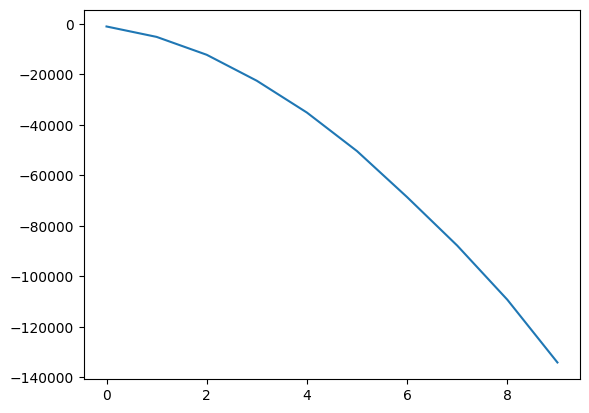

In [33]:
plt.plot(training_loss)

In [263]:
model_path = artifacts_path.joinpath("crf.pth")

In [264]:
torch.save(model.state_dict(), model_path)

In [265]:
get_file_size(model_path)

'14.83MiB'

In [266]:
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

## baseline

In [273]:
baseline = LSTMDiscriminator(
    VOCAB_SIZE,
    EMBED_DIM,
    HIDDEN_DIM,
    NUM_CLASS,
    num_layers=2,
    bidirectional=True,
    context=CONTEXT,
    sequence_output=True,
).to(DEVICE)

In [30]:
torchinfo.summary(baseline)

Layer (type:depth-idx)                   Param #
LSTMDiscriminator                        --
├─Embedding: 1-1                         2,728,200
├─LSTM: 1-2                              1,142,784
├─LayerNorm: 1-3                         1,024
├─Linear: 1-4                            10,773
Total params: 3,882,781
Trainable params: 3,882,781
Non-trainable params: 0

In [274]:
trainer = ClassificationTrainer(EPOCHES, DEVICE, feature_last=True)

In [275]:
criterion = nn.CrossEntropyLoss(ignore_index=CONTEXT.padding_idx)
optimizer = torch.optim.Adam(baseline.parameters(), lr=1e-3)

In [276]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    "min",
    patience=2,
    threshold=0.05,
    threshold_mode="rel",
)

In [277]:
training_loss = trainer.run(
    train_iter,
    baseline,
    optimizer,
    criterion,
    scheduler,
)

100%|██████████| 299/299 [00:17<00:00, 17.51it/s]


epoch 1 : 0.20769469071192087


100%|██████████| 299/299 [00:16<00:00, 17.74it/s]


epoch 2 : 0.12071870005748743


100%|██████████| 299/299 [00:16<00:00, 18.12it/s]


epoch 3 : 0.09760835143834054


100%|██████████| 299/299 [00:15<00:00, 19.13it/s]


epoch 4 : 0.08158365539882494


100%|██████████| 299/299 [00:15<00:00, 19.37it/s]


epoch 5 : 0.06772077530871666


100%|██████████| 299/299 [00:15<00:00, 19.23it/s]


epoch 6 : 0.05522823458331883


100%|██████████| 299/299 [00:15<00:00, 18.88it/s]


epoch 7 : 0.04406886565869668


100%|██████████| 299/299 [00:16<00:00, 18.01it/s]


epoch 8 : 0.03340685766277505


100%|██████████| 299/299 [00:16<00:00, 17.61it/s]


epoch 9 : 0.025213375877601446


100%|██████████| 299/299 [00:16<00:00, 17.80it/s]

epoch 10 : 0.018613901839632054


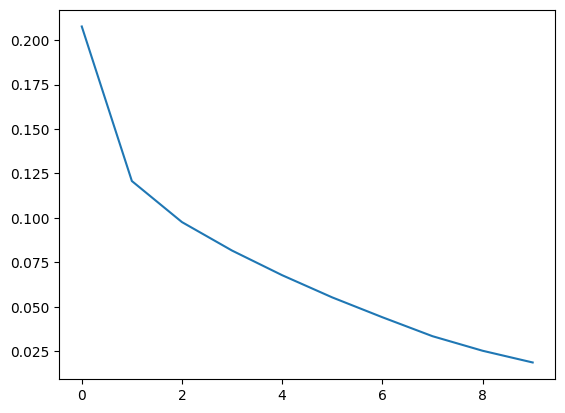

In [278]:
plt.plot(training_loss)

In [279]:
baseline_path = artifacts_path.joinpath("baseline.pth")

In [280]:
torch.save(baseline.state_dict(), baseline_path)

In [281]:
get_file_size(baseline_path)

'14.83MiB'

In [282]:
baseline.load_state_dict(torch.load(baseline_path))

<All keys matched successfully>

# prediction


In [34]:
model.eval()
with torch.no_grad():
    for i, (_, row) in enumerate(train_data.iterrows()):
        sentence, tag = row['Text'], row['Label']
        x = text_transform(tokenizer(sentence)).unsqueeze(0).to(DEVICE)
        tag_seq, score = model.forward(x, output_score=True)
        tag_seq = np.array(tag_seq.long()).flatten().tolist()
        decoded_seq = label_vocab.lookup_tokens(tag_seq)
        print("--------------sentence", i)
        print("score: ", score.item())
        print("pred : ", *[f"{d:<5}" for d in decoded_seq[1:-1]])
        print("label: ", *[f"{t:<5}" for t in tokenizer(tag)])
        print("text : ", sentence)
        print()
        if i > 10:
            break

--------------sentence 0
score:  -746.4246826171875
pred :  b-art b-art b-art b-art b-art b-art b-art b-art b-art b-art b-art b-art b-art b-art b-art b-art b-art b-art b-art b-art b-art b-art b-art b-art b-art b-art b-art b-art b-art b-art b-art b-art b-art b-art b-art b-art b-art b-art b-art b-art b-art b-art b-art b-art b-art b-art b-art b-art b-art b-art b-art b-art b-art b-art b-art b-art b-art b-art b-art b-art b-art b-art b-art b-art b-art b-art b-art b-art b-art b-art b-art b-art b-art b-art b-art b-art b-art b-art b-art b-art b-art b-art b-art b-art b-art b-art b-art b-art b-art b-art b-art b-art b-art b-art b-art b-art b-art b-art b-art b-art b-art b-art b-art b-art b-art b-art b-art b-art b-art b-art b-art b-art b-art b-art b-art b-art b-art b-art b-art b-art b-art b-art b-art b-art b-art b-art b-art b-art b-art b-art b-art b-art b-art b-art b-art b-art b-art b-art b-art b-art b-art b-art b-art b-art b-art b-art b-art b-art b-art b-art b-art b-art b-art b-art b-art b-art b-ar

In [288]:
baseline.eval()
with torch.no_grad():
    for i, (_, row) in enumerate(train_data.iterrows()):
        sentence, tag = row['Text'], row['Label']
        x = text_transform(tokenizer(sentence)).unsqueeze(0).to(DEVICE)
        score = baseline(x).detach().cpu()
        tag_seq = score.argmax(-1).numpy().flatten().tolist()
        decoded_seq = label_vocab.lookup_tokens(tag_seq[:len(sentence.split())])
        print("--------------sentence", i)
        print("pred : ", *[f"{d:<5}" for d in decoded_seq])
        print("label: ", *[f"{t:<5}" for t in tokenizer(tag)])
        print("text : ", sentence)
        print()
        if i > 10:
            break

--------------sentence 0
pred :  <bos> b-org i-org i-org o     o     o     b-tim o     o     o     o     o     o     o     o     o     o    
label:  b-org i-org i-org o     o     o     b-tim o     o     o     o     o     o     o     o     o     o     o    
text :  U Win Tin was arrested in 1989 and is serving a 20-year sentence for writing anti-government propaganda .

--------------sentence 1
pred :  <bos> o     o     o     o     b-gpe o     o     o     o     o     o     o     b-tim o     o     o     b-per i-per i-per o    
label:  o     o     o     o     b-gpe o     o     o     o     o     o     o     b-tim o     o     o     b-per i-per i-per o     o    
text :  The last time the Vatican issued a vacant see stamp was in 1978 , when Pope John Paul I died .

--------------sentence 2
pred :  <bos> o     o     o     o     b-gpe o     o     o     o     b-geo i-geo o     o     o     o     b-tim o     o     b-gpe o     o     o     b-geo i-geo
label:  o     o     o     o     b-gpe o     o   

# Evaluation


## model

In [35]:
evaluator = ClassificationEvaluator(NUM_CLASS, DEVICE, feature_dim=-1)

In [36]:
confusion_matrix = evaluator.run(test_iter, model.foot)

  0%|          | 0/75 [00:00<?, ?it/s]

100%|██████████| 75/75 [00:08<00:00,  8.88it/s]

[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0]
 [   0 9592    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0]
 [   0    0 6979    0 2526   26   23    1    3    2    1    6    4   20
     0    1    0    0    0    0    0]
 [   0    0 3439    0 9592   34   16    0    6    0    0    3   14   12
     0    0    0    0    0    0    0]
 [   0    0  711    0 9590  933  821  350  288  379  517  294  182  190
    78  225    6   11   11    6    0]
 [   0    0   15    0 2306 2836   42  186   12  178   16  256   48   11
    17   67    0    0    0    0    0]
 [   0    0    5    0 1312   65 2311    2    6    6    3    2    2   81
     0   18    0    0    0    0    0]
 [   0    0    5    0 1963  316   11  873   31  189   90   93    4    4
    43   56    0    1    1    0    0]
 [   0    0    5    0 1022   73    5   20 1228  168   68    8   22    1
     0    0    1    0    0    0    0]
 [   0    

In [37]:
per_class_acc = evaluator.get_per_class_accuracy(confusion_matrix)
evaluator.show_per_class_accuracy(label_vocab.get_itos(), per_class_acc)

<unk>     : 0.0
<bos>     : 1.0
<eos>     : 0.7275854879065888
<pad>     : 0.0
o         : 0.6572094298245614
b-geo     : 0.4734557595993322
b-tim     : 0.6060844479412536
b-org     : 0.23722826086956522
i-per     : 0.4685234643265929
b-per     : 0.4345869495339119
i-org     : 0.33962264150943394
b-gpe     : 0.5546129374337222
i-geo     : 0.3621460506706408
i-tim     : 0.40082644628099173
b-art     : 0.030303030303030304
b-eve     : 0.359375
i-art     : 0.025
i-eve     : 0.13333333333333333
b-nat     : 0.11904761904761904
i-gpe     : 0.40816326530612246
i-nat     : 0.0


d:\research\pytorch-implementations\.venv\Lib\site-packages\torchlake\common\controller\evaluator.py:104: RuntimeWarning: invalid value encountered in divide
  return np.where(total == 0, 0, hits / total)


In [38]:
per_class_acc[4:].mean()

0.3299716844694183

d:\research\pytorch-implementations\.venv\Lib\site-packages\torchlake\common\controller\evaluator.py:123: RuntimeWarning: invalid value encountered in divide
  percentage = np.where(total == 0, 0, hits / total)


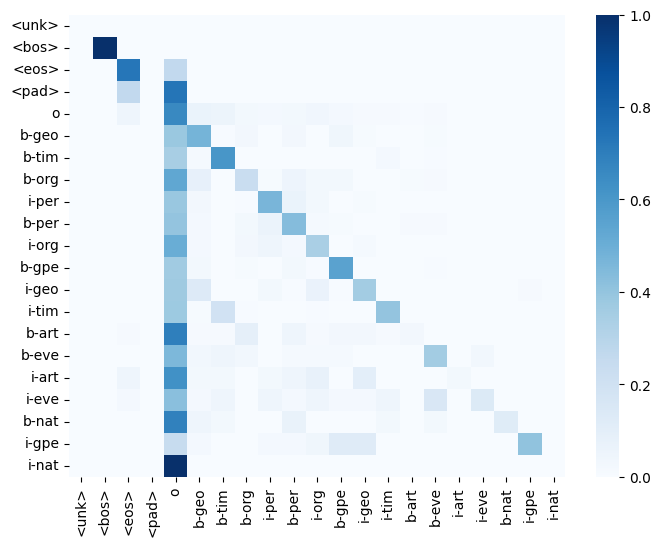

In [39]:
evaluator.plot_confusion_matrix(
    confusion_matrix,
    label_vocab.get_itos(),
    "Blues",
    annot=False,
    figsize=(8, 6),
)

## baseline

In [283]:
evaluator = ClassificationEvaluator(NUM_CLASS, DEVICE, feature_dim=-1)

In [284]:
confusion_matrix = evaluator.run(test_iter, baseline)

100%|██████████| 75/75 [00:05<00:00, 14.57it/s]

[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0]
 [   0 9592    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0]
 [   0    0 8989    0  568    9   11    1    6    0    1    2    1    4
     0    0    0    0    0    0    0]
 [   0    0 9592    0 1430    4    3    0    0    0    0    1    1    5
     0    0    0    0    0    0    0]
 [   0    0  572    0 9590  814  497  460  190  297  348  183  130  142
    10    6    4    7    8    1    2]
 [   0    0   22    0 1133 3942   60  257   27   76   21   72   67    5
     1    2    0    0    0    0    0]
 [   0    0    7    0  873   62 2701   15    6    8    2    4    0   87
     1    3    0    0    0    0    0]
 [   0    0    6    0  977  484   13 1869   46  139   71   37    9    2
     6    0    0    2    0    0    0]
 [   0    0    8    0  338   25    4   31 1781  144   90    7   26    1
     1    0    1    0    0    0    0]
 [   0    

In [285]:
per_class_acc = evaluator.get_per_class_accuracy(confusion_matrix)
evaluator.show_per_class_accuracy(label_vocab.get_itos(), per_class_acc)

<unk>     : 0.0
<bos>     : 1.0
<eos>     : 0.9371351125938282
<pad>     : 0.0
o         : 0.7231732146896915
b-geo     : 0.6934036939313984
b-tim     : 0.7166357123905546
b-org     : 0.5105162523900574
i-per     : 0.7248677248677249
b-per     : 0.6498506471954862
i-org     : 0.4925581395348837
b-gpe     : 0.793859649122807
i-geo     : 0.5794676806083651
i-tim     : 0.5751295336787565
b-art     : 0.058823529411764705
b-eve     : 0.28125
i-art     : 0.05405405405405406
i-eve     : 0.1956521739130435
b-nat     : 0.3488372093023256
i-gpe     : 0.5306122448979592
i-nat     : 0.2222222222222222


d:\research\pytorch-implementations\.venv\Lib\site-packages\torchlake\common\controller\evaluator.py:104: RuntimeWarning: invalid value encountered in divide
  return np.where(total == 0, 0, hits / total)


In [286]:
per_class_acc[4:].mean()

0.4794655107182996

d:\research\pytorch-implementations\.venv\Lib\site-packages\torchlake\common\controller\evaluator.py:123: RuntimeWarning: invalid value encountered in divide
  percentage = np.where(total == 0, 0, hits / total)


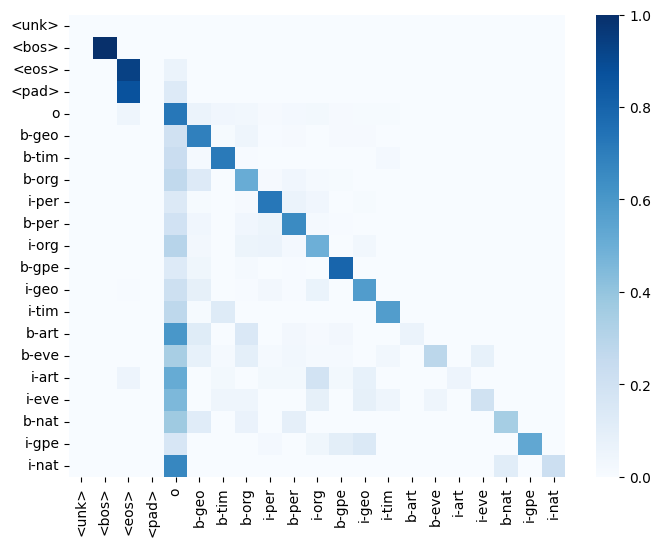

In [287]:
evaluator.plot_confusion_matrix(
    confusion_matrix,
    label_vocab.get_itos(),
    "Blues",
    annot=False,
    figsize=(8, 6),
)

# Visualization


<Axes: title={'center': 'transition likelihood'}>

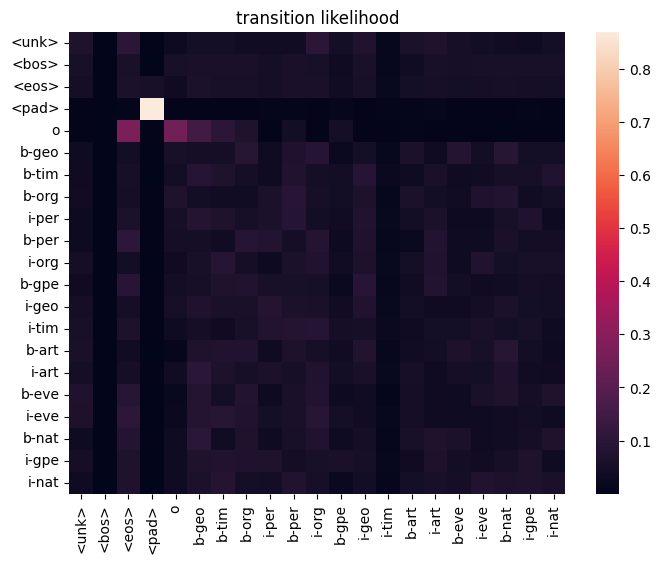

In [38]:
plt.figure(figsize=(8, 6))
plt.title('transition likelihood')
heatmap(
    model.head.transition
    .softmax(-1)
    # .div(-torch.inf)
    .clone()
    .detach()
    .cpu()
    .numpy(),
    xticklabels=label_vocab.get_itos(),
    yticklabels=label_vocab.get_itos(),
)